# Overview of perturbations with associated quintuplicate SEM (kcal/mol)

In [26]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt 
import seaborn as sns 
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
from collections import defaultdict

from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.warning')
from rdkit.Chem import Draw, rdFMCS

from rdkit.Chem import rdRGroupDecomposition, AllChem
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor, rdmolfiles
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.image as mpimg

In [2]:
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])
quints_infos.sort_values(by="sem")

set                       pertname     pertsmarts  num_ha  \
852   TrainingSet  mobley_1563176~mobley_2802855   [C*]S~[C*]Br       1   
853   TrainingSet  mobley_2802855~mobley_1563176   [C*]Br~[C*]S       1   
4208  TrainingSet  mobley_1755375~mobley_5571660    [C*]O~[C*]N       1   
4209  TrainingSet  mobley_5571660~mobley_1755375    [C*]N~[C*]O       1   
1818  TrainingSet   mobley_186894~mobley_7708038   [C*]S~[C*]Br       1   
...           ...                            ...            ...     ...   
4216  TrainingSet  mobley_2043882~mobley_6175884    [C*]C~[C*]C       1   
531   TrainingSet  mobley_4218209~mobley_1036761        [C*]OC~       2   
530   TrainingSet  mobley_1036761~mobley_4218209        ~[C*]OC       2   
1092  TrainingSet  mobley_1036761~mobley_2859600  [CH*]N~[C*]CC       2   
1093  TrainingSet  mobley_2859600~mobley_1036761  [C*]CC~[CH*]N       2   

            sem  
852    0.006843  
853    0.006843  
4208   0.008176  
4209   0.008176  
1818   0.010947  
...         ...  
4216  26.331465  
531   33.708322  
530   33.708322  
1092  38.086474  
1093  38.086474  

[4558 rows x 5 columns]

In [23]:
#Draw the molecule
def get_image(mol,atomset=None):    
    hcolor = colors.to_rgb('red')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img


def generateImages(mol,row,core,width=350,height=200,
                      fillRings=False,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=None):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
    if not row:
        # return molecule without R group coloring.
        AllChem.Compute2DCoords(mol)
        d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
        dos = d2d.drawOptions()
        dos.useBWAtomPalette()
        #----------------------
        # now draw the molecule, without highlights:
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        png = d2d.GetDrawingText()

        # save to file:
        d2d.WriteDrawingText("tmp_imgs/"+legend+".png")

        return png
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    # loop over R groups.
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        try:
            rquery = row[lbl]
        # we don't know the number of R-groups, so just quit this loop if we've reached the end.
        except KeyError:
        	continue

        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,"",dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()

    # save to file:
    d2d.WriteDrawingText("tmp_imgs/"+legend+".png")
        
    return png

In [24]:
def plot_perts(quints_infos, precision=7):
    
    ligs_path = "./quintup_ligands/sdffiles/"

    for idx, pertinfo in quints_infos.iterrows():
        pert = pertinfo["pertname"]
        
        # get the five freenrg values that make up the SEM.
        # do this first because if this fails this is a reversed pert and we don't want to plot it.
        perts_mbars = pd.read_csv("quintup_ligands/compiled_mbar_freenrgs.csv")
        try:
            mbar_vals = perts_mbars[perts_mbars["pert"] == pert][["freenrg_1", "freenrg_2", "freenrg_3", "freenrg_4", "freenrg_5"]].values[0]
        except IndexError:
            continue
            
        
        print(pert)
        
        ## get the paths to simulation folders on yoko
        with open("/home/jscheen/projects/HYDRA_LEARN/QUINTUP/COLLECTION/all_mbar_paths.txt", "r") as pathsfile:
            reader = csv.reader(pathsfile)
            for row in reader:
                if pert in row[0]:
                    print(row[0])
        
        ##
        


        ligA = Chem.SDMolSupplier(ligs_path+pert.split("~")[0]+".sdf")[0]
        ligB = Chem.SDMolSupplier(ligs_path+pert.split("~")[1]+".sdf")[0]

        mcs = rdFMCS.FindMCS([ligA, ligB], matchValences=False,
                                        ringMatchesRingOnly=True,
                                        completeRingsOnly=True,
                                        matchChiralTag=False)
        core = Chem.MolFromSmarts(mcs.smartsString)
        rdDepictor.Compute2DCoords(core)

        rdkit_mols = [ligA, ligB]
        # find subtructure matches with MCS per ligand, then tag matching atom indices in each ligand.
        ps = Chem.AdjustQueryParameters.NoAdjustments()
        ps.makeDummiesQueries=True
        qcore = Chem.AdjustQueryProperties(core,ps)
        #mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
        mms = [x for x in rdkit_mols if x.HasSubstructMatch(core)]
        for m in mms:
            for atom in m.GetAtoms():
                atom.SetIntProp("SourceAtomIdx",atom.GetIdx())

        # do an RDKit R-group decomposition.	
        groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

        # call the writer function with each molecule.
        ligand_names = [pert.split("~")[0], pert.split("~")[1]]
        #for i, m in enumerate(rdkit_mols):
        if groups:
            generateImages(rdkit_mols[0],groups[0],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                    legend=ligand_names[0],
                                    width=400,height=400)
            generateImages(rdkit_mols[1],groups[1],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                    legend=ligand_names[1],
                                    width=400,height=400)
        else:
            print("poep")
            generateImages(rdkit_mols[0],None,qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                    legend=ligand_names[0],
                                    width=400,height=400)
            generateImages(rdkit_mols[1],None,qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                    legend=ligand_names[1],
                                    width=400,height=400)            


        # now that this image is saved, load it into matplotlib for easier side-by-sde viewing.
        imgA = mpimg.imread("tmp_imgs/"+ligand_names[0]+".png")
        imgB = mpimg.imread("tmp_imgs/"+ligand_names[1]+".png")

        fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 3, 1, 1]})
        axes[0].imshow(imgA)
        axes[1].imshow(imgB)

        # get some more pert info and annotate it.
        axes[2].annotate("    SEM:", xy=(0, 0.7), size=25)
        axes[3].annotate(round(pertinfo["sem"], 7), xy=(0, 0.7), size=25)

        axes[2].annotate("SMARTS:", xy=(0, 0.3), size=20)
        axes[3].annotate(pertinfo["pertsmarts"], xy=(0, 0.3), size=15)
        
        # annotate the SEm constituents.
        
        for i, val in enumerate(mbar_vals):
            axes[3].annotate(round(float(val), precision), xy=(0, 0.6-(i*0.05)))
        axes[2].annotate("Constituents:", xy=(0, 0.5), size=20)


        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()
        print("__________________________________________________________________________________________________________")

# Highest 5 SEMs

mobley_1036761~mobley_2859600
./QUINTUP/30_dir_dir/finished/job_xaz/sim_14/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_13/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_12/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_15/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_11/mobley_1036761~mobley_2859600/free


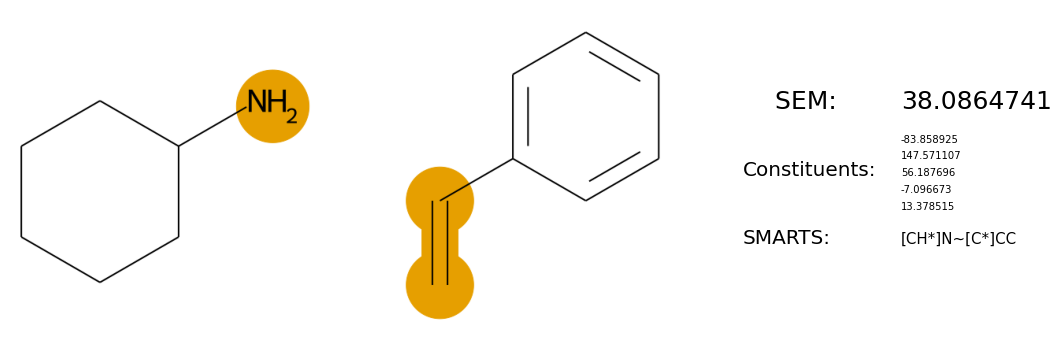

__________________________________________________________________________________________________________
mobley_1036761~mobley_4218209
./QUINTUP/30_dir_dir/finished/job_xbb/sim_3/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_1/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_5/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_4/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_2/mobley_1036761~mobley_4218209/free


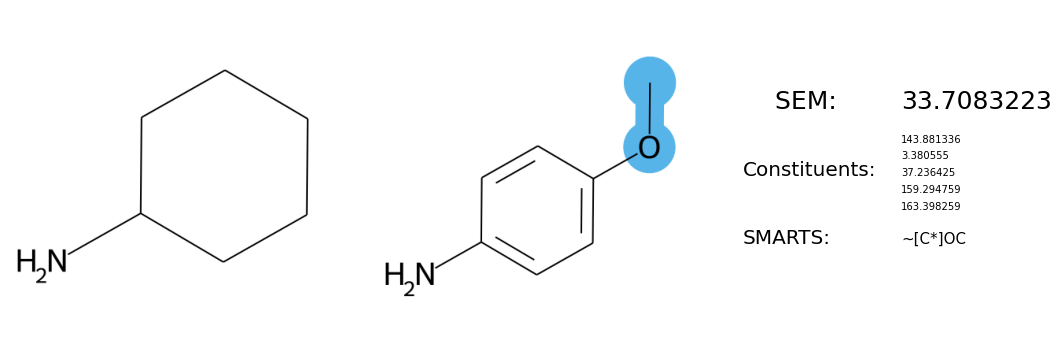

__________________________________________________________________________________________________________
mobley_2043882~mobley_6175884
./QUINTUP/29_dir_dir/finished/job_xiy/sim_18/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_20/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_17/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_19/mobley_2043882~mobley_6175884/free
./QUINTUP/29_dir_dir/finished/job_xiy/sim_16/mobley_2043882~mobley_6175884/free


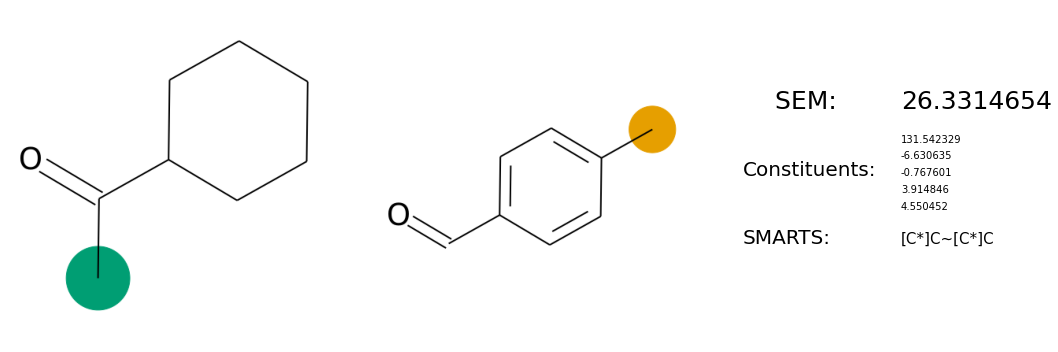

__________________________________________________________________________________________________________
mobley_1571523~mobley_2763835
./QUINTUP/30_dir_dir/finished/job_xgw/sim_3/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_1/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_5/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_4/mobley_1571523~mobley_2763835/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_2/mobley_1571523~mobley_2763835/free


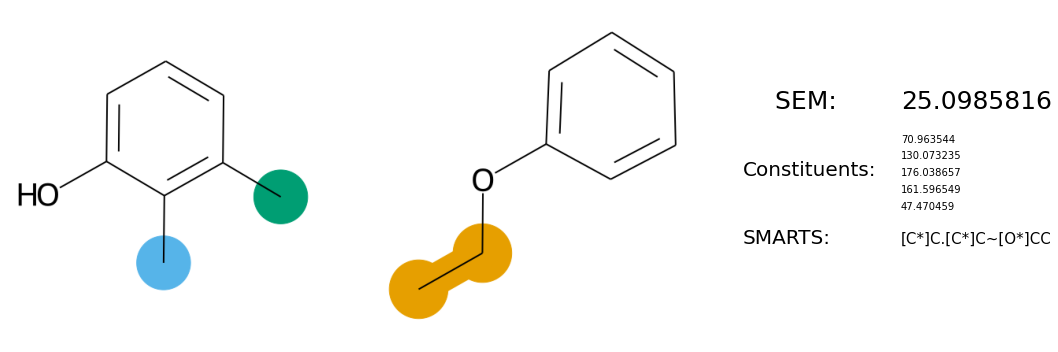

__________________________________________________________________________________________________________
mobley_1036761~mobley_1189457
./QUINTUP/30_dir_dir/finished/job_xax/sim_14/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_13/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_12/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_15/mobley_1036761~mobley_1189457/free
./QUINTUP/30_dir_dir/finished/job_xax/sim_11/mobley_1036761~mobley_1189457/free


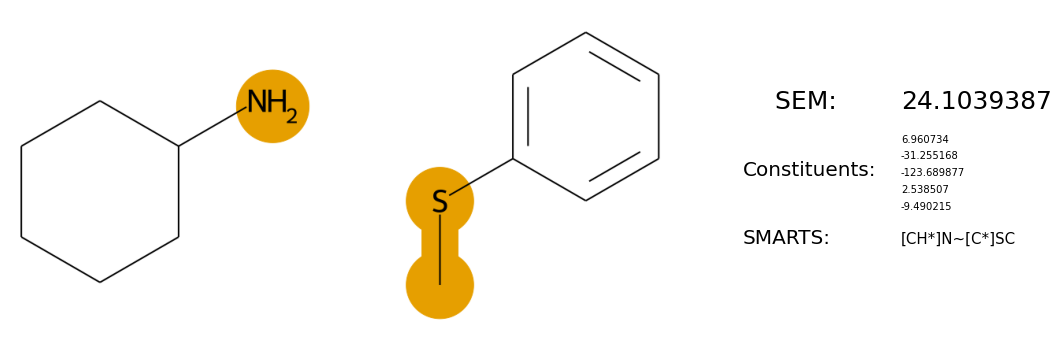

__________________________________________________________________________________________________________
mobley_1728386~mobley_1571523
./QUINTUP/30_dir_dir/finished/job_xjj/sim_7/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_9/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_8/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_6/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_10/mobley_1728386~mobley_1571523/free


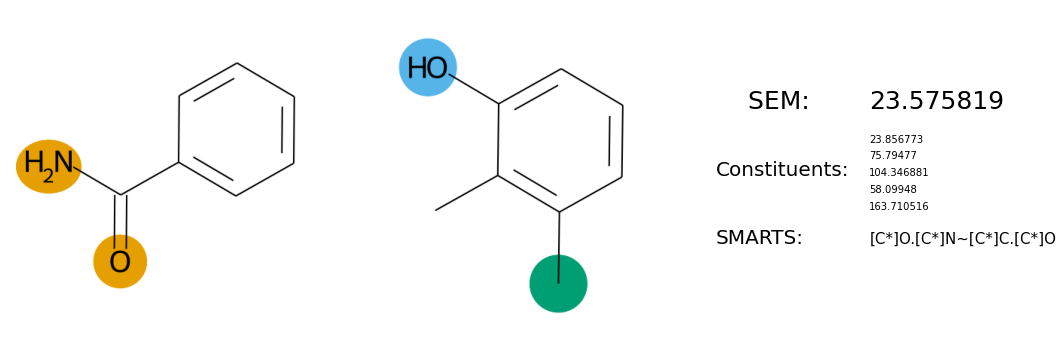

__________________________________________________________________________________________________________
mobley_1571523~mobley_1728386
./QUINTUP/30_dir_dir/finished/job_xgs/sim_18/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_20/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_17/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_19/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_16/mobley_1571523~mobley_1728386/free


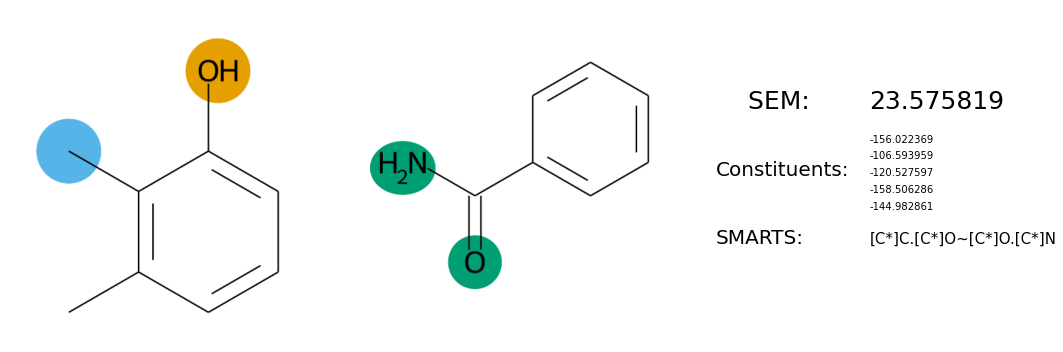

__________________________________________________________________________________________________________
mobley_1571523~mobley_5072416
./QUINTUP/30_dir_dir/finished/job_xgz/sim_7/mobley_1571523~mobley_5072416/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_9/mobley_1571523~mobley_5072416/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_8/mobley_1571523~mobley_5072416/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_6/mobley_1571523~mobley_5072416/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_10/mobley_1571523~mobley_5072416/free


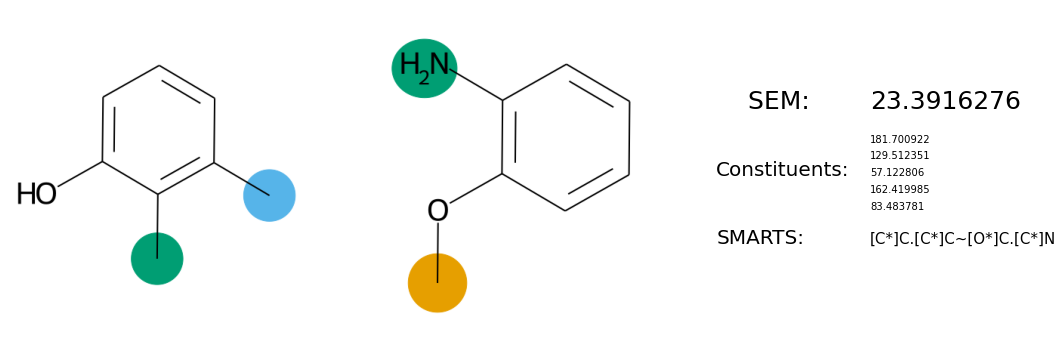

__________________________________________________________________________________________________________
mobley_9507933~mobley_6309289
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_7/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_9/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_8/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_6/mobley_9507933~mobley_6309289/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_10/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_7/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_9/mobley_9507933~mobley_6309289/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_8/mobley_9507933~mobley_6309289/free
./MGZ_

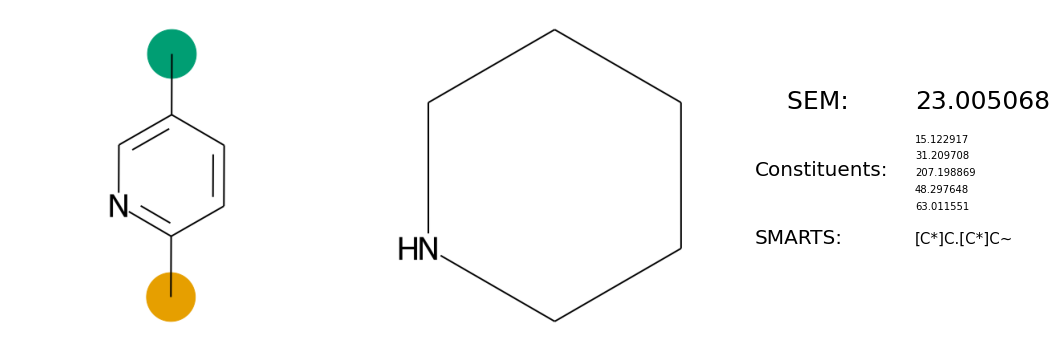

__________________________________________________________________________________________________________
mobley_1520842~mobley_6988468
./QUINTUP/30_dir_dir/finished/job_xgb/sim_14/mobley_1520842~mobley_6988468/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_13/mobley_1520842~mobley_6988468/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_12/mobley_1520842~mobley_6988468/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_15/mobley_1520842~mobley_6988468/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_11/mobley_1520842~mobley_6988468/free


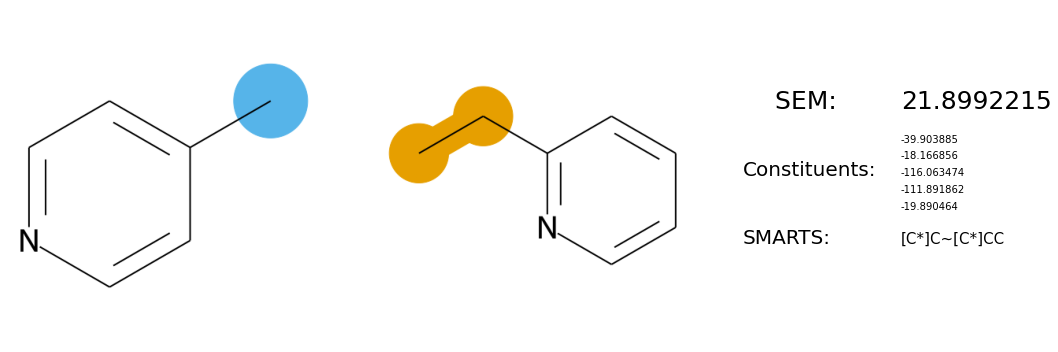

__________________________________________________________________________________________________________
mobley_1728386~mobley_1755375
./QUINTUP/30_dir_dir/finished/job_xjj/sim_14/mobley_1728386~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_13/mobley_1728386~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_12/mobley_1728386~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_15/mobley_1728386~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_11/mobley_1728386~mobley_1755375/free


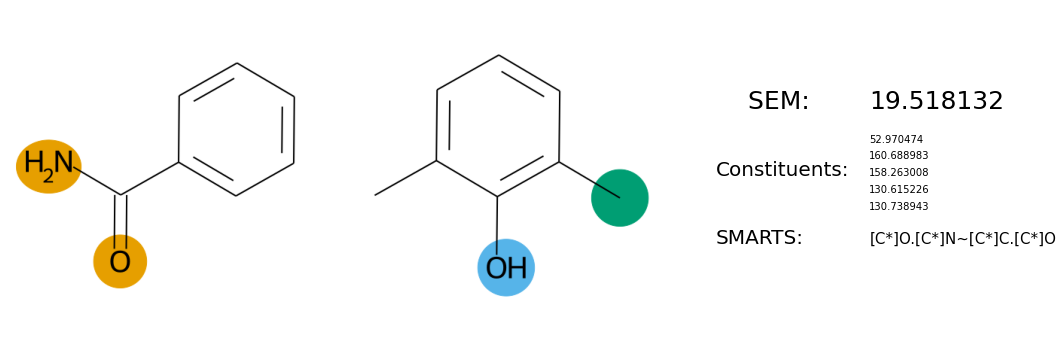

__________________________________________________________________________________________________________
mobley_1571523~mobley_7295828
./QUINTUP/30_dir_dir/finished/job_xhc/sim_7/mobley_1571523~mobley_7295828/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_9/mobley_1571523~mobley_7295828/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_8/mobley_1571523~mobley_7295828/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_6/mobley_1571523~mobley_7295828/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_10/mobley_1571523~mobley_7295828/free


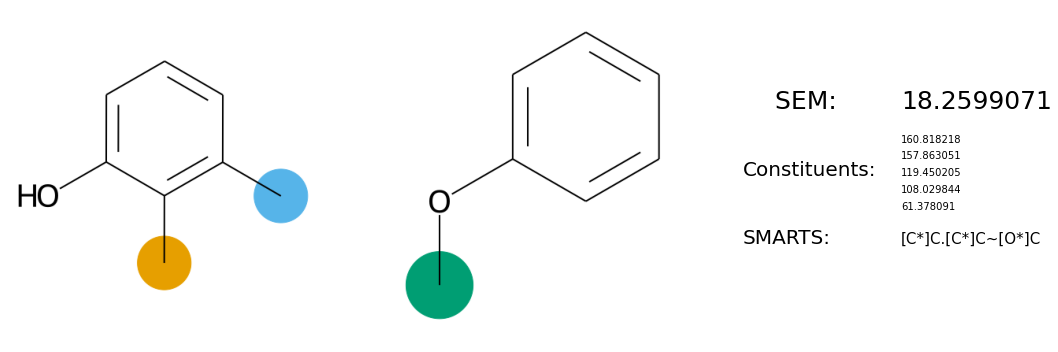

__________________________________________________________________________________________________________
mobley_1571523~mobley_3515580
./QUINTUP/30_dir_dir/finished/job_xgx/sim_14/mobley_1571523~mobley_3515580/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_13/mobley_1571523~mobley_3515580/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_12/mobley_1571523~mobley_3515580/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_15/mobley_1571523~mobley_3515580/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_11/mobley_1571523~mobley_3515580/free


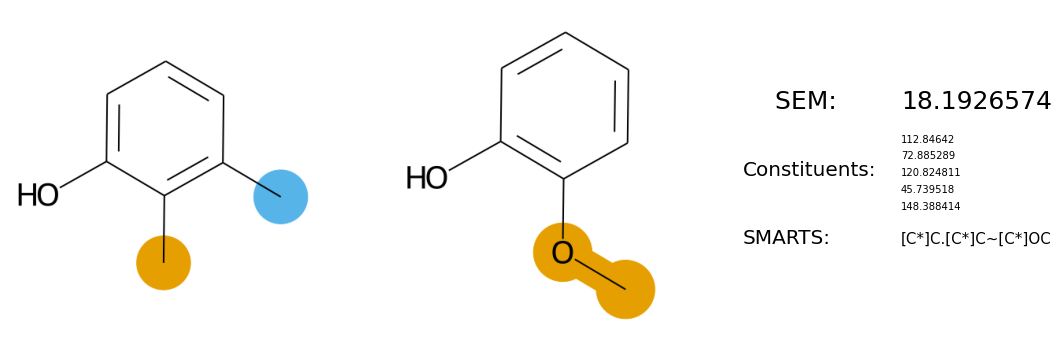

__________________________________________________________________________________________________________
mobley_1873346~mobley_7010316
./QUINTUP/29_dir_dir/finished/job_xfz/sim_7/mobley_1873346~mobley_7010316/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_7/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_9/mobley_1873346~mobley_7010316/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_9/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_6/mobley_1873346~mobley_7010316/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_6/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_10/mobley_1873346~mobley_7010316/mobley_1873346~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_10/mobley_1873346~mobley_7010316/free


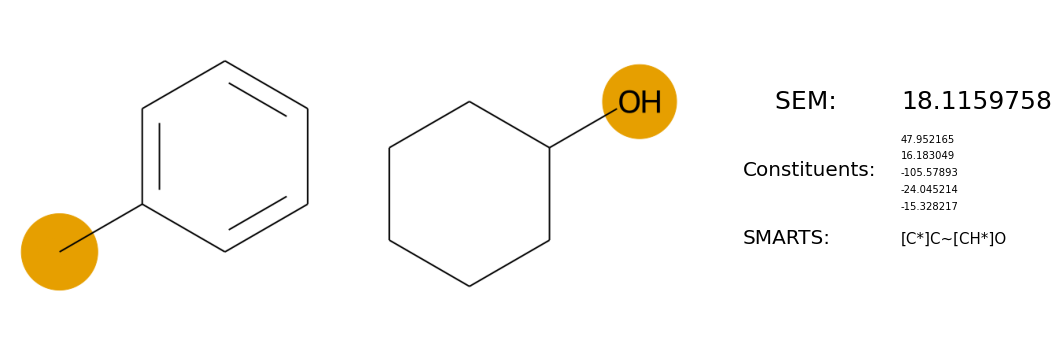

__________________________________________________________________________________________________________
mobley_1046331~mobley_6743808
./QUINTUP/30_dir_dir/finished/job_xbj/sim_14/mobley_1046331~mobley_6743808/free
./QUINTUP/30_dir_dir/finished/job_xbj/sim_13/mobley_1046331~mobley_6743808/free
./QUINTUP/30_dir_dir/finished/job_xbj/sim_12/mobley_1046331~mobley_6743808/free
./QUINTUP/30_dir_dir/finished/job_xbj/sim_15/mobley_1046331~mobley_6743808/free
./QUINTUP/30_dir_dir/finished/job_xbj/sim_11/mobley_1046331~mobley_6743808/free


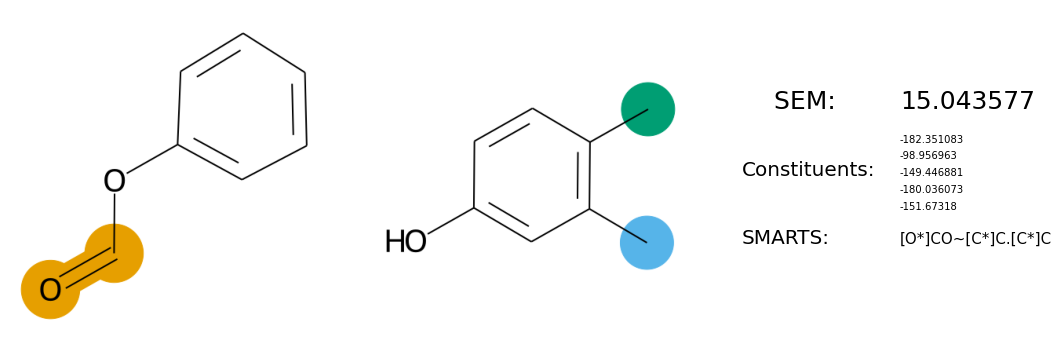

__________________________________________________________________________________________________________
mobley_1755375~mobley_2126135
./QUINTUP/29_dir_dir/finished/job_xeh/sim_7/mobley_1755375~mobley_2126135/free
./QUINTUP/29_dir_dir/finished/job_xeh/sim_9/mobley_1755375~mobley_2126135/free
./QUINTUP/29_dir_dir/finished/job_xeh/sim_8/mobley_1755375~mobley_2126135/free
./QUINTUP/29_dir_dir/finished/job_xeh/sim_6/mobley_1755375~mobley_2126135/free
./QUINTUP/29_dir_dir/finished/job_xeh/sim_10/mobley_1755375~mobley_2126135/free


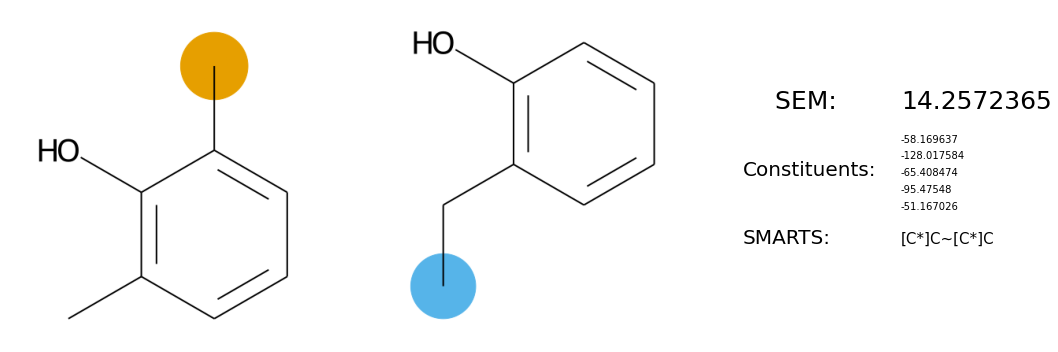

__________________________________________________________________________________________________________
mobley_9478823~mobley_3746675
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_18/mobley_9478823~mobley_3746675/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_20/mobley_9478823~mobley_3746675/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_17/mobley_9478823~mobley_3746675/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_19/mobley_9478823~mobley_3746675/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_16/mobley_9478823~mobley_3746675/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_18/mobley_9478823~mobley_3746675/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_20/mobley_9478823~mobley_3746675/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwv/sim_17/mobley_9478823~mobley_3746675/free

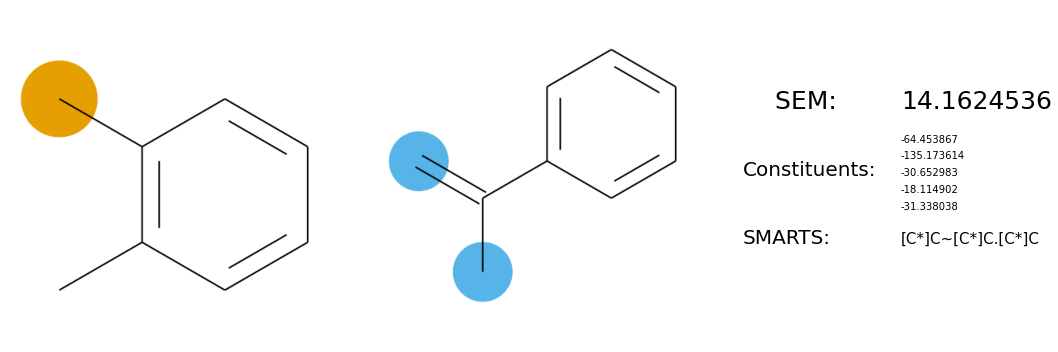

__________________________________________________________________________________________________________
mobley_9942801~mobley_1571523
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_14/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_13/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_12/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_15/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_11/mobley_9942801~mobley_1571523/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_14/mobley_9942801~mobley_1571523/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_13/mobley_9942801~mobley_1571523/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_12/mobley_9942801~mobley_1571523/free

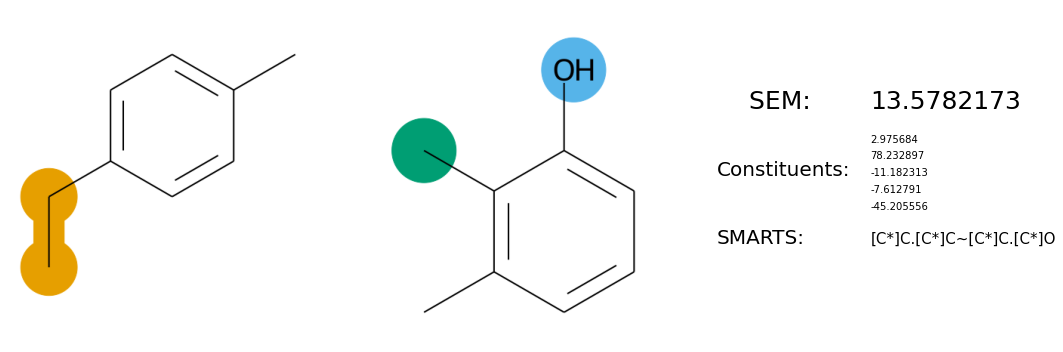

__________________________________________________________________________________________________________
mobley_1571523~mobley_9942801
./QUINTUP/30_dir_dir/finished/job_xhf/sim_7/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_9/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_8/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_6/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_10/mobley_1571523~mobley_9942801/free


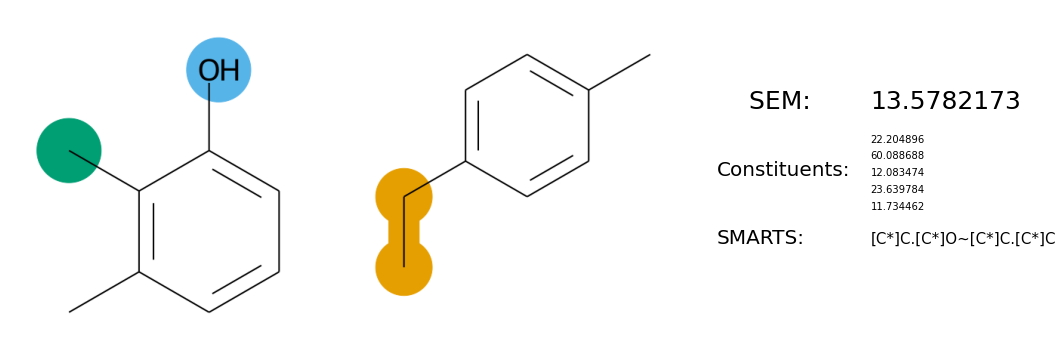

__________________________________________________________________________________________________________
mobley_3187514~mobley_4584540
./QUINTUP/23_dir_dir/round2/quintup_transform_6/job_0/GPU_population_0/mobley_3187514~mobley_4584540/free
./QUINTUP/23_dir_dir/round2/quintup_transform_6/job_0/GPU_population_1/mobley_3187514~mobley_4584540/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_0/mobley_3187514~mobley_4584540/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_1/mobley_3187514~mobley_4584540/free
./MGZ_RECENT/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_0/mobley_3187514~mobley_4584540/free
./MGZ_RECENT/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_1/mobley_3187514~mobley_4584540/free


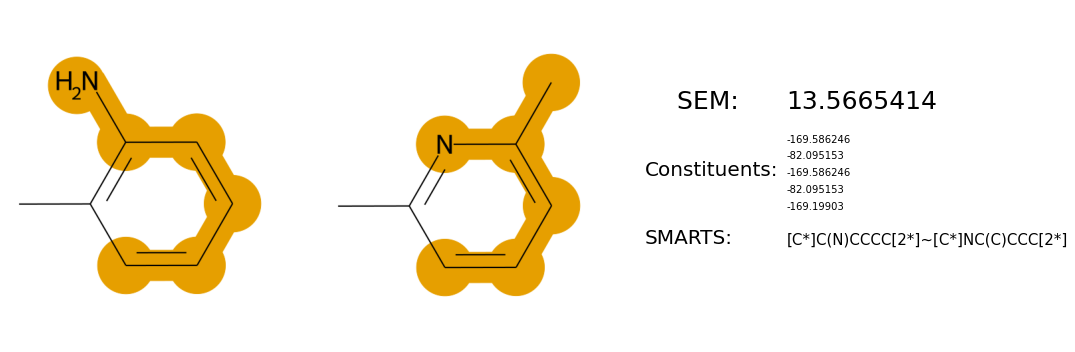

__________________________________________________________________________________________________________
mobley_6978427~mobley_3144334
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_2/mobley_6978427~mobley_3144334/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_1/mobley_6978427~mobley_3144334/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_0/mobley_6978427~mobley_3144334/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_3/mobley_6978427~mobley_3144334/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_1/mobley_6978427~mobley_3144334/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_2/mobley_6978427~mobley_3144334/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_1/mobley_6978427~mobley_3144334/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_1/GPU_population_0/mobley_6978427~mobley_3144334/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/jo

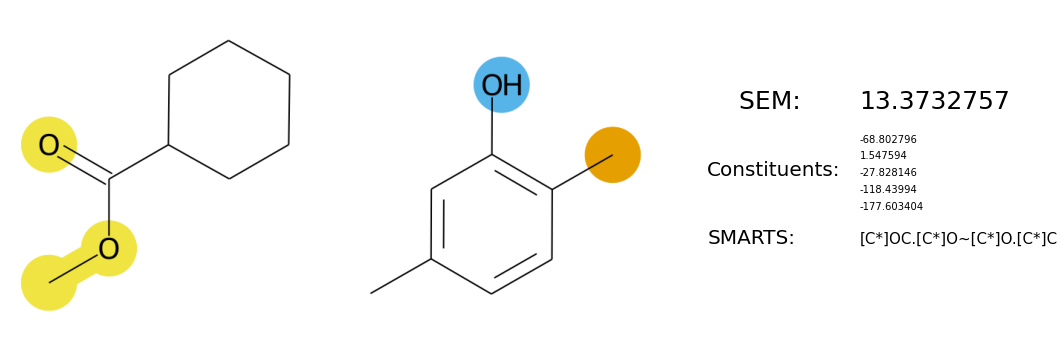

__________________________________________________________________________________________________________
mobley_1571523~mobley_3746675
./QUINTUP/30_dir_dir/finished/job_xgy/sim_7/mobley_1571523~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_9/mobley_1571523~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_8/mobley_1571523~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_6/mobley_1571523~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_10/mobley_1571523~mobley_3746675/free


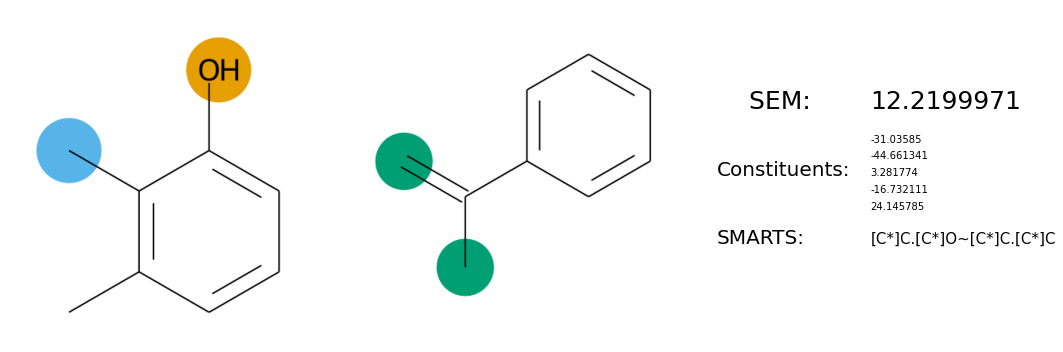

__________________________________________________________________________________________________________
mobley_1728386~mobley_2850833
./QUINTUP/29_dir_dir/finished/job_xea/sim_7/mobley_1728386~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xea/sim_9/mobley_1728386~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xea/sim_8/mobley_1728386~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xea/sim_6/mobley_1728386~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xea/sim_10/mobley_1728386~mobley_2850833/free


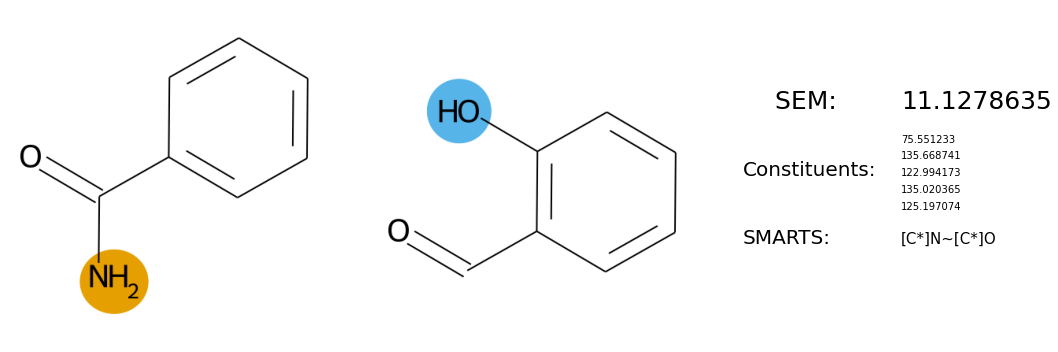

__________________________________________________________________________________________________________
mobley_1728386~mobley_1571523
./QUINTUP/30_dir_dir/finished/job_xjj/sim_7/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_9/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_8/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_6/mobley_1728386~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xjj/sim_10/mobley_1728386~mobley_1571523/free


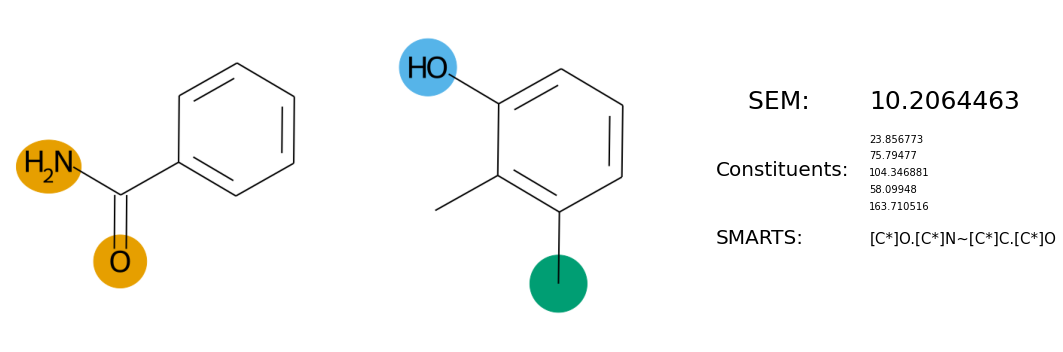

__________________________________________________________________________________________________________
mobley_1571523~mobley_1728386
./QUINTUP/30_dir_dir/finished/job_xgs/sim_18/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_20/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_17/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_19/mobley_1571523~mobley_1728386/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_16/mobley_1571523~mobley_1728386/free


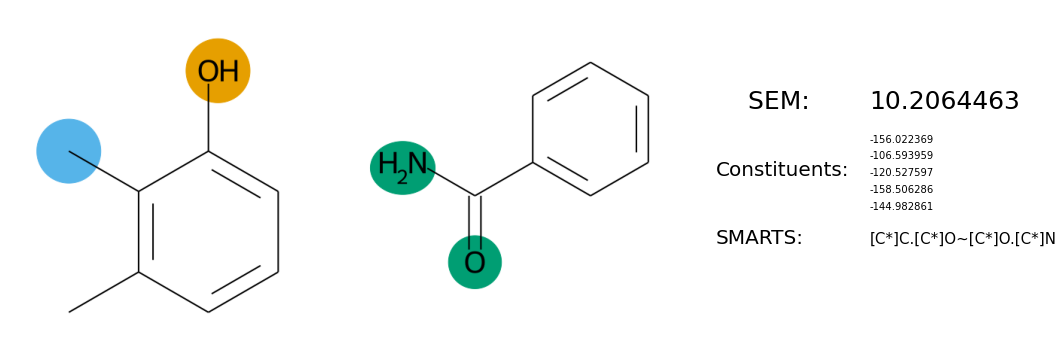

__________________________________________________________________________________________________________
mobley_9942801~mobley_4780078
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_7/mobley_9942801~mobley_4780078/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_9/mobley_9942801~mobley_4780078/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_8/mobley_9942801~mobley_4780078/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_6/mobley_9942801~mobley_4780078/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_10/mobley_9942801~mobley_4780078/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_7/mobley_9942801~mobley_4780078/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_9/mobley_9942801~mobley_4780078/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebi/sim_8/mobley_9942801~mobley_4780078/free
./MGZ_

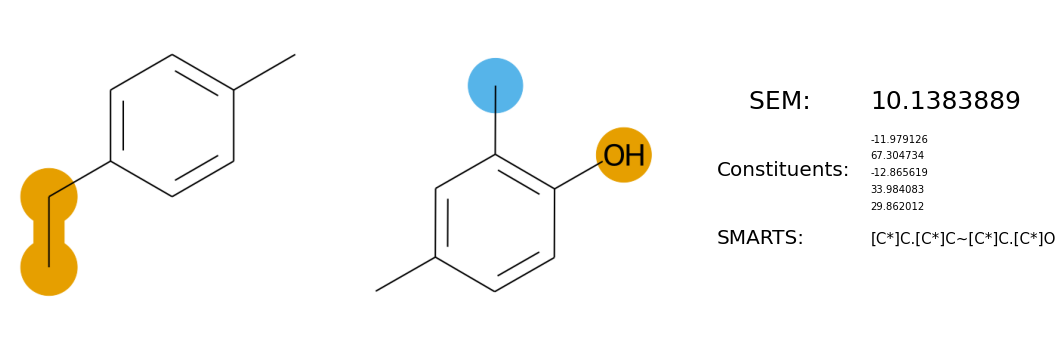

__________________________________________________________________________________________________________
mobley_9478823~mobley_7295828
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_3/mobley_9478823~mobley_7295828/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_1/mobley_9478823~mobley_7295828/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_5/mobley_9478823~mobley_7295828/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_4/mobley_9478823~mobley_7295828/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_2/mobley_9478823~mobley_7295828/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_3/mobley_9478823~mobley_7295828/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_1/mobley_9478823~mobley_7295828/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxa/sim_5/mobley_9478823~mobley_7295828/free
./MGZ_R

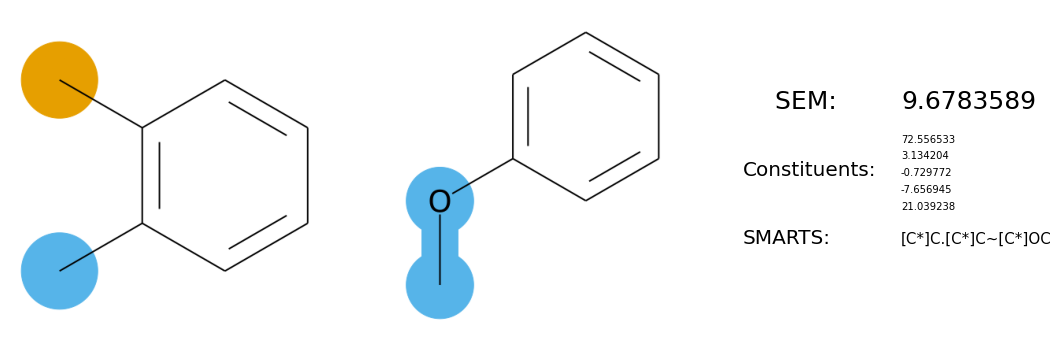

__________________________________________________________________________________________________________
mobley_9942801~mobley_1571523
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_14/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_13/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_12/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_15/mobley_9942801~mobley_1571523/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_11/mobley_9942801~mobley_1571523/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_14/mobley_9942801~mobley_1571523/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_13/mobley_9942801~mobley_1571523/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_12/mobley_9942801~mobley_1571523/free

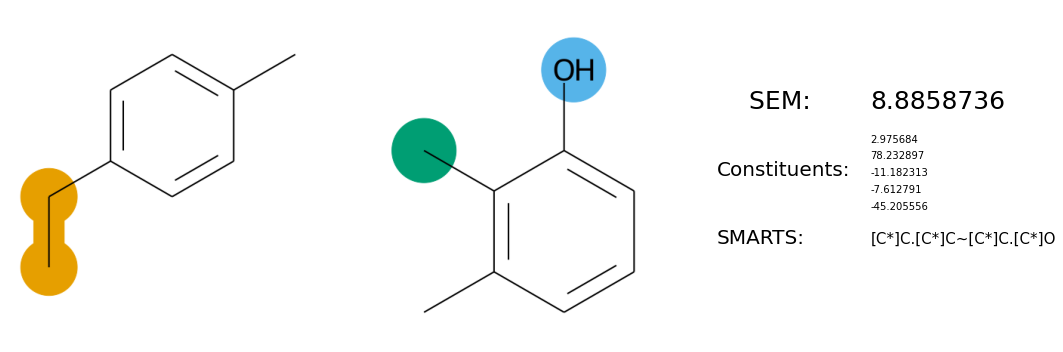

__________________________________________________________________________________________________________
mobley_1571523~mobley_9942801
./QUINTUP/30_dir_dir/finished/job_xhf/sim_7/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_9/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_8/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_6/mobley_1571523~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xhf/sim_10/mobley_1571523~mobley_9942801/free


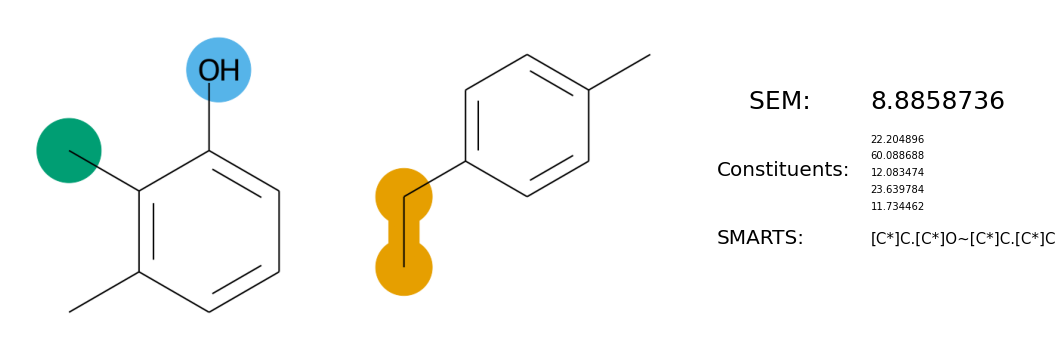

__________________________________________________________________________________________________________
mobley_9507933~mobley_63712
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_18/mobley_9507933~mobley_63712/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_17/mobley_9507933~mobley_63712/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/mobley_9507933~mobley_63712/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_16/mobley_9507933~mobley_63712/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_18/mobley_9507933~mobley_63712/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_17/mobley_9507933~mobley_63712/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/mobley_9507933~mobley_63712/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxe/sim_16/mobley_9507933~mobley_63712/free


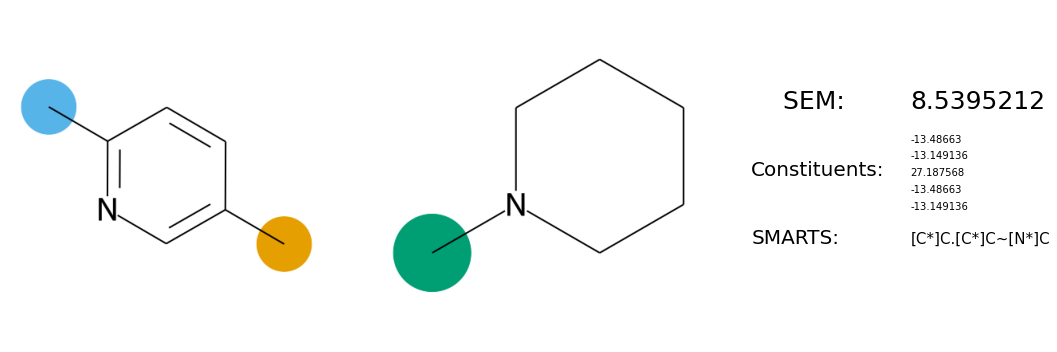

__________________________________________________________________________________________________________
mobley_1036761~mobley_3187514
./QUINTUP/29_dir_dir/finished/job_xal/sim_14/mobley_1036761~mobley_3187514/free
./QUINTUP/29_dir_dir/finished/job_xal/sim_13/mobley_1036761~mobley_3187514/free
./QUINTUP/29_dir_dir/finished/job_xal/sim_12/mobley_1036761~mobley_3187514/free
./QUINTUP/29_dir_dir/finished/job_xal/sim_15/mobley_1036761~mobley_3187514/free
./QUINTUP/29_dir_dir/finished/job_xal/sim_11/mobley_1036761~mobley_3187514/free


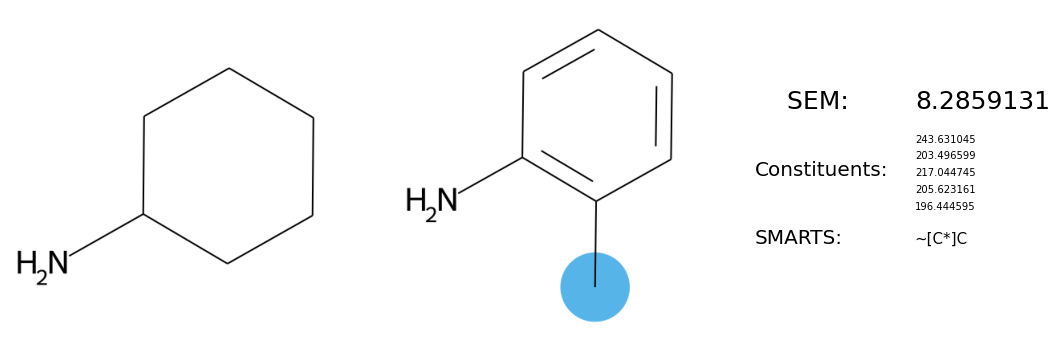

__________________________________________________________________________________________________________
mobley_1728386~mobley_8883511
./QUINTUP/29_dir_dir/finished/job_xec/sim_3/mobley_1728386~mobley_8883511/free
./QUINTUP/29_dir_dir/finished/job_xec/sim_1/mobley_1728386~mobley_8883511/free
./QUINTUP/29_dir_dir/finished/job_xec/sim_5/mobley_1728386~mobley_8883511/free
./QUINTUP/29_dir_dir/finished/job_xec/sim_4/mobley_1728386~mobley_8883511/free
./QUINTUP/29_dir_dir/finished/job_xec/sim_2/mobley_1728386~mobley_8883511/free


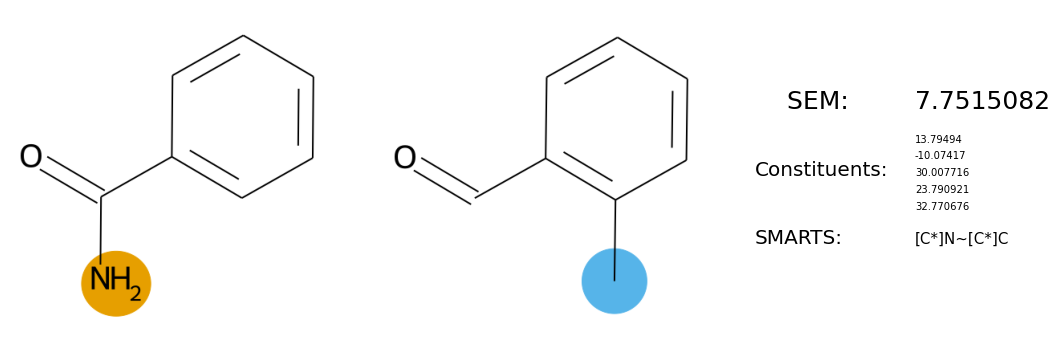

__________________________________________________________________________________________________________
mobley_1036761~mobley_8127829
./QUINTUP/30_dir_dir/finished/job_xbd/sim_7/mobley_1036761~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xbd/sim_9/mobley_1036761~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xbd/sim_8/mobley_1036761~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xbd/sim_6/mobley_1036761~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xbd/sim_10/mobley_1036761~mobley_8127829/free


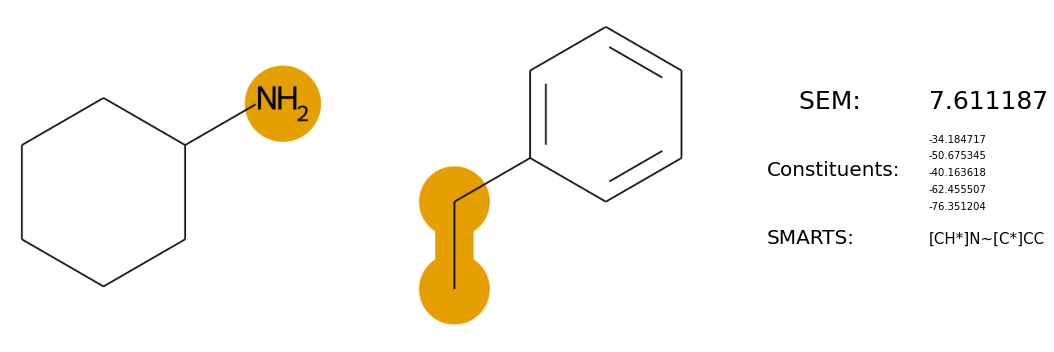

__________________________________________________________________________________________________________
mobley_9942801~mobley_8809190
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_7/mobley_9942801~mobley_8809190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_9/mobley_9942801~mobley_8809190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_8/mobley_9942801~mobley_8809190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_6/mobley_9942801~mobley_8809190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_10/mobley_9942801~mobley_8809190/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_7/mobley_9942801~mobley_8809190/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_9/mobley_9942801~mobley_8809190/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_8/mobley_9942801~mobley_8809190/free
./MGZ_

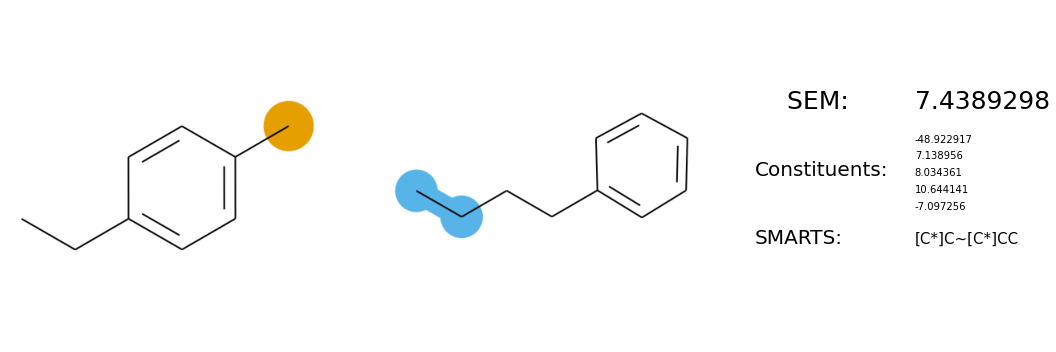

__________________________________________________________________________________________________________
mobley_9478823~mobley_1189457
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_3/mobley_9478823~mobley_1189457/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_1/mobley_9478823~mobley_1189457/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_5/mobley_9478823~mobley_1189457/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_4/mobley_9478823~mobley_1189457/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_2/mobley_9478823~mobley_1189457/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_3/mobley_9478823~mobley_1189457/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_1/mobley_9478823~mobley_1189457/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_5/mobley_9478823~mobley_1189457/free
./MGZ_R

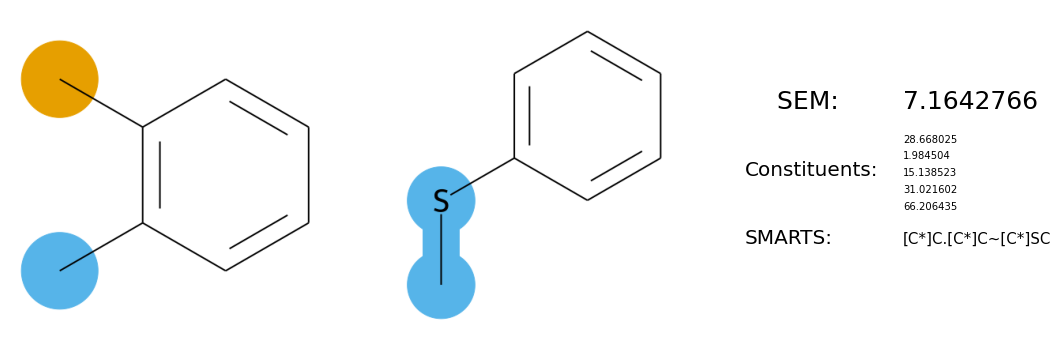

__________________________________________________________________________________________________________
mobley_1755375~mobley_2923700


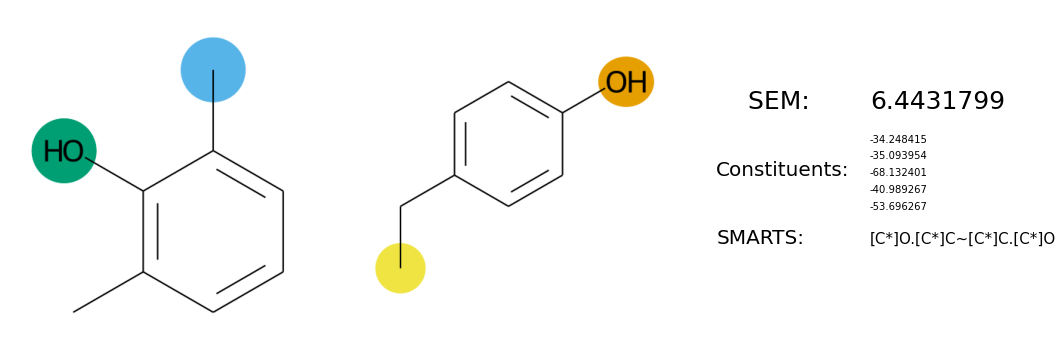

__________________________________________________________________________________________________________
mobley_2043882~mobley_2850833
./QUINTUP/29_dir_dir/finished/job_xiw/sim_14/mobley_2043882~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xiw/sim_13/mobley_2043882~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xiw/sim_12/mobley_2043882~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xiw/sim_15/mobley_2043882~mobley_2850833/free
./QUINTUP/29_dir_dir/finished/job_xiw/sim_11/mobley_2043882~mobley_2850833/free


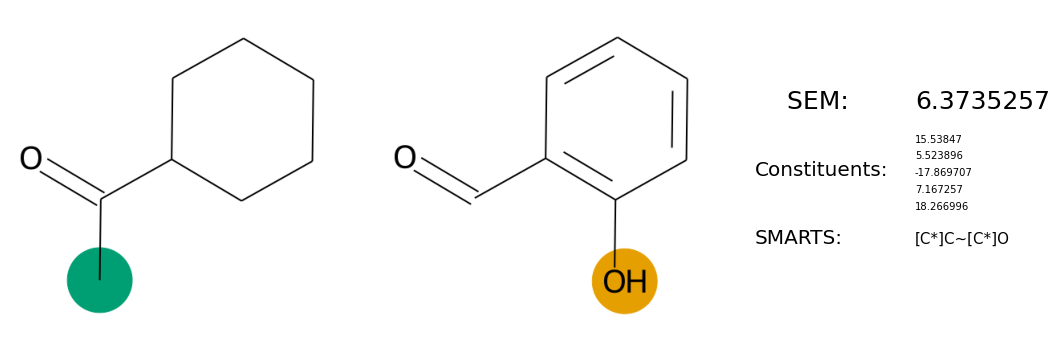

__________________________________________________________________________________________________________
mobley_9478823~mobley_1728386
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_7/mobley_9478823~mobley_1728386/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_9/mobley_9478823~mobley_1728386/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_8/mobley_9478823~mobley_1728386/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_6/mobley_9478823~mobley_1728386/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_10/mobley_9478823~mobley_1728386/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_7/mobley_9478823~mobley_1728386/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_9/mobley_9478823~mobley_1728386/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwq/sim_8/mobley_9478823~mobley_1728386/free
./MGZ_

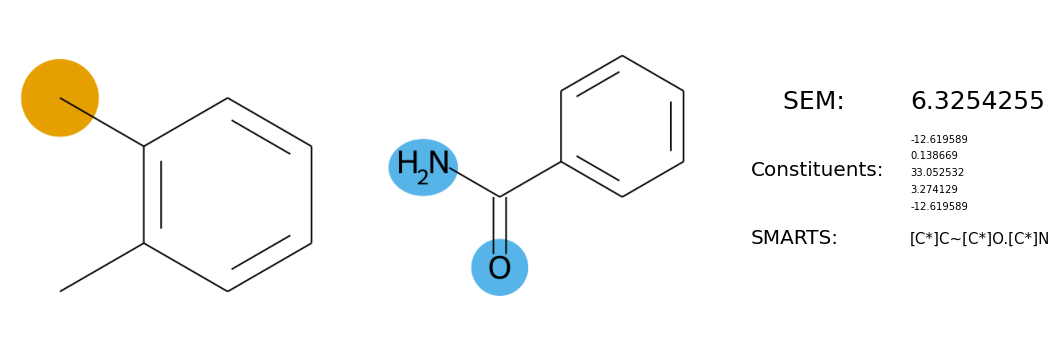

__________________________________________________________________________________________________________
mobley_1424265~mobley_6430250
./QUINTUP/30_dir_dir/finished/job_xfs/sim_18/mobley_1424265~mobley_6430250/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_20/mobley_1424265~mobley_6430250/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_17/mobley_1424265~mobley_6430250/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_19/mobley_1424265~mobley_6430250/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_16/mobley_1424265~mobley_6430250/free


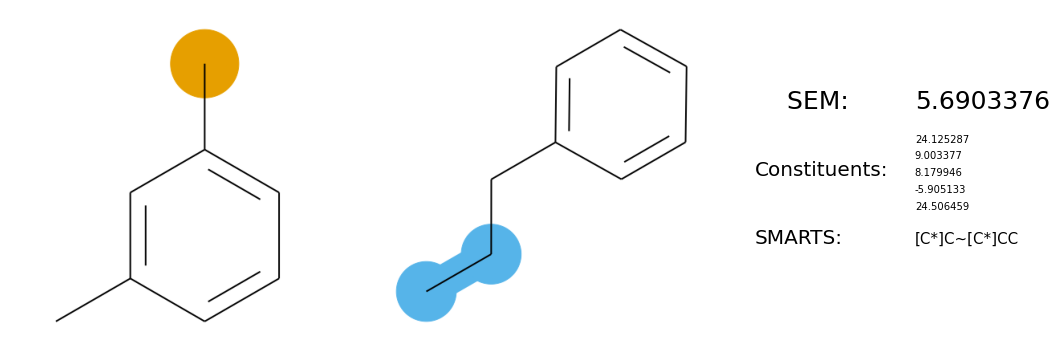

__________________________________________________________________________________________________________
mobley_2043882~mobley_349850
./QUINTUP/29_dir_dir/finished/job_xix/sim_14/mobley_2043882~mobley_349850/free
./QUINTUP/29_dir_dir/finished/job_xix/sim_13/mobley_2043882~mobley_349850/free
./QUINTUP/29_dir_dir/finished/job_xix/sim_12/mobley_2043882~mobley_349850/free
./QUINTUP/29_dir_dir/finished/job_xix/sim_15/mobley_2043882~mobley_349850/free
./QUINTUP/29_dir_dir/finished/job_xix/sim_11/mobley_2043882~mobley_349850/free


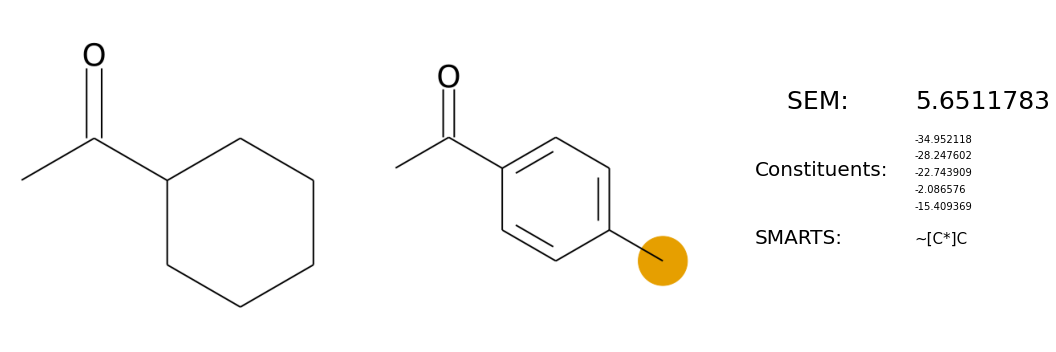

__________________________________________________________________________________________________________
mobley_1046331~mobley_1755375
./QUINTUP/30_dir_dir/finished/job_xbf/sim_7/mobley_1046331~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xbf/sim_9/mobley_1046331~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xbf/sim_8/mobley_1046331~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xbf/sim_6/mobley_1046331~mobley_1755375/free
./QUINTUP/30_dir_dir/finished/job_xbf/sim_10/mobley_1046331~mobley_1755375/free


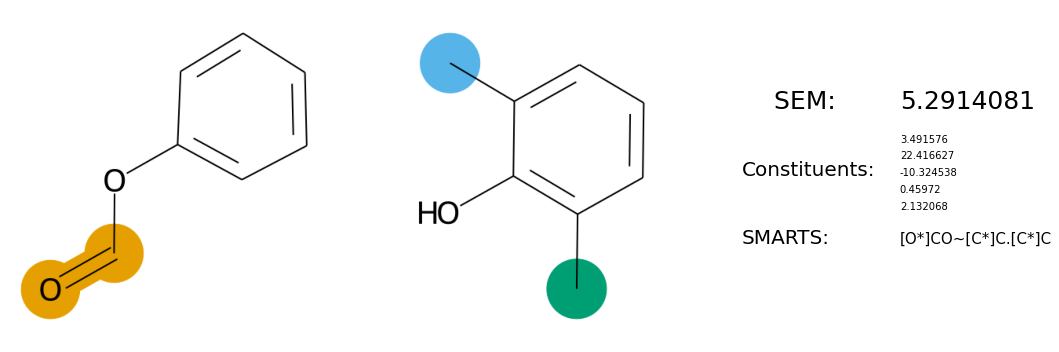

__________________________________________________________________________________________________________
mobley_1571523~mobley_755351
./QUINTUP/30_dir_dir/finished/job_xhd/sim_3/mobley_1571523~mobley_755351/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_1/mobley_1571523~mobley_755351/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_5/mobley_1571523~mobley_755351/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_4/mobley_1571523~mobley_755351/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_2/mobley_1571523~mobley_755351/free


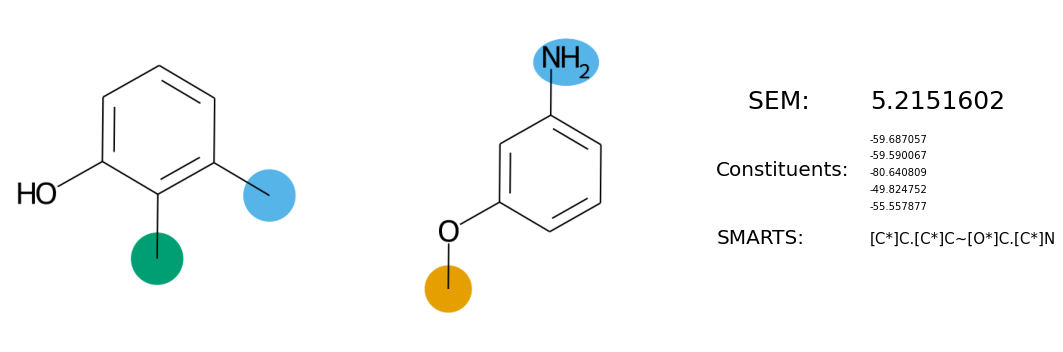

__________________________________________________________________________________________________________
mobley_9507933~mobley_1520842
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_18/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_20/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_17/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_19/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_16/mobley_9507933~mobley_1520842/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_18/mobley_9507933~mobley_1520842/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_20/mobley_9507933~mobley_1520842/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_17/mobley_9507933~mobley_1520842/free

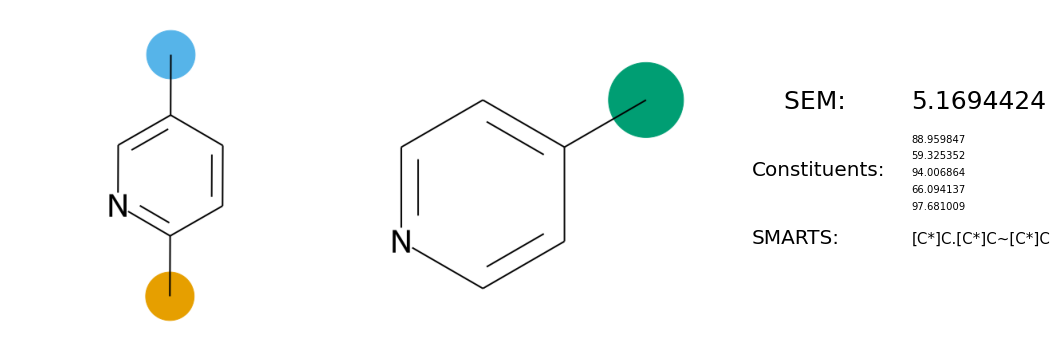

__________________________________________________________________________________________________________
mobley_1520842~mobley_9507933
./QUINTUP/30_dir_dir/finished/job_xgc/sim_7/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_9/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_8/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_6/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_10/mobley_1520842~mobley_9507933/free


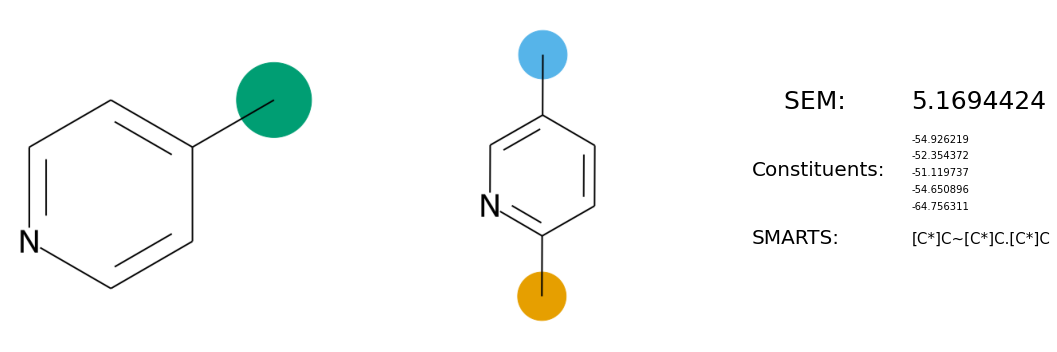

__________________________________________________________________________________________________________
mobley_9653690~mobley_2183616
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_7/mobley_9653690~mobley_2183616/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_9/mobley_9653690~mobley_2183616/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_8/mobley_9653690~mobley_2183616/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_6/mobley_9653690~mobley_2183616/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_10/mobley_9653690~mobley_2183616/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_7/mobley_9653690~mobley_2183616/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_9/mobley_9653690~mobley_2183616/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdye/sim_8/mobley_9653690~mobley_2183616/free
./MGZ_

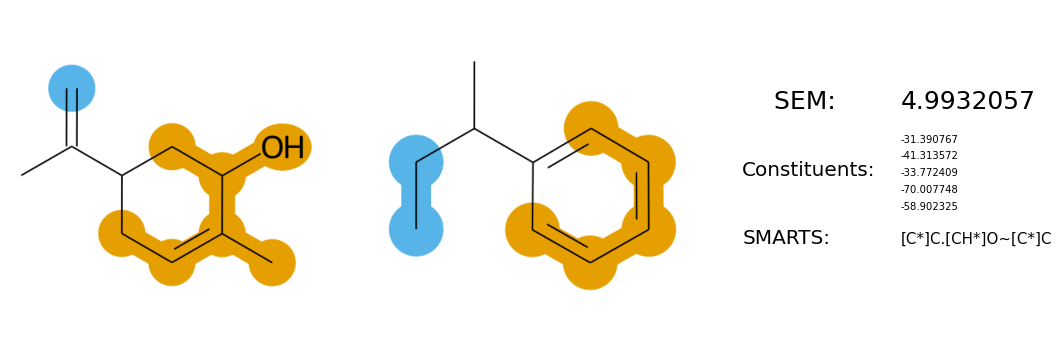

__________________________________________________________________________________________________________
mobley_9942801~mobley_4035953
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_18/mobley_9942801~mobley_4035953/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_20/mobley_9942801~mobley_4035953/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_17/mobley_9942801~mobley_4035953/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_19/mobley_9942801~mobley_4035953/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_16/mobley_9942801~mobley_4035953/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_18/mobley_9942801~mobley_4035953/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_20/mobley_9942801~mobley_4035953/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_17/mobley_9942801~mobley_4035953/free

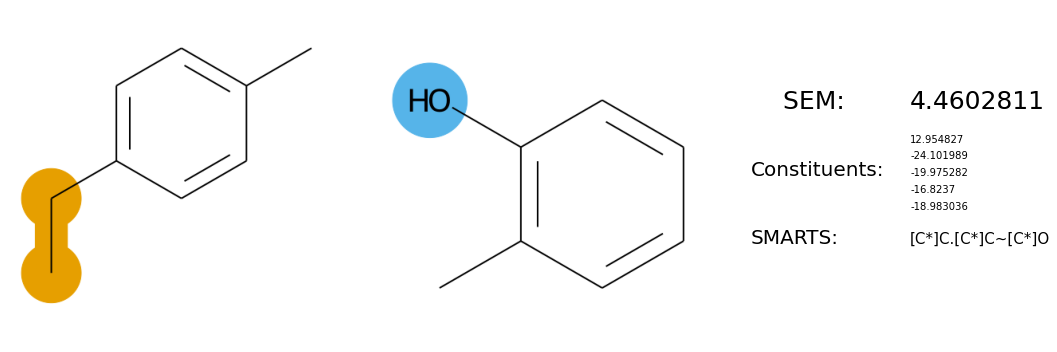

__________________________________________________________________________________________________________
mobley_2043882~mobley_6430250
./QUINTUP/29_dir_dir/finished/job_xiz/sim_3/mobley_2043882~mobley_6430250/free
./QUINTUP/29_dir_dir/finished/job_xiz/sim_1/mobley_2043882~mobley_6430250/free
./QUINTUP/29_dir_dir/finished/job_xiz/sim_5/mobley_2043882~mobley_6430250/free
./QUINTUP/29_dir_dir/finished/job_xiz/sim_4/mobley_2043882~mobley_6430250/free
./QUINTUP/29_dir_dir/finished/job_xiz/sim_2/mobley_2043882~mobley_6430250/free


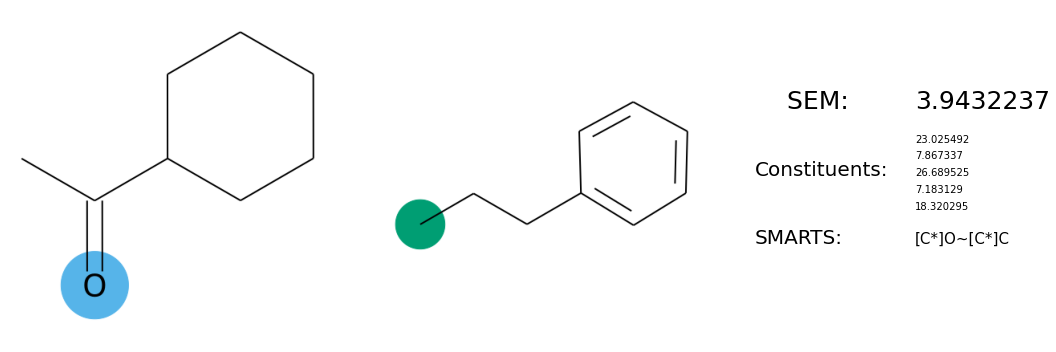

__________________________________________________________________________________________________________
mobley_1160109~mobley_1449384
./QUINTUP/29_dir_dir/finished/job_xbc/sim_18/mobley_1160109~mobley_1449384/free
./QUINTUP/29_dir_dir/finished/job_xbc/sim_20/mobley_1160109~mobley_1449384/free
./QUINTUP/29_dir_dir/finished/job_xbc/sim_17/mobley_1160109~mobley_1449384/free
./QUINTUP/29_dir_dir/finished/job_xbc/sim_19/mobley_1160109~mobley_1449384/free
./QUINTUP/29_dir_dir/finished/job_xbc/sim_16/mobley_1160109~mobley_1449384/free


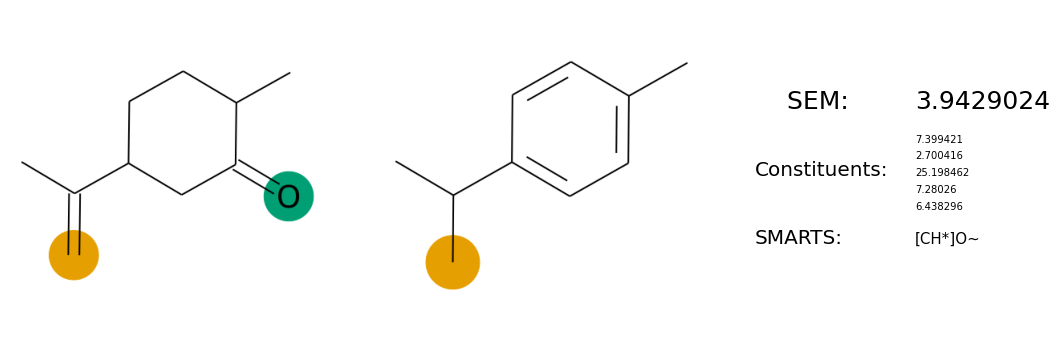

__________________________________________________________________________________________________________
mobley_1952272~mobley_8320545
./QUINTUP/29_dir_dir/finished/job_xia/sim_7/mobley_1952272~mobley_8320545/free
./QUINTUP/29_dir_dir/finished/job_xia/sim_9/mobley_1952272~mobley_8320545/free
./QUINTUP/29_dir_dir/finished/job_xia/sim_8/mobley_1952272~mobley_8320545/free
./QUINTUP/29_dir_dir/finished/job_xia/sim_6/mobley_1952272~mobley_8320545/free
./QUINTUP/29_dir_dir/finished/job_xia/sim_10/mobley_1952272~mobley_8320545/free


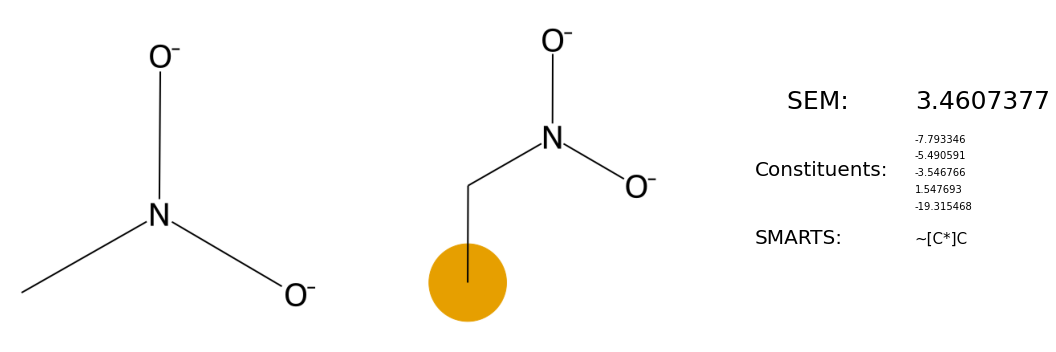

__________________________________________________________________________________________________________
mobley_5571660~mobley_5072416


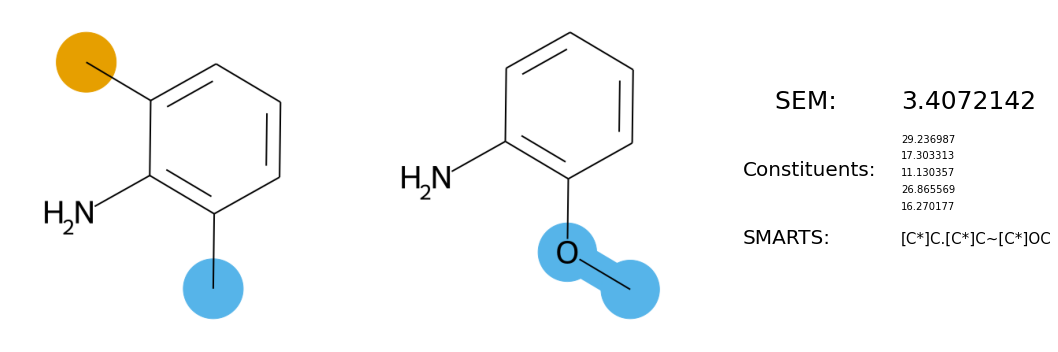

__________________________________________________________________________________________________________
mobley_1424265~mobley_3746675
./QUINTUP/30_dir_dir/finished/job_xfs/sim_3/mobley_1424265~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_1/mobley_1424265~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_5/mobley_1424265~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_4/mobley_1424265~mobley_3746675/free
./QUINTUP/30_dir_dir/finished/job_xfs/sim_2/mobley_1424265~mobley_3746675/free


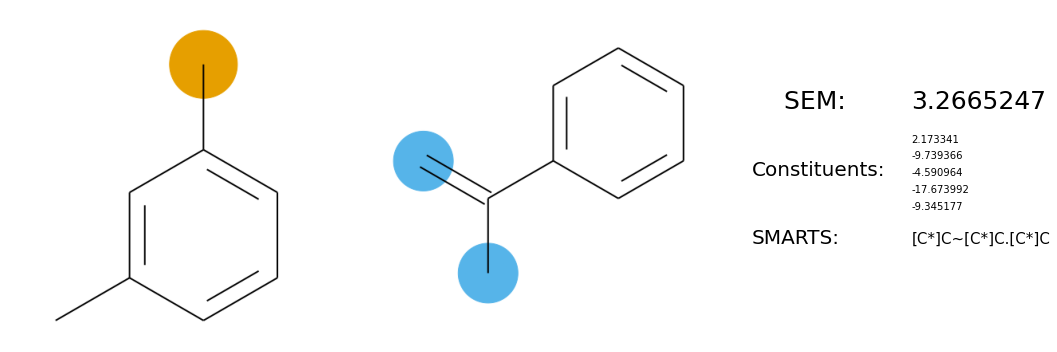

__________________________________________________________________________________________________________
mobley_1036761~mobley_5326154
./QUINTUP/30_dir_dir/finished/job_xbc/sim_7/mobley_1036761~mobley_5326154/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_9/mobley_1036761~mobley_5326154/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_8/mobley_1036761~mobley_5326154/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_6/mobley_1036761~mobley_5326154/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_10/mobley_1036761~mobley_5326154/free


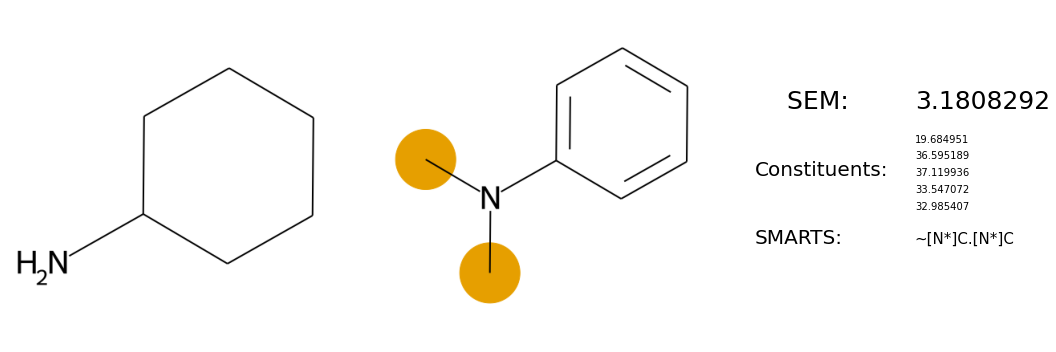

__________________________________________________________________________________________________________
mobley_1520842~mobley_8764620
./QUINTUP/30_dir_dir/finished/job_xgc/sim_3/mobley_1520842~mobley_8764620/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_1/mobley_1520842~mobley_8764620/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_5/mobley_1520842~mobley_8764620/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_4/mobley_1520842~mobley_8764620/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_2/mobley_1520842~mobley_8764620/free


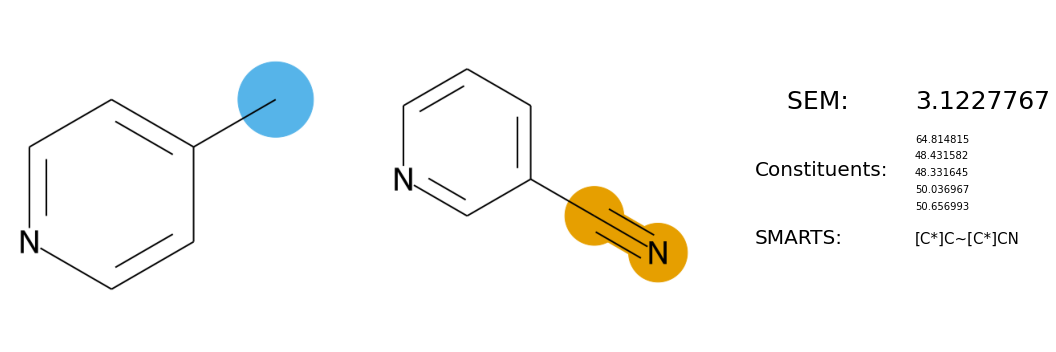

__________________________________________________________________________________________________________
mobley_9478823~mobley_2923700
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_18/mobley_9478823~mobley_2923700/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_20/mobley_9478823~mobley_2923700/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_17/mobley_9478823~mobley_2923700/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_19/mobley_9478823~mobley_2923700/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_16/mobley_9478823~mobley_2923700/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_18/mobley_9478823~mobley_2923700/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_20/mobley_9478823~mobley_2923700/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwt/sim_17/mobley_9478823~mobley_2923700/free

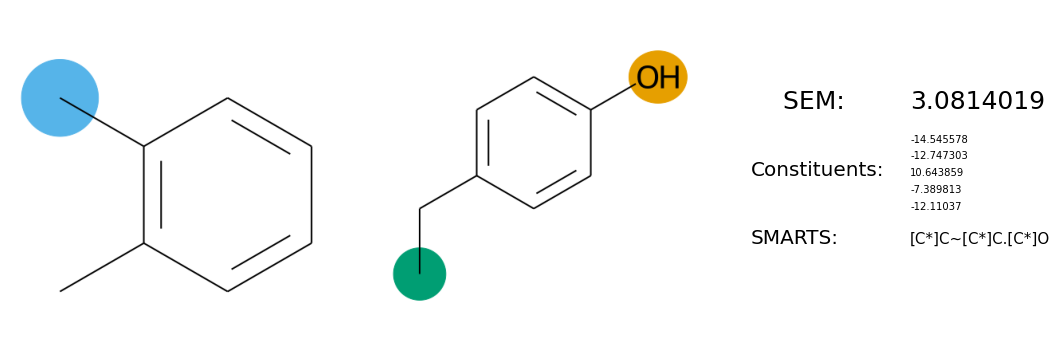

__________________________________________________________________________________________________________
mobley_9942801~mobley_5571660
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_7/mobley_9942801~mobley_5571660/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_9/mobley_9942801~mobley_5571660/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_8/mobley_9942801~mobley_5571660/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_6/mobley_9942801~mobley_5571660/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_10/mobley_9942801~mobley_5571660/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_7/mobley_9942801~mobley_5571660/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_9/mobley_9942801~mobley_5571660/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebj/sim_8/mobley_9942801~mobley_5571660/free
./MGZ_

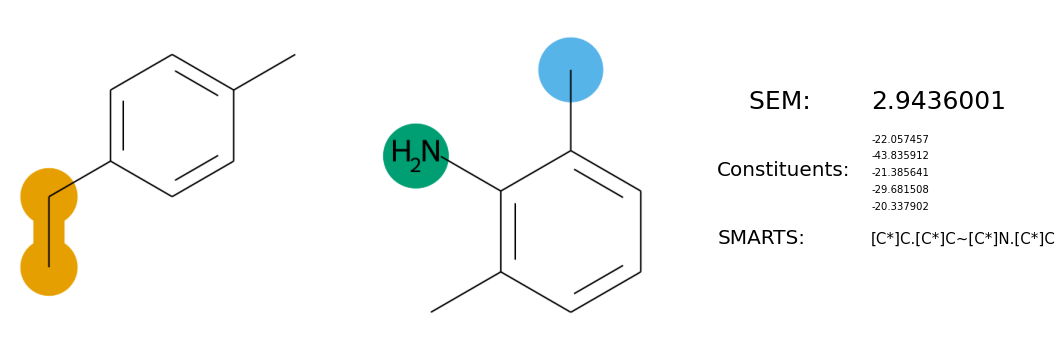

__________________________________________________________________________________________________________
mobley_1571523~mobley_1046331
./QUINTUP/30_dir_dir/finished/job_xgs/sim_3/mobley_1571523~mobley_1046331/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_1/mobley_1571523~mobley_1046331/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_5/mobley_1571523~mobley_1046331/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_4/mobley_1571523~mobley_1046331/free
./QUINTUP/30_dir_dir/finished/job_xgs/sim_2/mobley_1571523~mobley_1046331/free


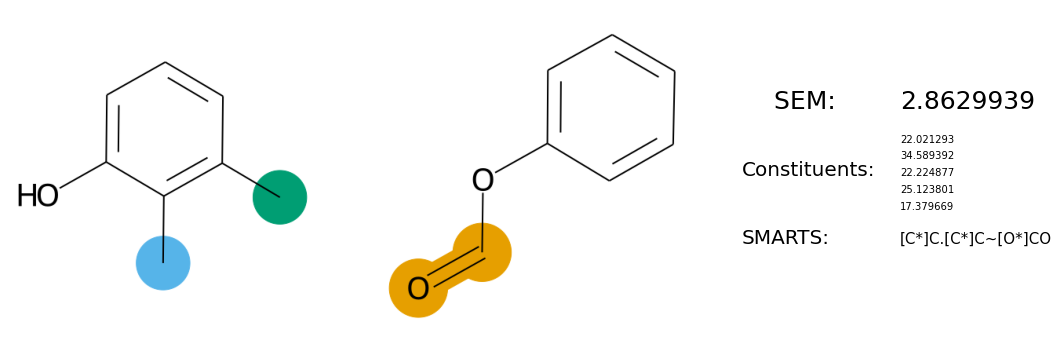

__________________________________________________________________________________________________________
mobley_1046331~mobley_1571523
./QUINTUP/30_dir_dir/finished/job_xbe/sim_18/mobley_1046331~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xbe/sim_20/mobley_1046331~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xbe/sim_17/mobley_1046331~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xbe/sim_19/mobley_1046331~mobley_1571523/free
./QUINTUP/30_dir_dir/finished/job_xbe/sim_16/mobley_1046331~mobley_1571523/free


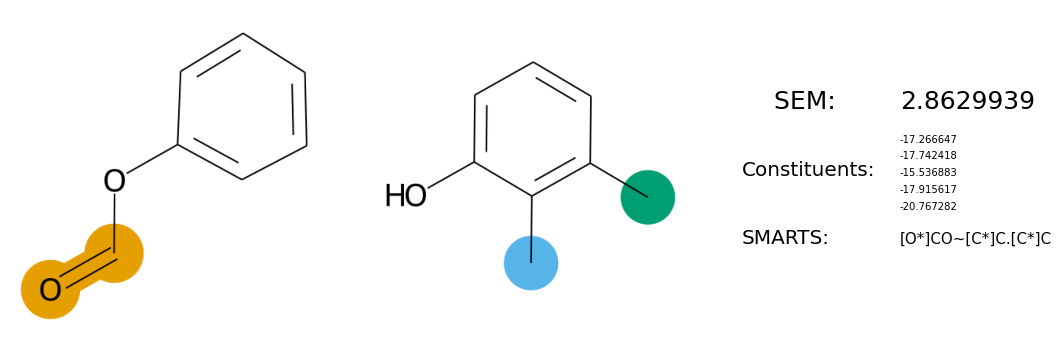

__________________________________________________________________________________________________________
mobley_9942801~mobley_7009711
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_7/mobley_9942801~mobley_7009711/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_9/mobley_9942801~mobley_7009711/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_8/mobley_9942801~mobley_7009711/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_6/mobley_9942801~mobley_7009711/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_10/mobley_9942801~mobley_7009711/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_7/mobley_9942801~mobley_7009711/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_9/mobley_9942801~mobley_7009711/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebk/sim_8/mobley_9942801~mobley_7009711/free
./MGZ_

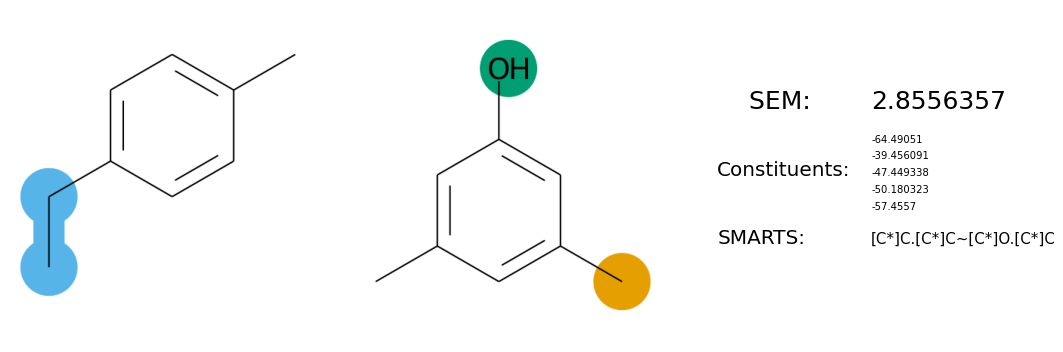

__________________________________________________________________________________________________________
mobley_1571523~mobley_2354112
./QUINTUP/29_dir_dir/finished/job_xcv/sim_7/mobley_1571523~mobley_2354112/free
./QUINTUP/29_dir_dir/finished/job_xcv/sim_9/mobley_1571523~mobley_2354112/free
./QUINTUP/29_dir_dir/finished/job_xcv/sim_8/mobley_1571523~mobley_2354112/free
./QUINTUP/29_dir_dir/finished/job_xcv/sim_6/mobley_1571523~mobley_2354112/free
./QUINTUP/29_dir_dir/finished/job_xcv/sim_10/mobley_1571523~mobley_2354112/free


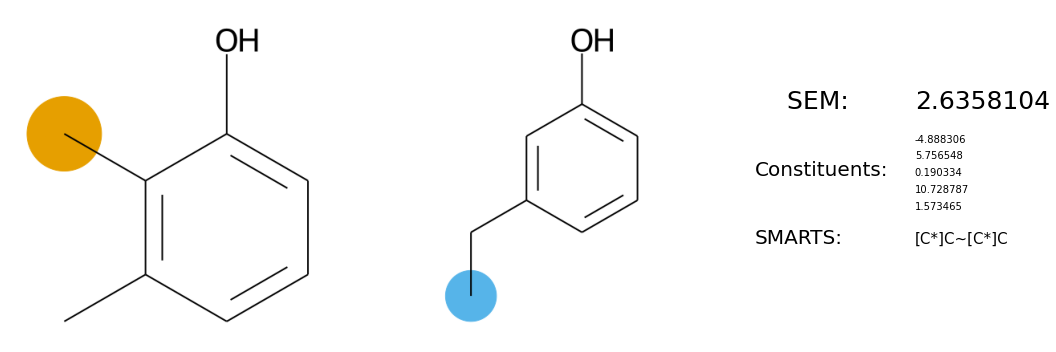

__________________________________________________________________________________________________________
mobley_1571523~mobley_5445548
./QUINTUP/30_dir_dir/finished/job_xgz/sim_18/mobley_1571523~mobley_5445548/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_20/mobley_1571523~mobley_5445548/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_17/mobley_1571523~mobley_5445548/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_19/mobley_1571523~mobley_5445548/free
./QUINTUP/30_dir_dir/finished/job_xgz/sim_16/mobley_1571523~mobley_5445548/free


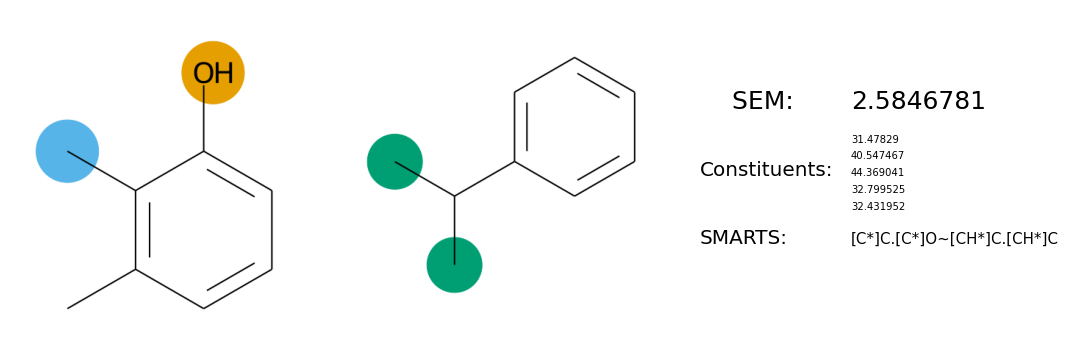

__________________________________________________________________________________________________________
mobley_1571523~mobley_3682850
./QUINTUP/30_dir_dir/finished/job_xgx/sim_18/mobley_1571523~mobley_3682850/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_20/mobley_1571523~mobley_3682850/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_17/mobley_1571523~mobley_3682850/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_19/mobley_1571523~mobley_3682850/free
./QUINTUP/30_dir_dir/finished/job_xgx/sim_16/mobley_1571523~mobley_3682850/free


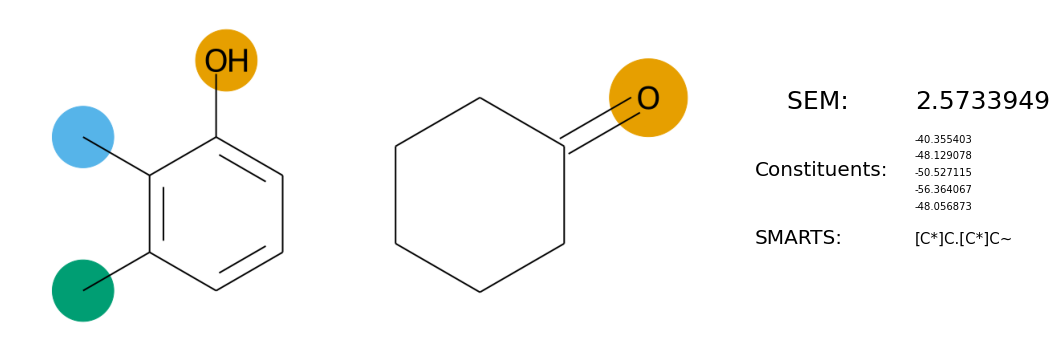

__________________________________________________________________________________________________________
mobley_1424265~mobley_1036761
./QUINTUP/30_dir_dir/finished/job_xfp/sim_3/mobley_1424265~mobley_1036761/free
./QUINTUP/30_dir_dir/finished/job_xfp/sim_1/mobley_1424265~mobley_1036761/free
./QUINTUP/30_dir_dir/finished/job_xfp/sim_5/mobley_1424265~mobley_1036761/free
./QUINTUP/30_dir_dir/finished/job_xfp/sim_4/mobley_1424265~mobley_1036761/free
./QUINTUP/30_dir_dir/finished/job_xfp/sim_2/mobley_1424265~mobley_1036761/free


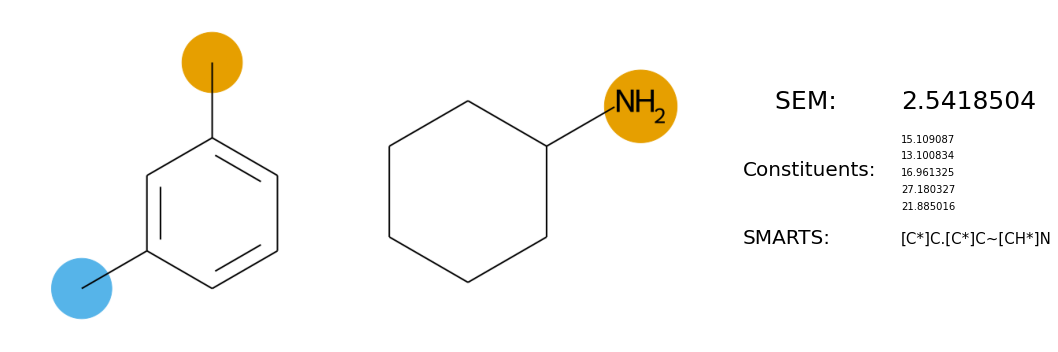

__________________________________________________________________________________________________________
mobley_1036761~mobley_5311804
./QUINTUP/30_dir_dir/finished/job_xbc/sim_3/mobley_1036761~mobley_5311804/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_1/mobley_1036761~mobley_5311804/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_5/mobley_1036761~mobley_5311804/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_4/mobley_1036761~mobley_5311804/free
./QUINTUP/30_dir_dir/finished/job_xbc/sim_2/mobley_1036761~mobley_5311804/free


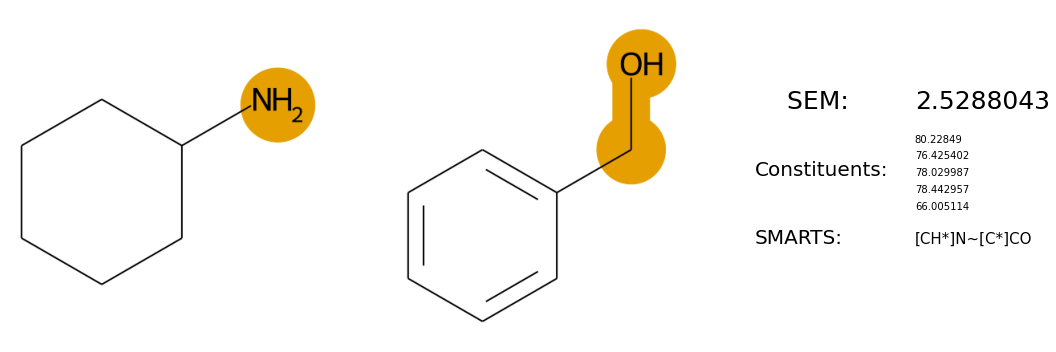

__________________________________________________________________________________________________________
mobley_1571523~mobley_7010316
./QUINTUP/30_dir_dir/finished/job_xhb/sim_14/mobley_1571523~mobley_7010316/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_13/mobley_1571523~mobley_7010316/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_12/mobley_1571523~mobley_7010316/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_15/mobley_1571523~mobley_7010316/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_11/mobley_1571523~mobley_7010316/free


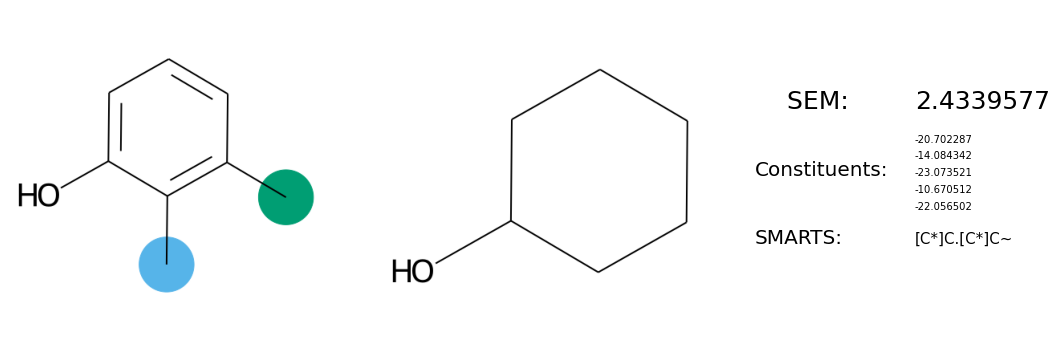

__________________________________________________________________________________________________________
mobley_9507933~mobley_1520842
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_18/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_20/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_17/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_19/mobley_9507933~mobley_1520842/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_16/mobley_9507933~mobley_1520842/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_18/mobley_9507933~mobley_1520842/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_20/mobley_9507933~mobley_1520842/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxc/sim_17/mobley_9507933~mobley_1520842/free

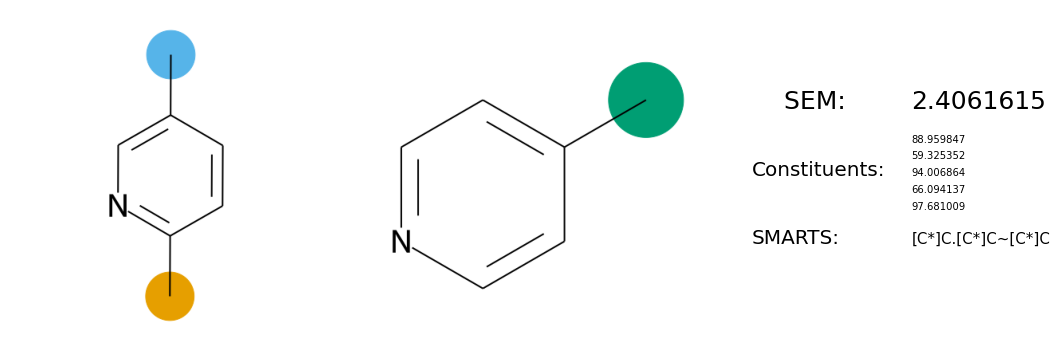

__________________________________________________________________________________________________________
mobley_1520842~mobley_9507933
./QUINTUP/30_dir_dir/finished/job_xgc/sim_7/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_9/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_8/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_6/mobley_1520842~mobley_9507933/free
./QUINTUP/30_dir_dir/finished/job_xgc/sim_10/mobley_1520842~mobley_9507933/free


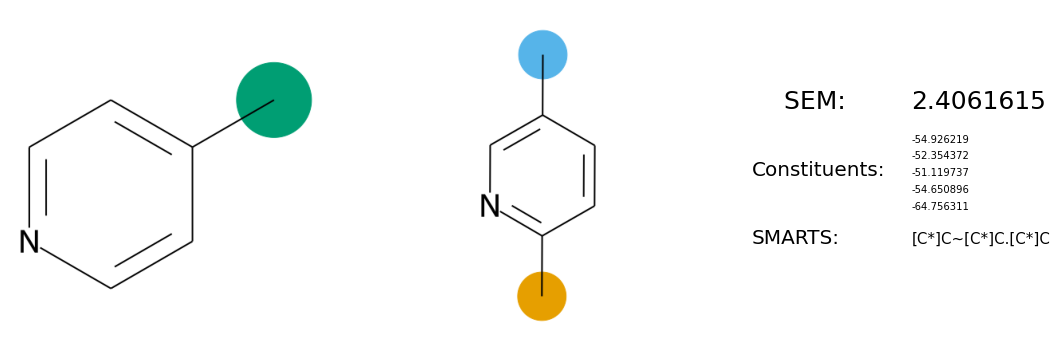

__________________________________________________________________________________________________________
mobley_5518547~mobley_7497999


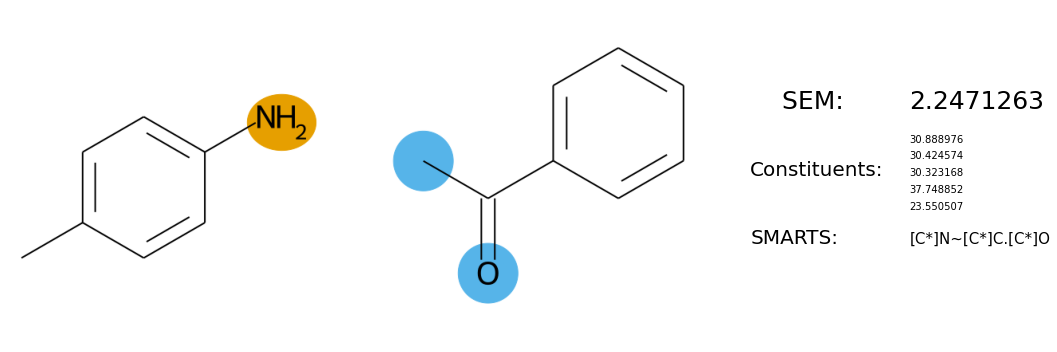

__________________________________________________________________________________________________________
mobley_3682850~mobley_755351


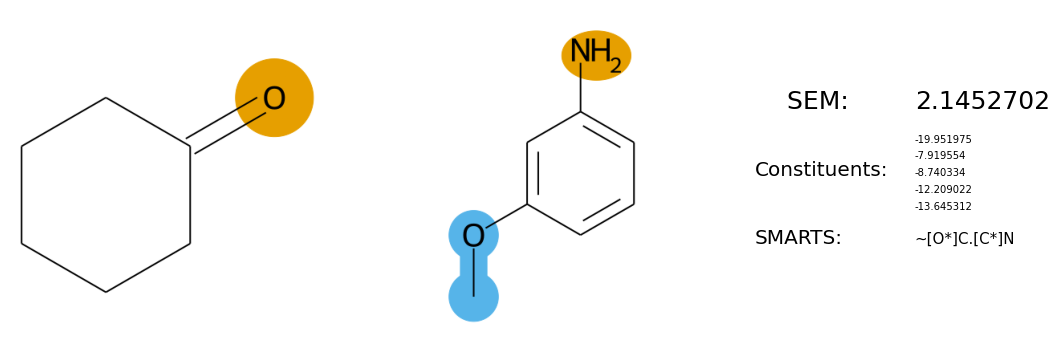

__________________________________________________________________________________________________________
mobley_1571523~mobley_9139060
./QUINTUP/30_dir_dir/finished/job_xhe/sim_18/mobley_1571523~mobley_9139060/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_20/mobley_1571523~mobley_9139060/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_17/mobley_1571523~mobley_9139060/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_19/mobley_1571523~mobley_9139060/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_16/mobley_1571523~mobley_9139060/free


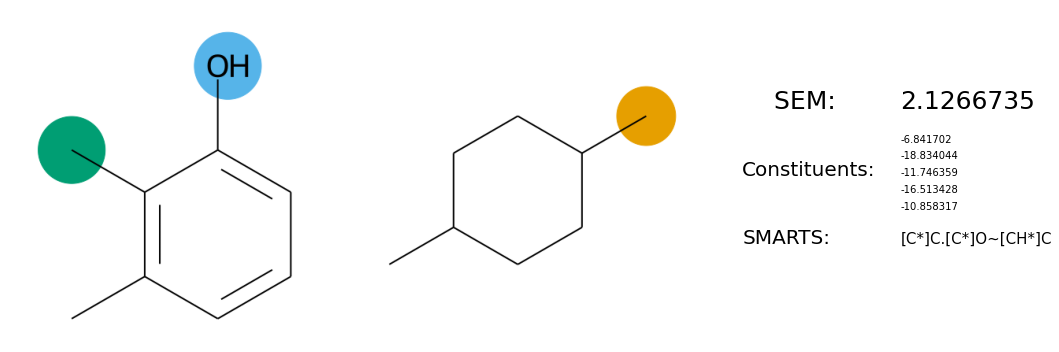

__________________________________________________________________________________________________________
mobley_1571523~mobley_6571751
./QUINTUP/30_dir_dir/finished/job_xhb/sim_7/mobley_1571523~mobley_6571751/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_9/mobley_1571523~mobley_6571751/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_8/mobley_1571523~mobley_6571751/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_6/mobley_1571523~mobley_6571751/free
./QUINTUP/30_dir_dir/finished/job_xhb/sim_10/mobley_1571523~mobley_6571751/free


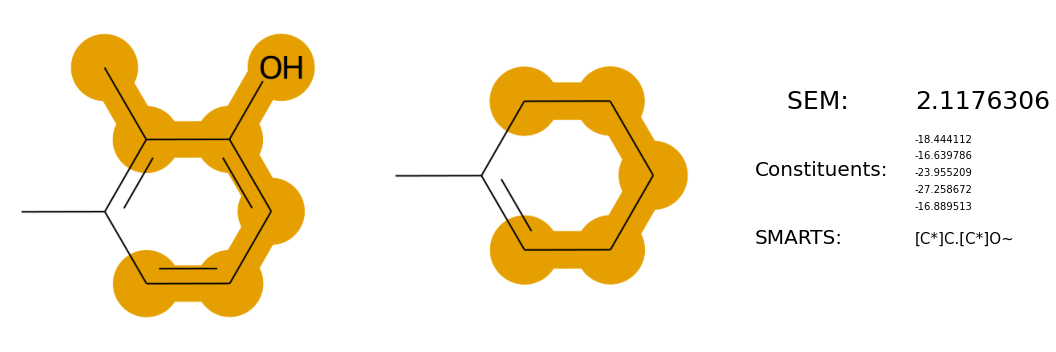

__________________________________________________________________________________________________________
mobley_1520842~mobley_4884177
./QUINTUP/30_dir_dir/finished/job_xga/sim_18/mobley_1520842~mobley_4884177/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_20/mobley_1520842~mobley_4884177/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_17/mobley_1520842~mobley_4884177/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_19/mobley_1520842~mobley_4884177/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_16/mobley_1520842~mobley_4884177/free


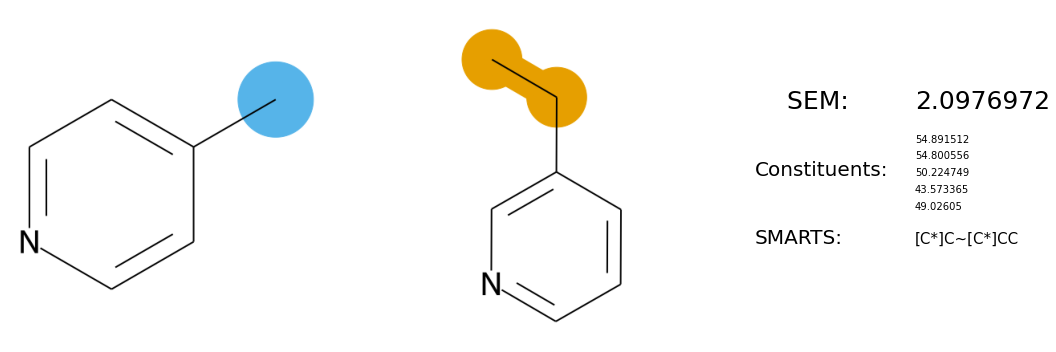

__________________________________________________________________________________________________________
mobley_1571523~mobley_7497999
./QUINTUP/30_dir_dir/finished/job_xhc/sim_18/mobley_1571523~mobley_7497999/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_20/mobley_1571523~mobley_7497999/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_17/mobley_1571523~mobley_7497999/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_19/mobley_1571523~mobley_7497999/free
./QUINTUP/30_dir_dir/finished/job_xhc/sim_16/mobley_1571523~mobley_7497999/free


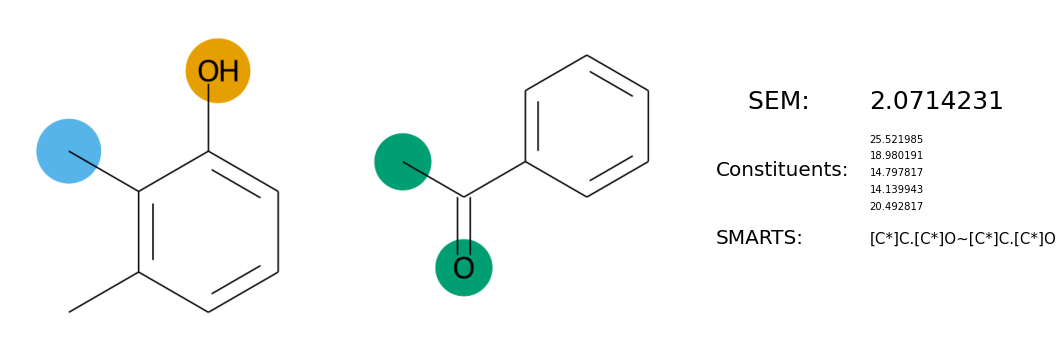

__________________________________________________________________________________________________________
mobley_1728386~mobley_2123854
./QUINTUP/29_dir_dir/finished/job_xdz/sim_14/mobley_1728386~mobley_2123854/free
./QUINTUP/29_dir_dir/finished/job_xdz/sim_13/mobley_1728386~mobley_2123854/free
./QUINTUP/29_dir_dir/finished/job_xdz/sim_12/mobley_1728386~mobley_2123854/free
./QUINTUP/29_dir_dir/finished/job_xdz/sim_15/mobley_1728386~mobley_2123854/free
./QUINTUP/29_dir_dir/finished/job_xdz/sim_11/mobley_1728386~mobley_2123854/free


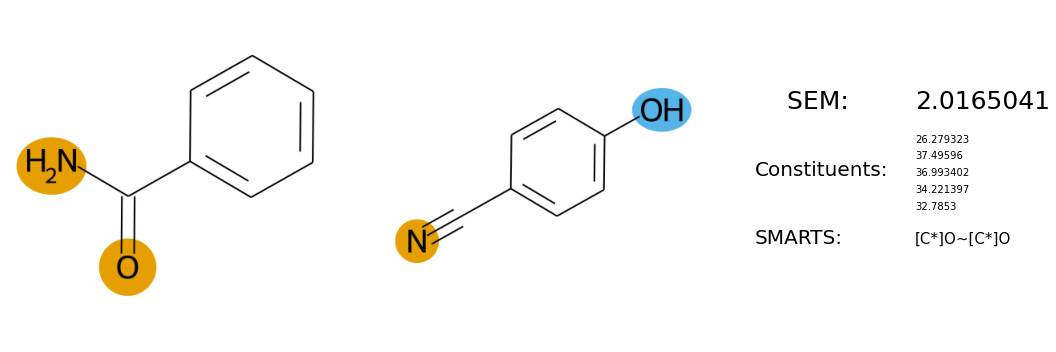

__________________________________________________________________________________________________________
mobley_1424265~mobley_1858644
./QUINTUP/30_dir_dir/finished/job_xfq/sim_3/mobley_1424265~mobley_1858644/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_1/mobley_1424265~mobley_1858644/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_5/mobley_1424265~mobley_1858644/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_4/mobley_1424265~mobley_1858644/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_2/mobley_1424265~mobley_1858644/free


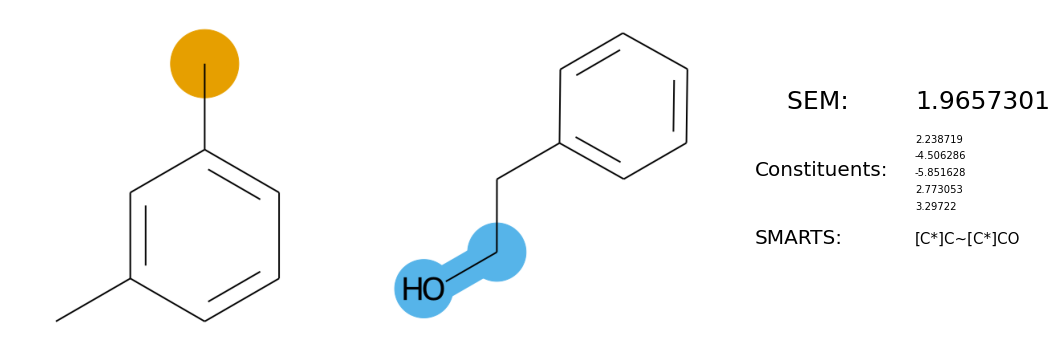

__________________________________________________________________________________________________________
mobley_1520842~mobley_4584540
./QUINTUP/30_dir_dir/finished/job_xga/sim_14/mobley_1520842~mobley_4584540/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_13/mobley_1520842~mobley_4584540/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_12/mobley_1520842~mobley_4584540/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_15/mobley_1520842~mobley_4584540/free
./QUINTUP/30_dir_dir/finished/job_xga/sim_11/mobley_1520842~mobley_4584540/free


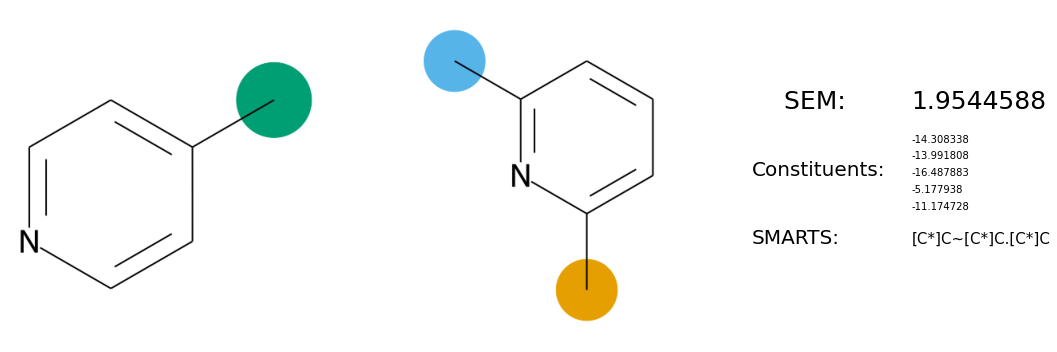

__________________________________________________________________________________________________________
mobley_1571523~mobley_5917842
./QUINTUP/30_dir_dir/finished/job_xha/sim_14/mobley_1571523~mobley_5917842/free
./QUINTUP/30_dir_dir/finished/job_xha/sim_13/mobley_1571523~mobley_5917842/free
./QUINTUP/30_dir_dir/finished/job_xha/sim_12/mobley_1571523~mobley_5917842/free
./QUINTUP/30_dir_dir/finished/job_xha/sim_15/mobley_1571523~mobley_5917842/free
./QUINTUP/30_dir_dir/finished/job_xha/sim_11/mobley_1571523~mobley_5917842/free


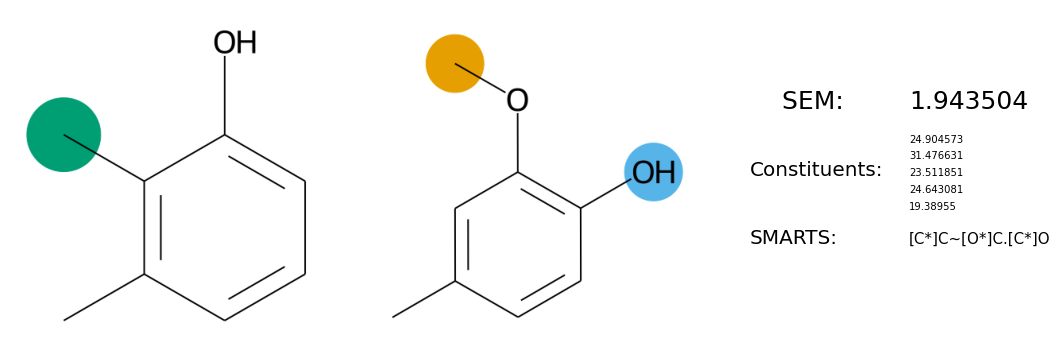

__________________________________________________________________________________________________________
mobley_1046331~mobley_4035953
./QUINTUP/30_dir_dir/finished/job_xbi/sim_14/mobley_1046331~mobley_4035953/free
./QUINTUP/30_dir_dir/finished/job_xbi/sim_13/mobley_1046331~mobley_4035953/free
./QUINTUP/30_dir_dir/finished/job_xbi/sim_12/mobley_1046331~mobley_4035953/free
./QUINTUP/30_dir_dir/finished/job_xbi/sim_15/mobley_1046331~mobley_4035953/free
./QUINTUP/30_dir_dir/finished/job_xbi/sim_11/mobley_1046331~mobley_4035953/free


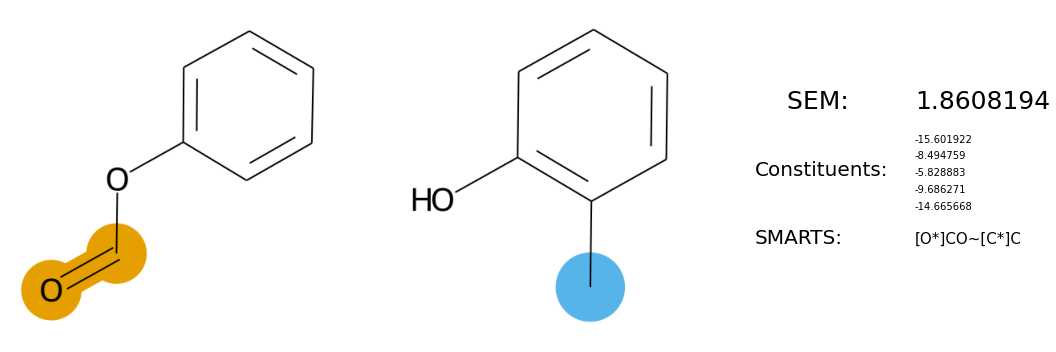

__________________________________________________________________________________________________________
mobley_5311804~mobley_4553008


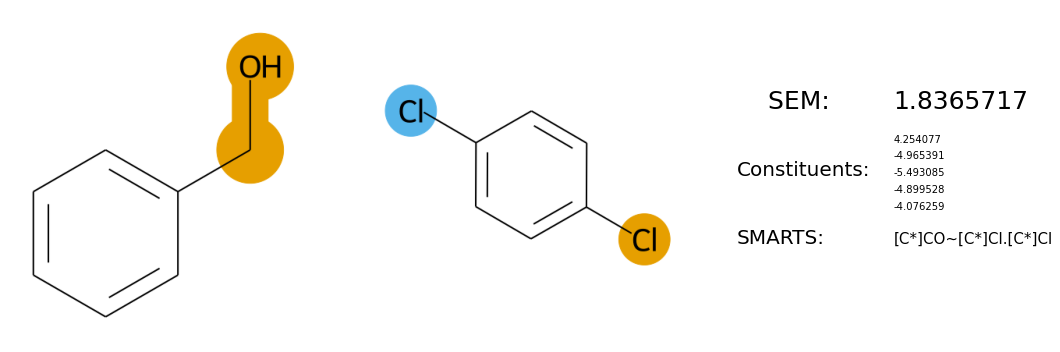

__________________________________________________________________________________________________________
mobley_1424265~mobley_3040612
./QUINTUP/30_dir_dir/finished/job_xfq/sim_18/mobley_1424265~mobley_3040612/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_20/mobley_1424265~mobley_3040612/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_17/mobley_1424265~mobley_3040612/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_19/mobley_1424265~mobley_3040612/free
./QUINTUP/30_dir_dir/finished/job_xfq/sim_16/mobley_1424265~mobley_3040612/free


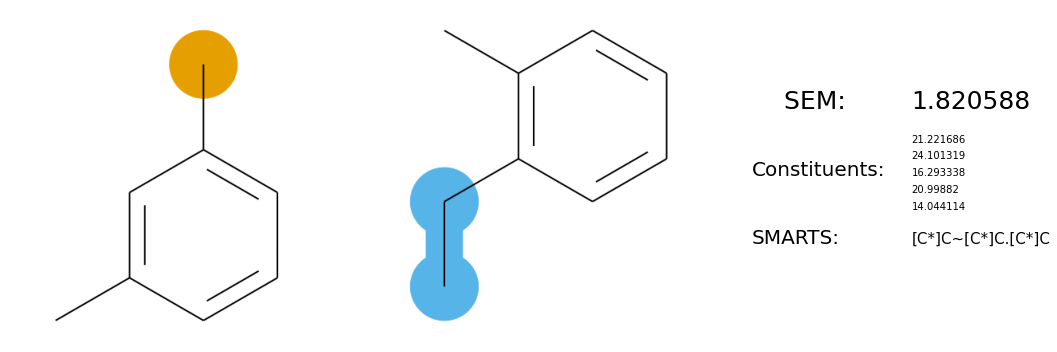

__________________________________________________________________________________________________________
mobley_1571523~mobley_9100956
./QUINTUP/30_dir_dir/finished/job_xhe/sim_14/mobley_1571523~mobley_9100956/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_13/mobley_1571523~mobley_9100956/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_12/mobley_1571523~mobley_9100956/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_15/mobley_1571523~mobley_9100956/free
./QUINTUP/30_dir_dir/finished/job_xhe/sim_11/mobley_1571523~mobley_9100956/free


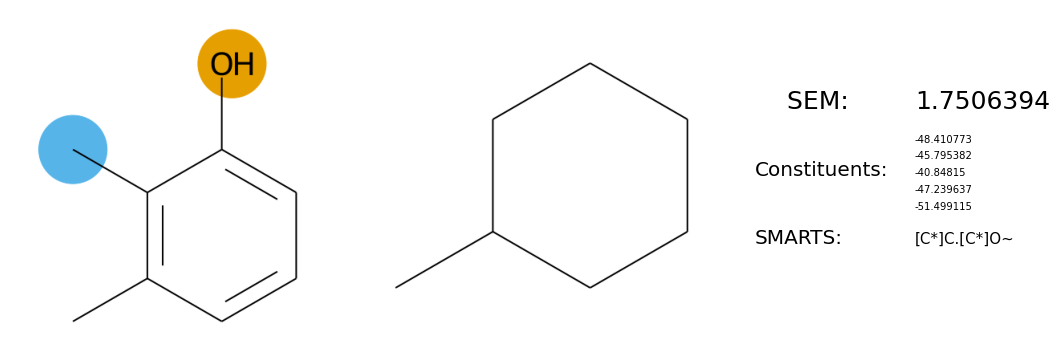

__________________________________________________________________________________________________________
mobley_1571523~mobley_2923700
./QUINTUP/30_dir_dir/finished/job_xgw/sim_14/mobley_1571523~mobley_2923700/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_13/mobley_1571523~mobley_2923700/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_12/mobley_1571523~mobley_2923700/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_15/mobley_1571523~mobley_2923700/free
./QUINTUP/30_dir_dir/finished/job_xgw/sim_11/mobley_1571523~mobley_2923700/free


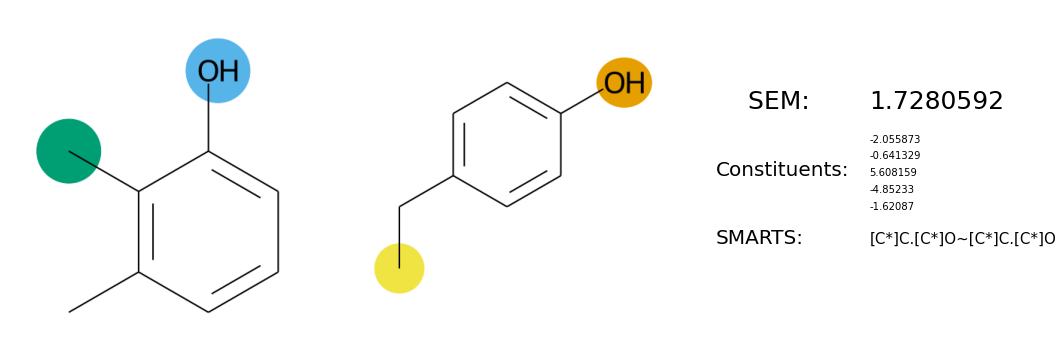

__________________________________________________________________________________________________________
mobley_1571523~mobley_2457863
./QUINTUP/30_dir_dir/finished/job_xgv/sim_14/mobley_1571523~mobley_2457863/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_13/mobley_1571523~mobley_2457863/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_12/mobley_1571523~mobley_2457863/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_15/mobley_1571523~mobley_2457863/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_11/mobley_1571523~mobley_2457863/free


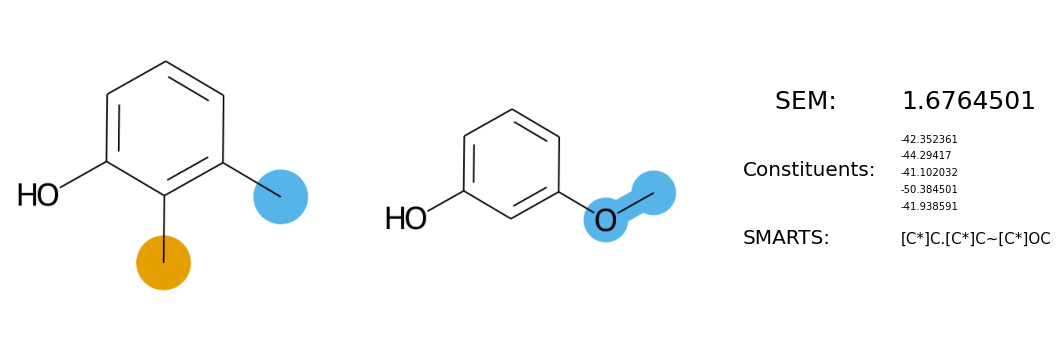

__________________________________________________________________________________________________________
mobley_1036761~mobley_2484519
./QUINTUP/30_dir_dir/finished/job_xaz/sim_3/mobley_1036761~mobley_2484519/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_1/mobley_1036761~mobley_2484519/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_5/mobley_1036761~mobley_2484519/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_4/mobley_1036761~mobley_2484519/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_2/mobley_1036761~mobley_2484519/free


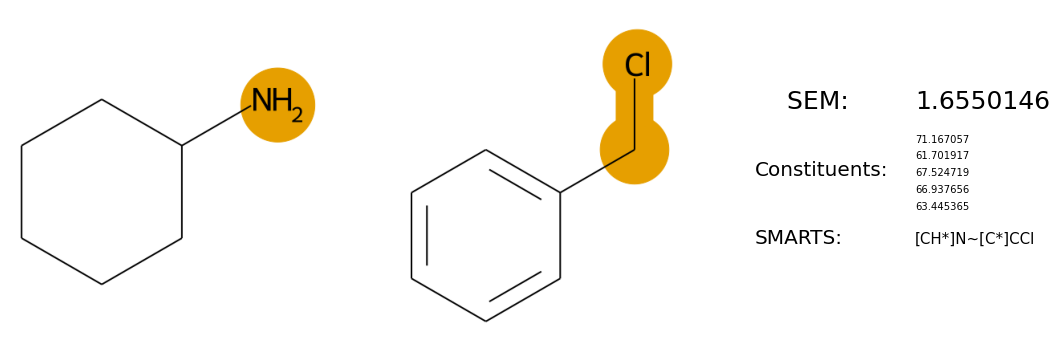

__________________________________________________________________________________________________________
mobley_1571523~mobley_4218209
./QUINTUP/30_dir_dir/finished/job_xgy/sim_18/mobley_1571523~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_20/mobley_1571523~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_17/mobley_1571523~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_19/mobley_1571523~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xgy/sim_16/mobley_1571523~mobley_4218209/free


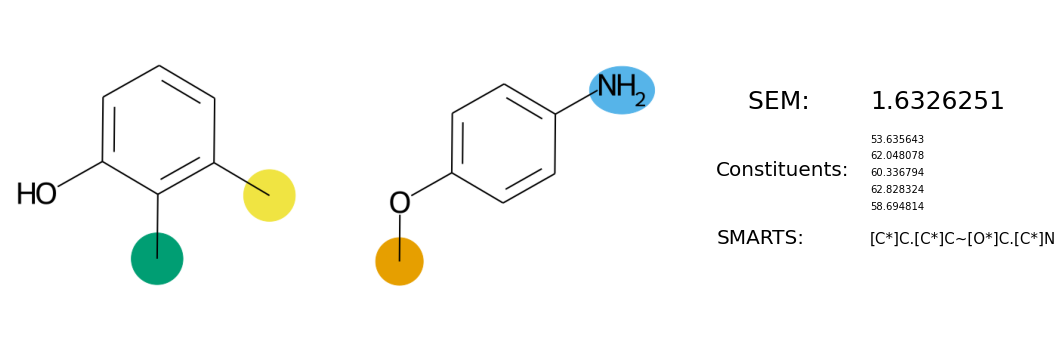

__________________________________________________________________________________________________________
mobley_9671033~mobley_1235151
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_3/mobley_9671033~mobley_1235151/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_1/mobley_9671033~mobley_1235151/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_5/mobley_9671033~mobley_1235151/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_4/mobley_9671033~mobley_1235151/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_2/mobley_9671033~mobley_1235151/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_3/mobley_9671033~mobley_1235151/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_1/mobley_9671033~mobley_1235151/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyh/sim_5/mobley_9671033~mobley_1235151/free
./MGZ_R

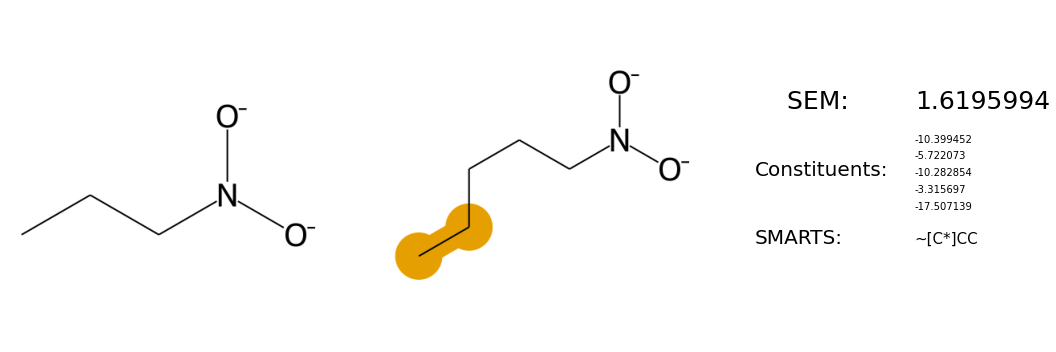

__________________________________________________________________________________________________________
mobley_1019269~mobley_8260524
./QUINTUP/30_dir_dir/finished/job_xat/sim_18/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_20/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_17/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_19/mobley_1019269~mobley_8260524/free
./QUINTUP/30_dir_dir/finished/job_xat/sim_16/mobley_1019269~mobley_8260524/free


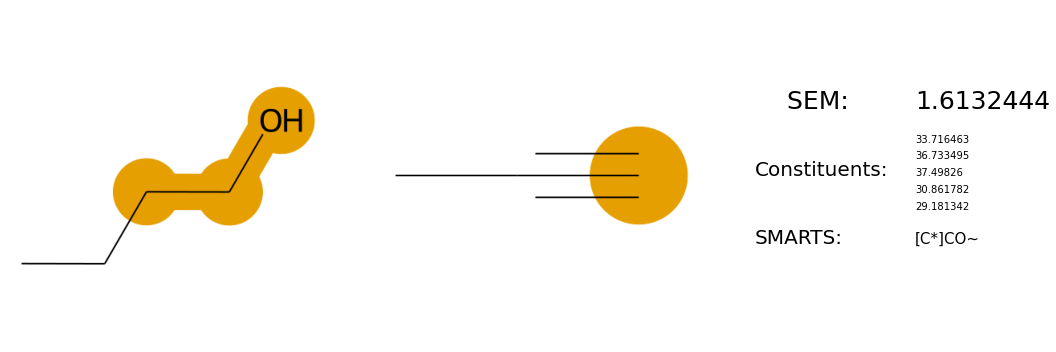

__________________________________________________________________________________________________________
mobley_9942801~mobley_3452749
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_7/mobley_9942801~mobley_3452749/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_9/mobley_9942801~mobley_3452749/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_8/mobley_9942801~mobley_3452749/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_6/mobley_9942801~mobley_3452749/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_10/mobley_9942801~mobley_3452749/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_7/mobley_9942801~mobley_3452749/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_9/mobley_9942801~mobley_3452749/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebg/sim_8/mobley_9942801~mobley_3452749/free
./MGZ_

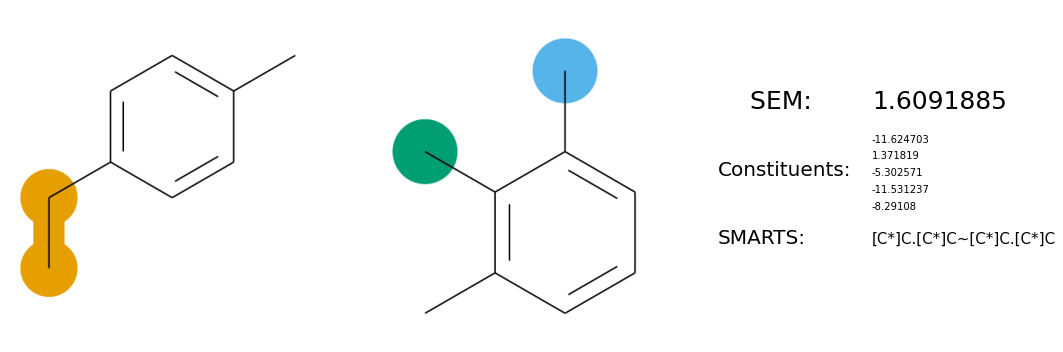

__________________________________________________________________________________________________________
mobley_1036761~mobley_7774695
./QUINTUP/29_dir_dir/finished/job_xao/sim_3/mobley_1036761~mobley_7774695/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_1/mobley_1036761~mobley_7774695/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_5/mobley_1036761~mobley_7774695/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_4/mobley_1036761~mobley_7774695/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_2/mobley_1036761~mobley_7774695/free


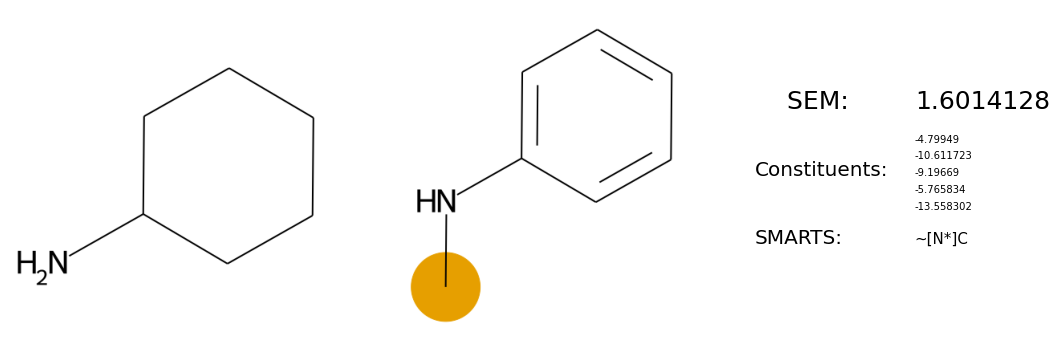

__________________________________________________________________________________________________________
mobley_1717215~mobley_6917738
./QUINTUP/30_dir_dir/finished/job_xjb/sim_18/mobley_1717215~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xjb/sim_20/mobley_1717215~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xjb/sim_17/mobley_1717215~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xjb/sim_19/mobley_1717215~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xjb/sim_16/mobley_1717215~mobley_6917738/free


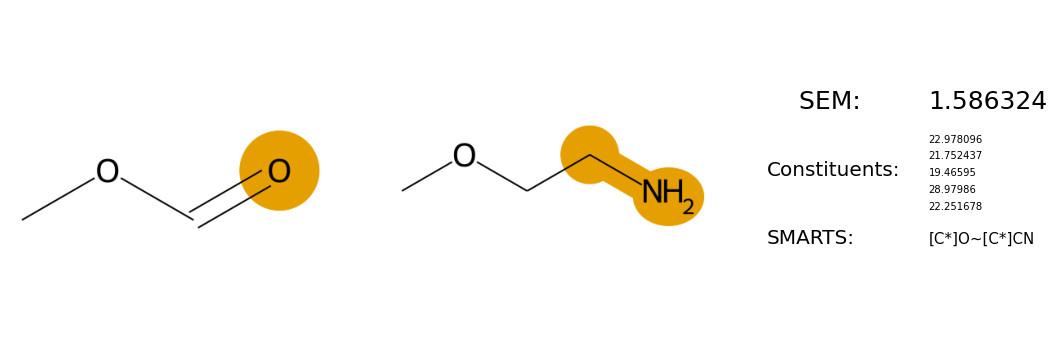

__________________________________________________________________________________________________________
mobley_1019269~mobley_7326982
./QUINTUP/30_dir_dir/finished/job_xas/sim_14/mobley_1019269~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xas/sim_13/mobley_1019269~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xas/sim_12/mobley_1019269~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xas/sim_15/mobley_1019269~mobley_7326982/free
./QUINTUP/30_dir_dir/finished/job_xas/sim_11/mobley_1019269~mobley_7326982/free


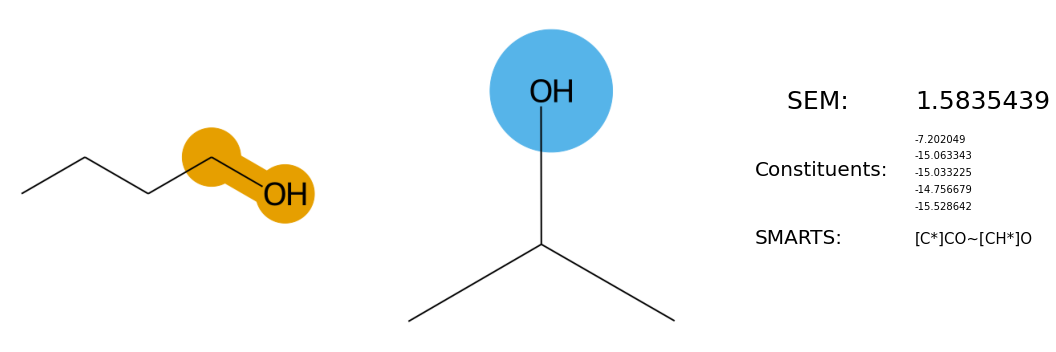

__________________________________________________________________________________________________________
mobley_7009711~mobley_2923700


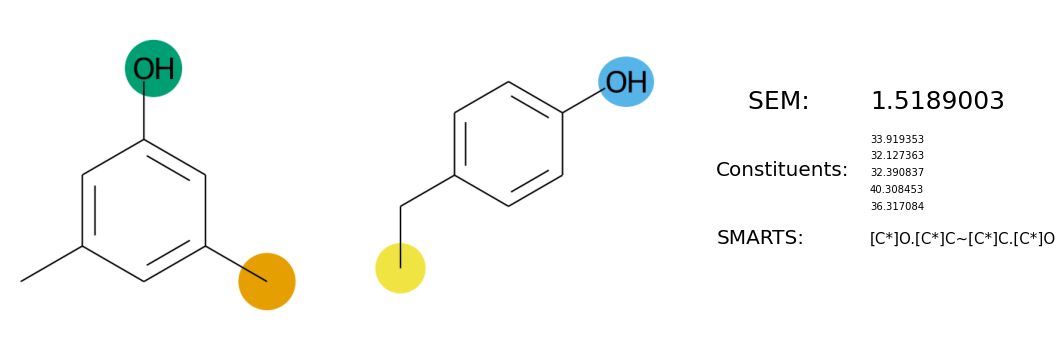

__________________________________________________________________________________________________________
mobley_1036761~mobley_1733799
./QUINTUP/30_dir_dir/finished/job_xay/sim_3/mobley_1036761~mobley_1733799/free
./QUINTUP/30_dir_dir/finished/job_xay/sim_1/mobley_1036761~mobley_1733799/free
./QUINTUP/30_dir_dir/finished/job_xay/sim_5/mobley_1036761~mobley_1733799/free
./QUINTUP/30_dir_dir/finished/job_xay/sim_4/mobley_1036761~mobley_1733799/free
./QUINTUP/30_dir_dir/finished/job_xay/sim_2/mobley_1036761~mobley_1733799/free


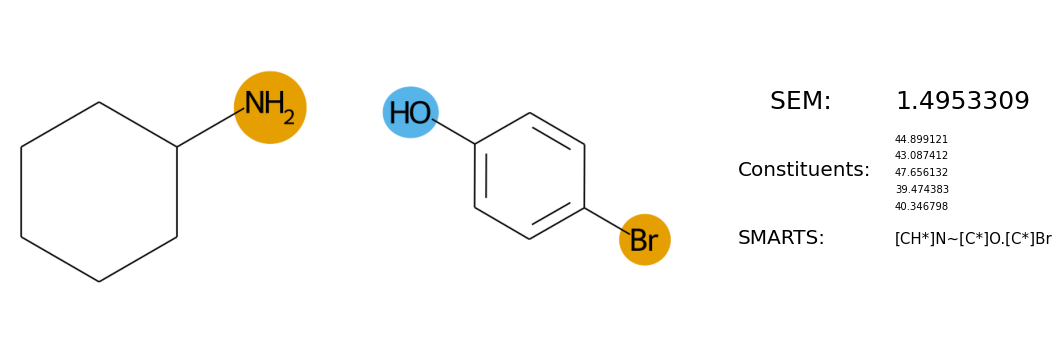

__________________________________________________________________________________________________________
mobley_9942801~mobley_1424265
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_7/mobley_9942801~mobley_1424265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_9/mobley_9942801~mobley_1424265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_8/mobley_9942801~mobley_1424265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_6/mobley_9942801~mobley_1424265/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_10/mobley_9942801~mobley_1424265/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_7/mobley_9942801~mobley_1424265/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_9/mobley_9942801~mobley_1424265/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebc/sim_8/mobley_9942801~mobley_1424265/free
./MGZ_

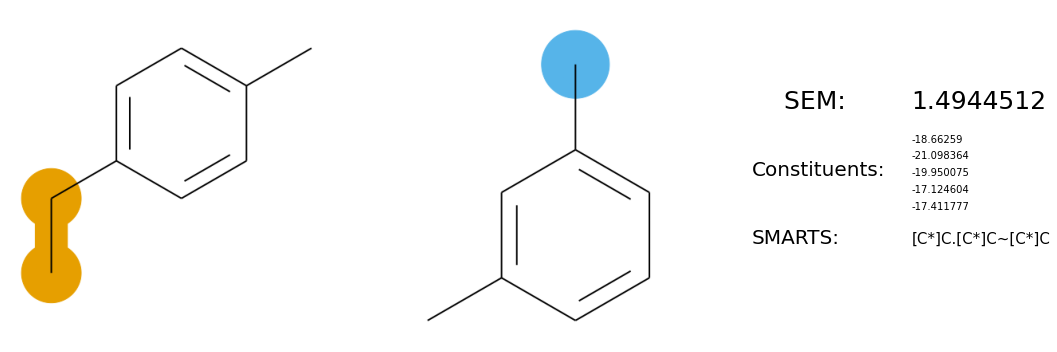

__________________________________________________________________________________________________________
mobley_1424265~mobley_9942801
./QUINTUP/30_dir_dir/finished/job_xfv/sim_18/mobley_1424265~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xfv/sim_20/mobley_1424265~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xfv/sim_17/mobley_1424265~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xfv/sim_19/mobley_1424265~mobley_9942801/free
./QUINTUP/30_dir_dir/finished/job_xfv/sim_16/mobley_1424265~mobley_9942801/free


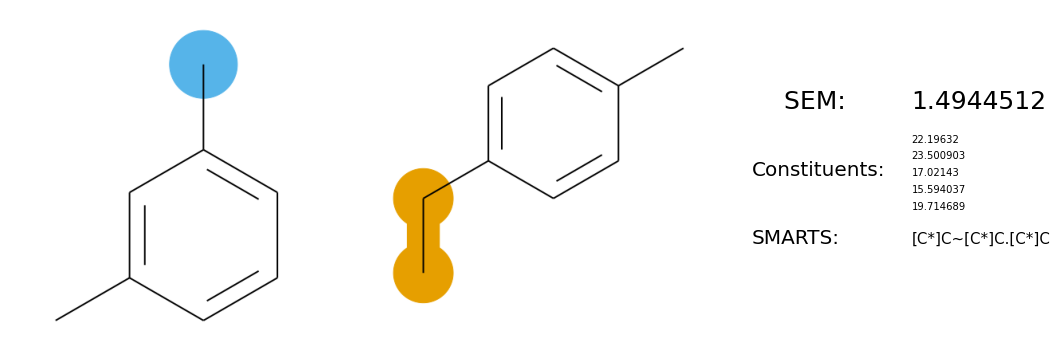

__________________________________________________________________________________________________________
mobley_9478823~mobley_1036761
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_7/mobley_9478823~mobley_1036761/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_9/mobley_9478823~mobley_1036761/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_8/mobley_9478823~mobley_1036761/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_6/mobley_9478823~mobley_1036761/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_10/mobley_9478823~mobley_1036761/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_7/mobley_9478823~mobley_1036761/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_9/mobley_9478823~mobley_1036761/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwp/sim_8/mobley_9478823~mobley_1036761/free
./MGZ_

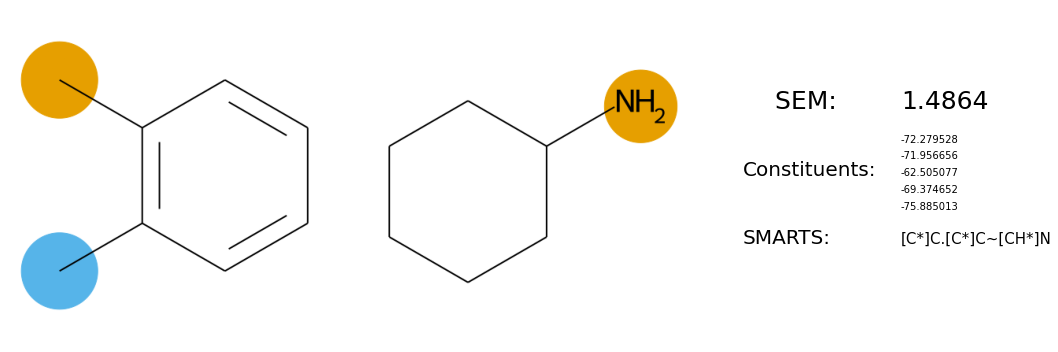

__________________________________________________________________________________________________________
mobley_1036761~mobley_5520946
./QUINTUP/29_dir_dir/finished/job_xam/sim_18/mobley_1036761~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xam/sim_20/mobley_1036761~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xam/sim_17/mobley_1036761~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xam/sim_19/mobley_1036761~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xam/sim_16/mobley_1036761~mobley_5520946/free


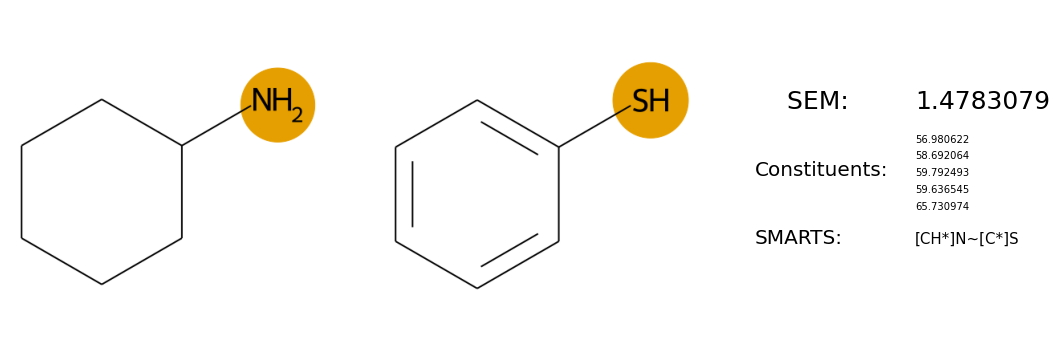

__________________________________________________________________________________________________________
mobley_1019269~mobley_1107178
./QUINTUP/24_dir_dir/round2/sim_248/mobley_1019269~mobley_1107178/free
./QUINTUP/24_dir_dir/round2/sim_249/mobley_1019269~mobley_1107178/free
./QUINTUP/24_dir_dir/round2/sim_250/mobley_1019269~mobley_1107178/free
./QUINTUP/24_dir_dir/round2/sim_247/mobley_1019269~mobley_1107178/free
./QUINTUP/24_dir_dir/round2/sim_246/mobley_1019269~mobley_1107178/free


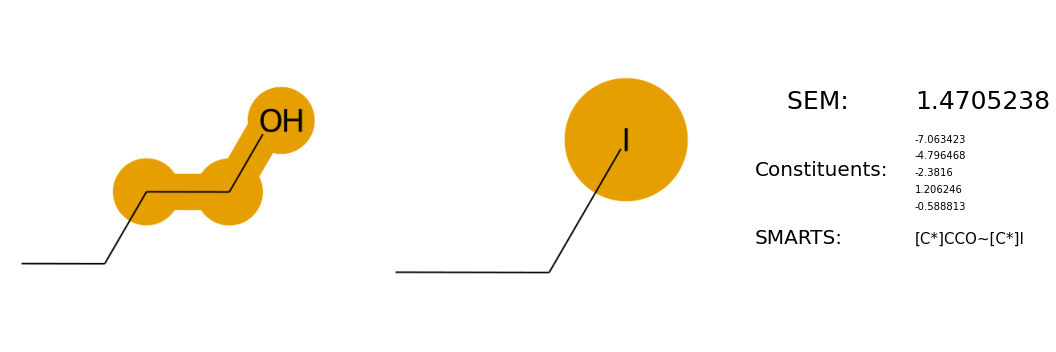

__________________________________________________________________________________________________________
mobley_9733743~mobley_8048190
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_7/mobley_9733743~mobley_8048190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_9/mobley_9733743~mobley_8048190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_8/mobley_9733743~mobley_8048190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_6/mobley_9733743~mobley_8048190/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_10/mobley_9733743~mobley_8048190/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_7/mobley_9733743~mobley_8048190/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_9/mobley_9733743~mobley_8048190/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyw/sim_8/mobley_9733743~mobley_8048190/free
./MGZ_

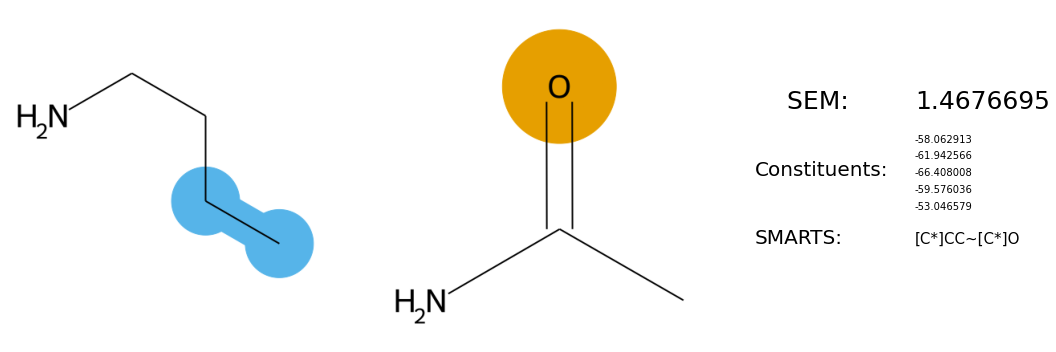

__________________________________________________________________________________________________________
mobley_9942801~mobley_8691603
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_3/mobley_9942801~mobley_8691603/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_1/mobley_9942801~mobley_8691603/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_5/mobley_9942801~mobley_8691603/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_4/mobley_9942801~mobley_8691603/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_2/mobley_9942801~mobley_8691603/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_3/mobley_9942801~mobley_8691603/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_1/mobley_9942801~mobley_8691603/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebm/sim_5/mobley_9942801~mobley_8691603/free
./MGZ_R

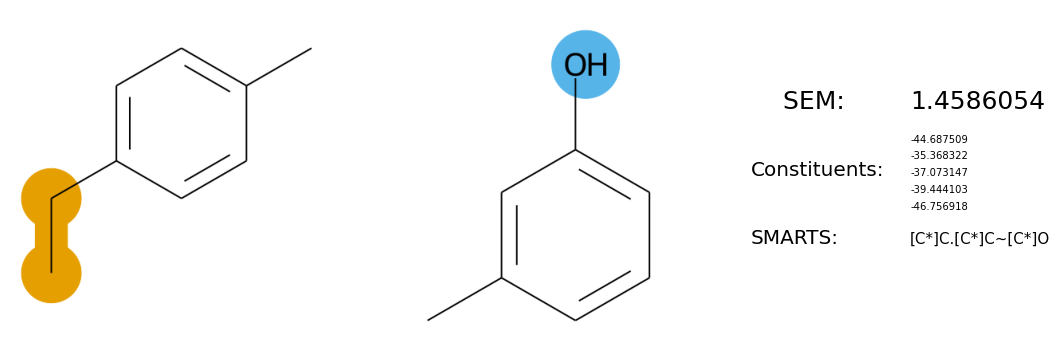

__________________________________________________________________________________________________________
mobley_1036761~mobley_8723116
./QUINTUP/29_dir_dir/finished/job_xao/sim_7/mobley_1036761~mobley_8723116/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_9/mobley_1036761~mobley_8723116/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_8/mobley_1036761~mobley_8723116/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_6/mobley_1036761~mobley_8723116/free
./QUINTUP/29_dir_dir/finished/job_xao/sim_10/mobley_1036761~mobley_8723116/free


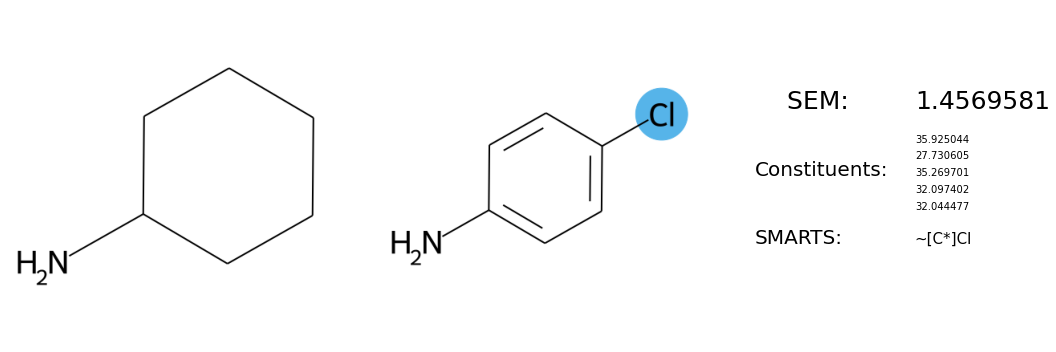

__________________________________________________________________________________________________________
mobley_9942801~mobley_1987439
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_3/mobley_9942801~mobley_1987439/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_1/mobley_9942801~mobley_1987439/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_5/mobley_9942801~mobley_1987439/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_4/mobley_9942801~mobley_1987439/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_2/mobley_9942801~mobley_1987439/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_3/mobley_9942801~mobley_1987439/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_1/mobley_9942801~mobley_1987439/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebe/sim_5/mobley_9942801~mobley_1987439/free
./MGZ_R

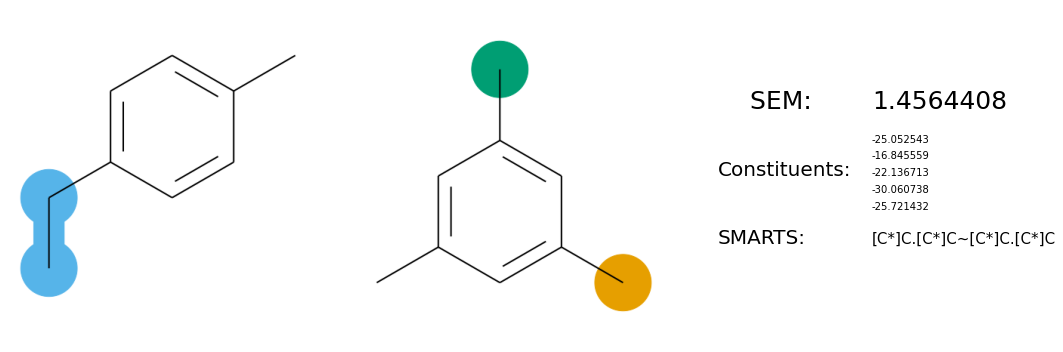

__________________________________________________________________________________________________________
mobley_6060301~mobley_1019269
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_3/mobley_6060301~mobley_1019269/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_1/mobley_6060301~mobley_1019269/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_2/mobley_6060301~mobley_1019269/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_0/mobley_6060301~mobley_1019269/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_3/mobley_6060301~mobley_1019269/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_3/mobley_6060301~mobley_1019269/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_1/mobley_6060301~mobley_1019269/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_1/GPU_population_2/mobley_6060301~mobley_1019269/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/jo

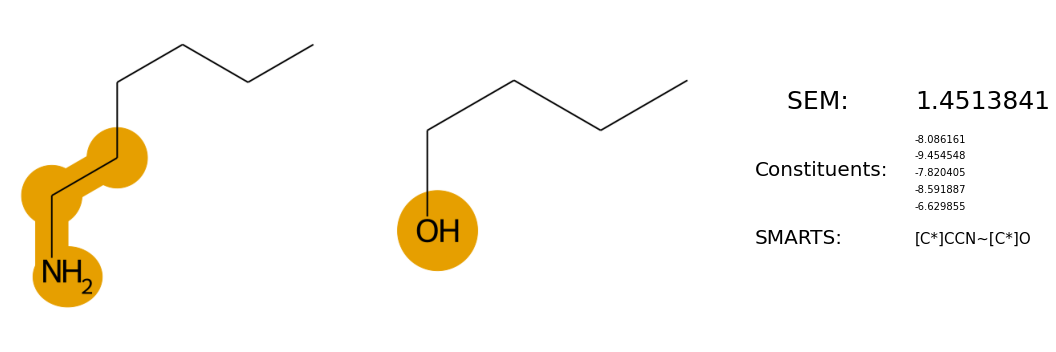

__________________________________________________________________________________________________________
mobley_1019269~mobley_6060301
./QUINTUP/24_dir_dir/round2/sim_445/mobley_1019269~mobley_6060301/free
./QUINTUP/24_dir_dir/round2/sim_442/mobley_1019269~mobley_6060301/free
./QUINTUP/24_dir_dir/round2/sim_441/mobley_1019269~mobley_6060301/free
./QUINTUP/24_dir_dir/round2/sim_444/mobley_1019269~mobley_6060301/free
./QUINTUP/24_dir_dir/round2/sim_443/mobley_1019269~mobley_6060301/free


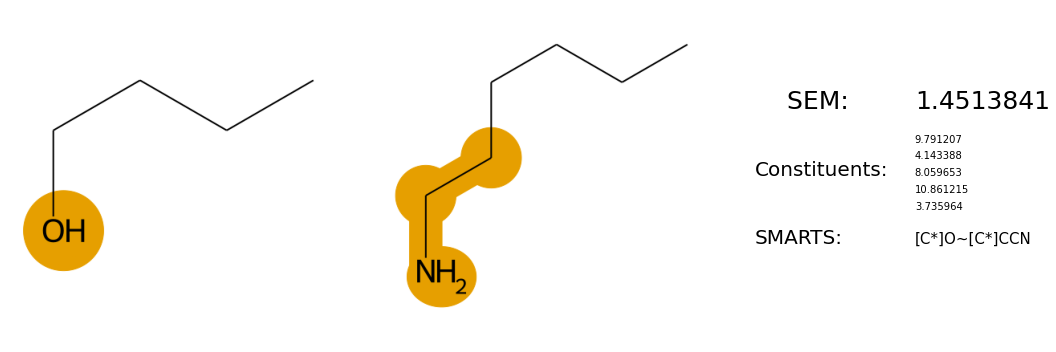

__________________________________________________________________________________________________________
mobley_9478823~mobley_7010316
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_3/mobley_9478823~mobley_7010316/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_1/mobley_9478823~mobley_7010316/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_5/mobley_9478823~mobley_7010316/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_4/mobley_9478823~mobley_7010316/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_2/mobley_9478823~mobley_7010316/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_3/mobley_9478823~mobley_7010316/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_1/mobley_9478823~mobley_7010316/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdwz/sim_5/mobley_9478823~mobley_7010316/free
./MGZ_R

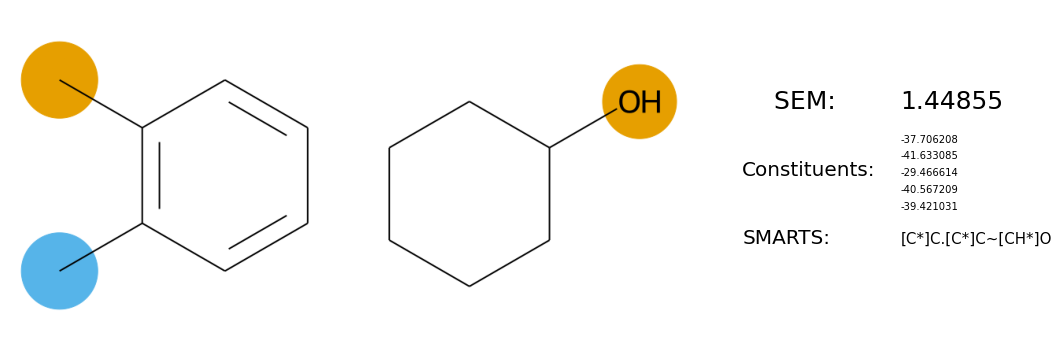

__________________________________________________________________________________________________________
mobley_9942801~mobley_1755375
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_3/mobley_9942801~mobley_1755375/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_1/mobley_9942801~mobley_1755375/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_5/mobley_9942801~mobley_1755375/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_4/mobley_9942801~mobley_1755375/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_2/mobley_9942801~mobley_1755375/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_3/mobley_9942801~mobley_1755375/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_1/mobley_9942801~mobley_1755375/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebd/sim_5/mobley_9942801~mobley_1755375/free
./MGZ_R

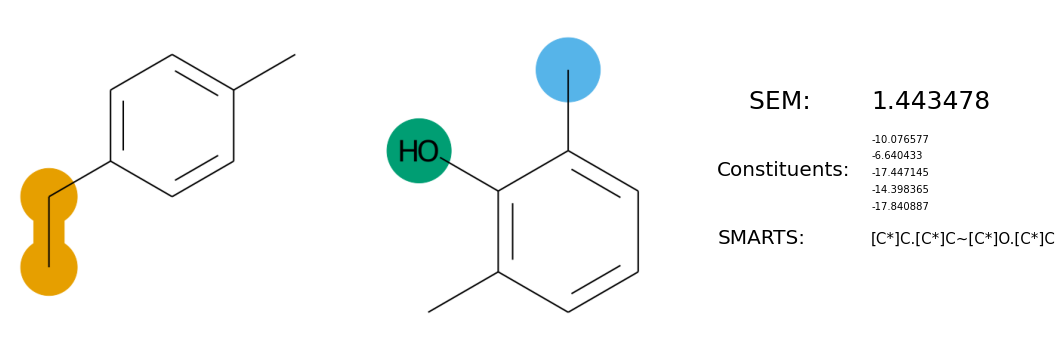

__________________________________________________________________________________________________________
mobley_1019269~mobley_1650157
./QUINTUP/30_dir_dir/finished/job_xaf/sim_18/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_20/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_17/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_19/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_16/mobley_1019269~mobley_1650157/free


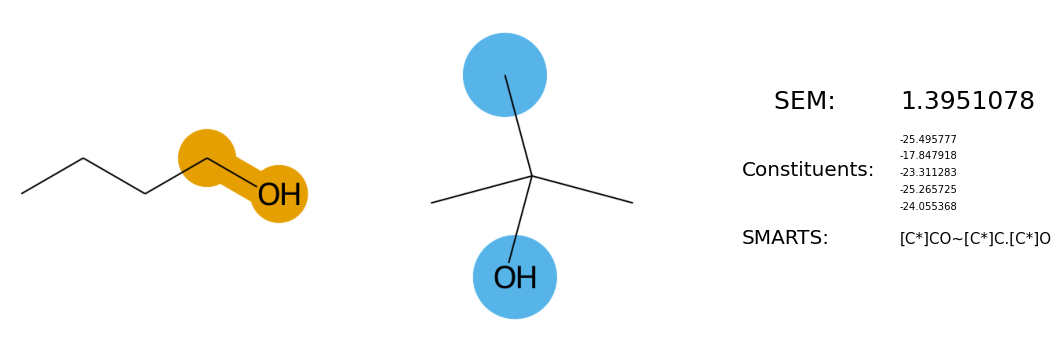

__________________________________________________________________________________________________________
mobley_1873346~mobley_3211679
./QUINTUP/29_dir_dir/finished/job_xfw/sim_7/mobley_1873346~mobley_3211679/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_9/mobley_1873346~mobley_3211679/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_8/mobley_1873346~mobley_3211679/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_6/mobley_1873346~mobley_3211679/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_10/mobley_1873346~mobley_3211679/free
poep


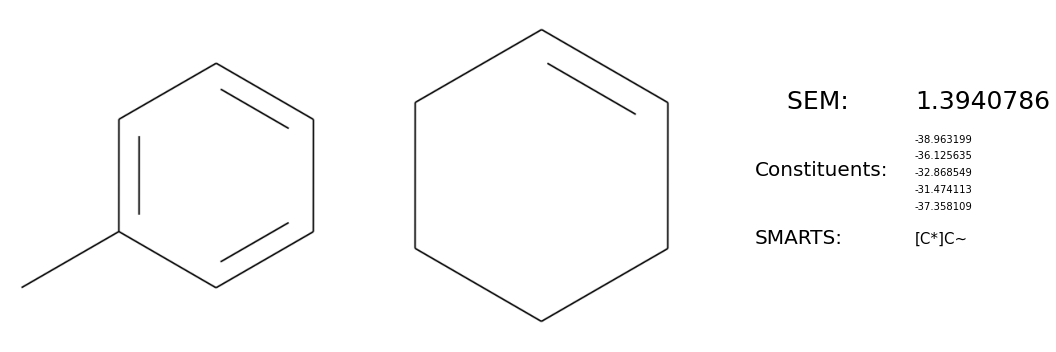

__________________________________________________________________________________________________________
mobley_1019269~mobley_8765203
./QUINTUP/29_dir_dir/finished/job_xai/sim_14/mobley_1019269~mobley_8765203/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_13/mobley_1019269~mobley_8765203/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_12/mobley_1019269~mobley_8765203/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_15/mobley_1019269~mobley_8765203/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_11/mobley_1019269~mobley_8765203/free


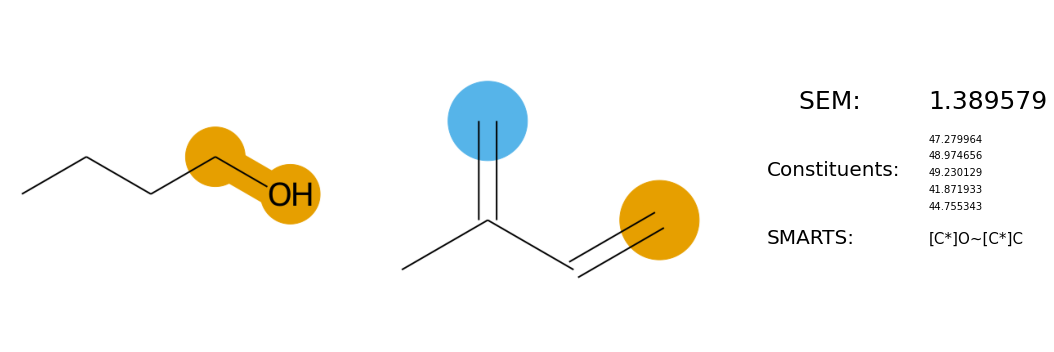

__________________________________________________________________________________________________________
mobley_1571523~mobley_8127829
./QUINTUP/30_dir_dir/finished/job_xhd/sim_18/mobley_1571523~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_20/mobley_1571523~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_17/mobley_1571523~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_19/mobley_1571523~mobley_8127829/free
./QUINTUP/30_dir_dir/finished/job_xhd/sim_16/mobley_1571523~mobley_8127829/free


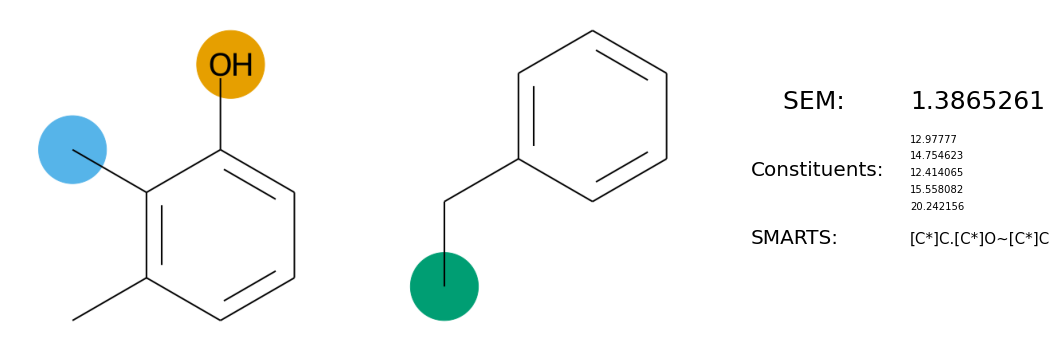

__________________________________________________________________________________________________________


In [29]:
%matplotlib inline
plot_perts(quints_infos.sort_values(by="sem", ascending=False).head(200))

In [14]:
plot_perts(quints_infos[quints_infos["sem"] == 0.0].tail(10), precision=6)
# this cell doesn't return any values now that globbing is fixed.

# Lowest realistic SEMs:

mobley_1563176~mobley_2802855
./QUINTUP/29_dir_dir/finished/job_xcq/sim_14/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_13/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_12/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_15/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_11/mobley_1563176~mobley_2802855/free


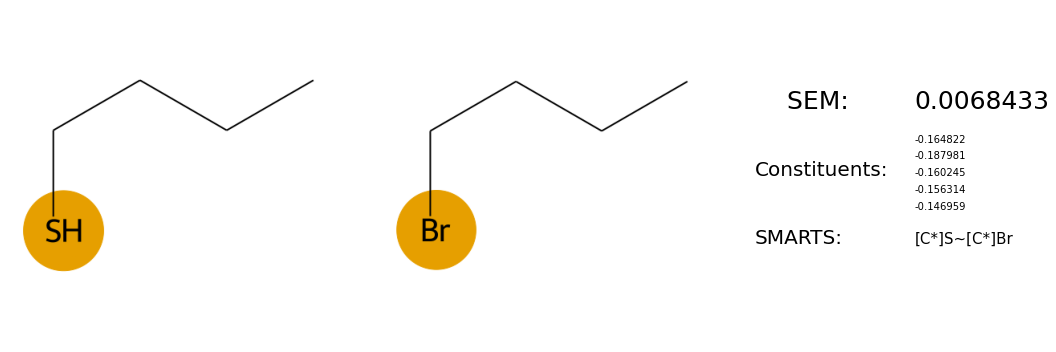

__________________________________________________________________________________________________________
mobley_1755375~mobley_5571660
./QUINTUP/29_dir_dir/finished/job_xej/sim_3/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_1/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_5/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_4/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_2/mobley_1755375~mobley_5571660/free


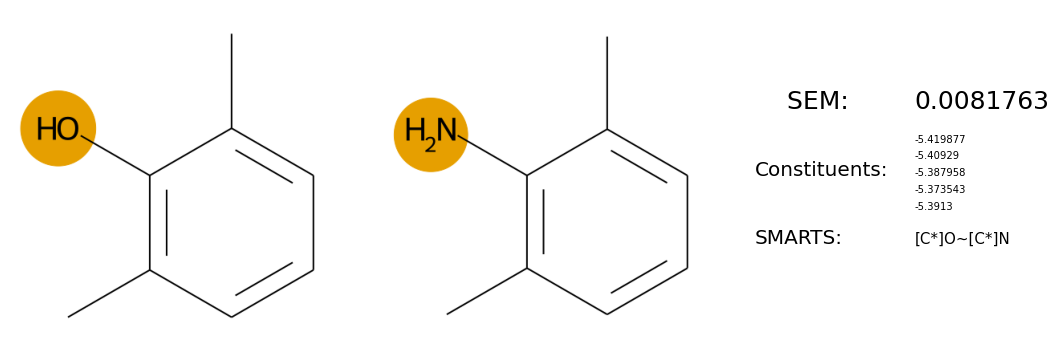

__________________________________________________________________________________________________________
mobley_186894~mobley_7708038
./QUINTUP/29_dir_dir/finished/job_xft/sim_3/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_1/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_5/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_4/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_2/mobley_186894~mobley_7708038/free


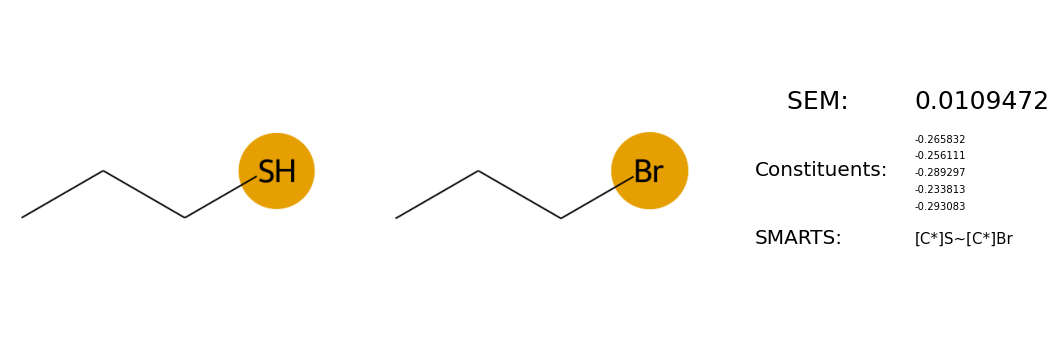

__________________________________________________________________________________________________________
mobley_9733743~mobley_2422586
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_18/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_20/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_17/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_19/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_16/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_18/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_20/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_17/mobley_9733743~mobley_2422586/free

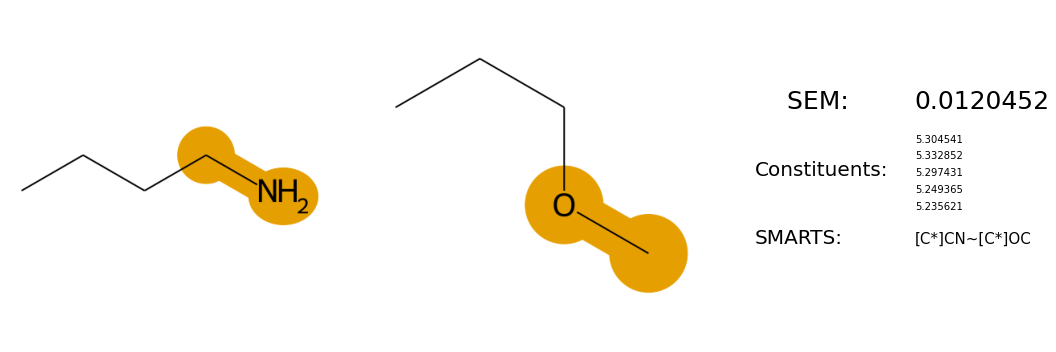

__________________________________________________________________________________________________________
mobley_1017962~mobley_7977115
./QUINTUP/24_dir_dir/round2/sim_194/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_191/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_192/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_193/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_195/mobley_1017962~mobley_7977115/free


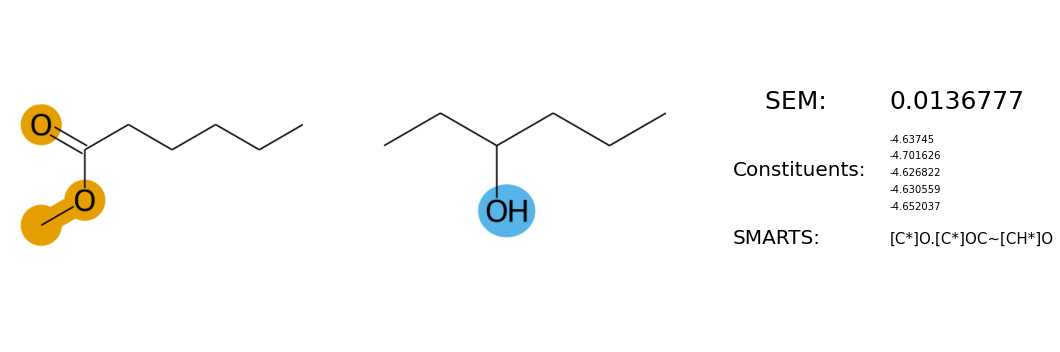

__________________________________________________________________________________________________________
mobley_1019269~mobley_9733743
./QUINTUP/29_dir_dir/finished/job_xaj/sim_18/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_20/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_17/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_19/mobley_1019269~mobley_9733743/free
./QUINTUP/29_dir_dir/finished/job_xaj/sim_16/mobley_1019269~mobley_9733743/free


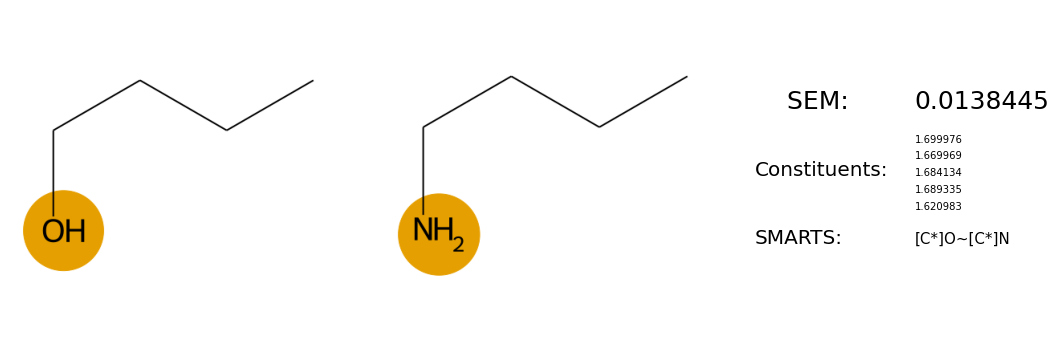

__________________________________________________________________________________________________________
mobley_1662128~mobley_6911232
./QUINTUP/30_dir_dir/finished/job_xig/sim_3/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_1/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_5/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_4/mobley_1662128~mobley_6911232/free
./QUINTUP/30_dir_dir/finished/job_xig/sim_2/mobley_1662128~mobley_6911232/free


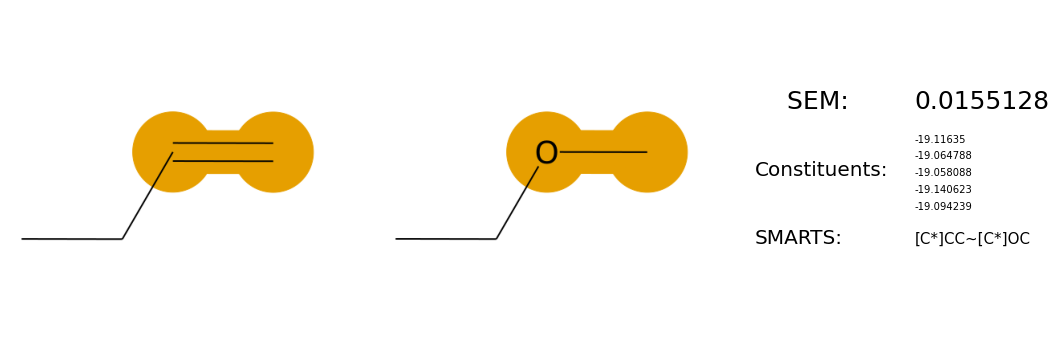

__________________________________________________________________________________________________________
mobley_9794857~mobley_5935995
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_14/mobley_9794857~mobley_5935995/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_13/mobley_9794857~mobley_5935995/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_12/mobley_9794857~mobley_5935995/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_15/mobley_9794857~mobley_5935995/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_11/mobley_9794857~mobley_5935995/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_14/mobley_9794857~mobley_5935995/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_13/mobley_9794857~mobley_5935995/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzj/sim_12/mobley_9794857~mobley_5935995/free

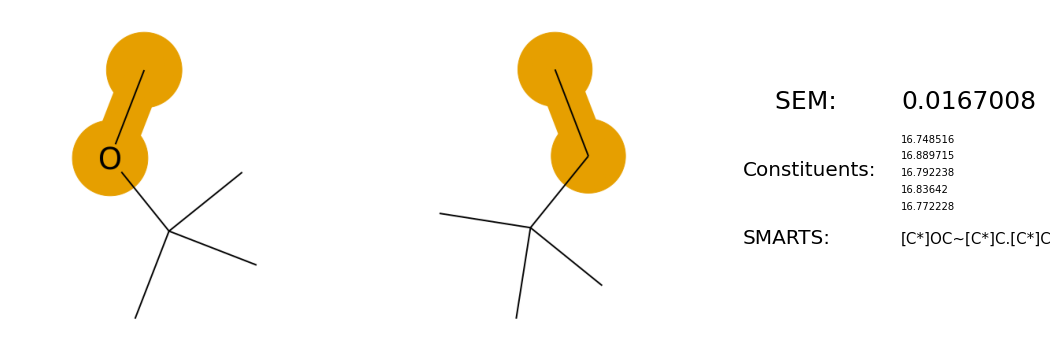

__________________________________________________________________________________________________________
mobley_1036761~mobley_7010316
./QUINTUP/29_dir_dir/finished/job_xan/sim_14/mobley_1036761~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xan/sim_13/mobley_1036761~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xan/sim_12/mobley_1036761~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xan/sim_15/mobley_1036761~mobley_7010316/free
./QUINTUP/29_dir_dir/finished/job_xan/sim_11/mobley_1036761~mobley_7010316/free


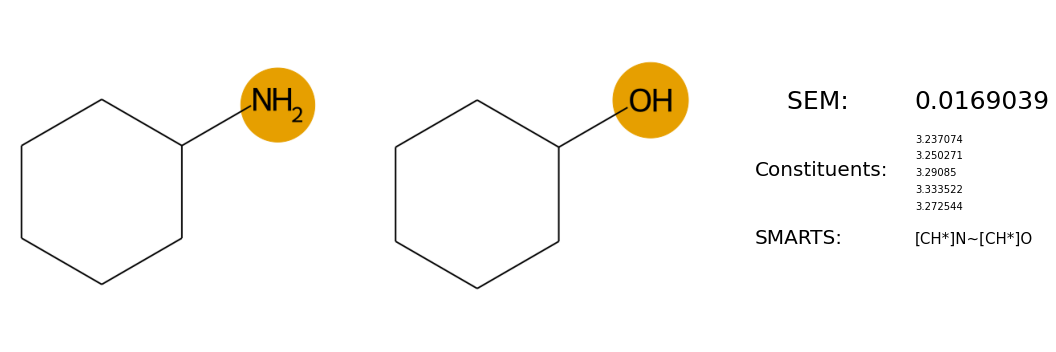

__________________________________________________________________________________________________________
mobley_9507933~mobley_3234716
./QUINTUP/23_dir_dir/round2/quintup_transform_6/job_0/GPU_population_0/mobley_9507933~mobley_3234716/free
./QUINTUP/23_dir_dir/round2/quintup_transform_6/job_0/GPU_population_1/mobley_9507933~mobley_3234716/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_0/mobley_9507933~mobley_3234716/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_1/mobley_9507933~mobley_3234716/free
./MGZ_RECENT/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_0/mobley_9507933~mobley_3234716/free
./MGZ_RECENT/02_SUBSETS_quintup/quintup_transform_6/job_0/GPU_population_1/mobley_9507933~mobley_3234716/free


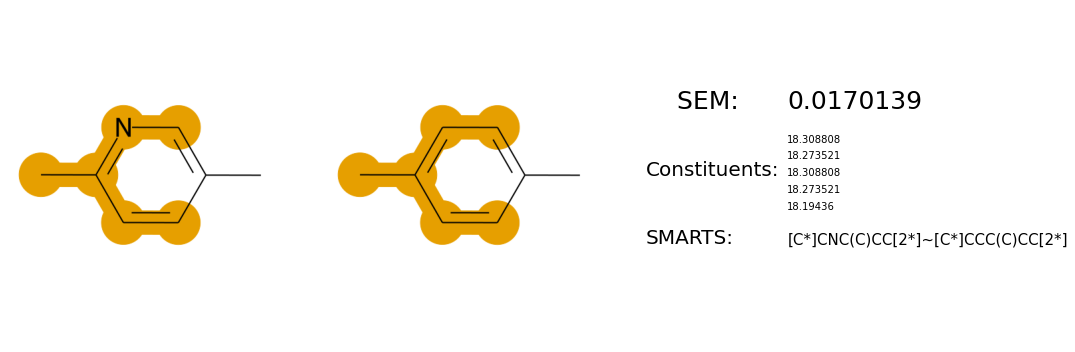

__________________________________________________________________________________________________________
mobley_9883303~mobley_2864987
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_18/mobley_9883303~mobley_2864987/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_17/mobley_9883303~mobley_2864987/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_19/mobley_9883303~mobley_2864987/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/mobley_9883303~mobley_2864987/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_16/mobley_9883303~mobley_2864987/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_18/mobley_9883303~mobley_2864987/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_17/mobley_9883303~mobley_2864987/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_19/mobley_9883303~mobley_2864987/free
./MGZ_

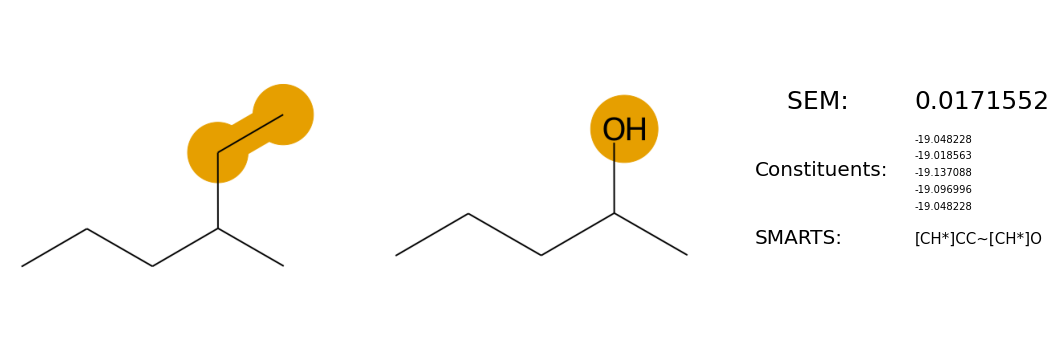

__________________________________________________________________________________________________________
mobley_1019269~mobley_8492526
./QUINTUP/29_dir_dir/finished/job_xai/sim_7/mobley_1019269~mobley_8492526/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_9/mobley_1019269~mobley_8492526/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_8/mobley_1019269~mobley_8492526/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_6/mobley_1019269~mobley_8492526/free
./QUINTUP/29_dir_dir/finished/job_xai/sim_10/mobley_1019269~mobley_8492526/free


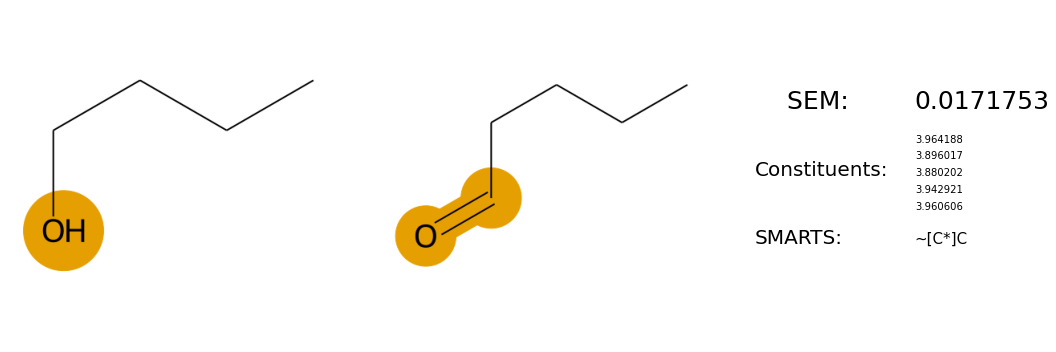

__________________________________________________________________________________________________________
mobley_1563176~mobley_3639400
./QUINTUP/29_dir_dir/finished/job_xcq/sim_18/mobley_1563176~mobley_3639400/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_20/mobley_1563176~mobley_3639400/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_17/mobley_1563176~mobley_3639400/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_19/mobley_1563176~mobley_3639400/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_16/mobley_1563176~mobley_3639400/free


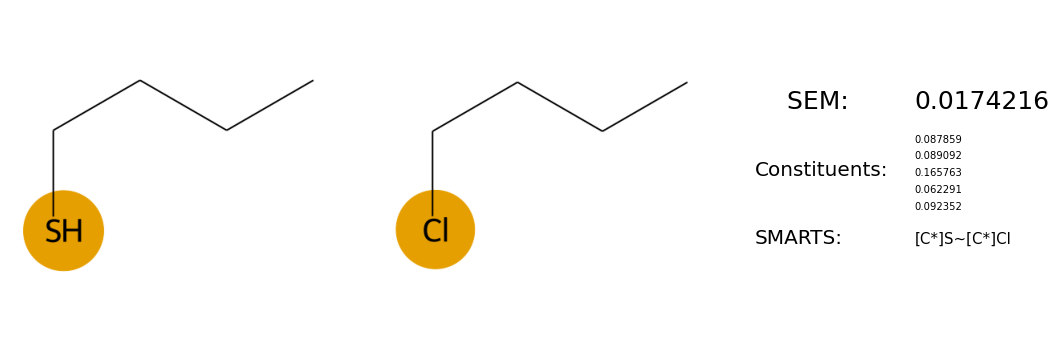

__________________________________________________________________________________________________________
mobley_1674094~mobley_4893032
./QUINTUP/29_dir_dir/finished/job_xdr/sim_3/mobley_1674094~mobley_4893032/free
./QUINTUP/29_dir_dir/finished/job_xdr/sim_1/mobley_1674094~mobley_4893032/free
./QUINTUP/29_dir_dir/finished/job_xdr/sim_5/mobley_1674094~mobley_4893032/free
./QUINTUP/29_dir_dir/finished/job_xdr/sim_4/mobley_1674094~mobley_4893032/free
./QUINTUP/29_dir_dir/finished/job_xdr/sim_2/mobley_1674094~mobley_4893032/free


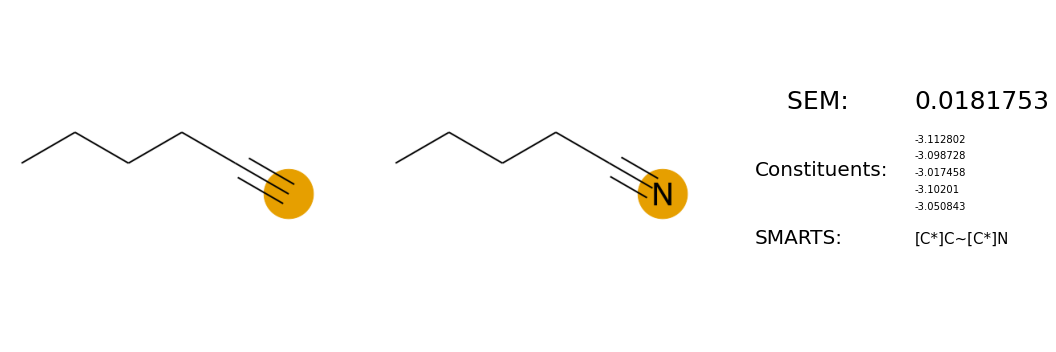

__________________________________________________________________________________________________________
mobley_1199854~mobley_7708038
./QUINTUP/29_dir_dir/finished/job_xbo/sim_7/mobley_1199854~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xbo/sim_9/mobley_1199854~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xbo/sim_8/mobley_1199854~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xbo/sim_6/mobley_1199854~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xbo/sim_10/mobley_1199854~mobley_7708038/free


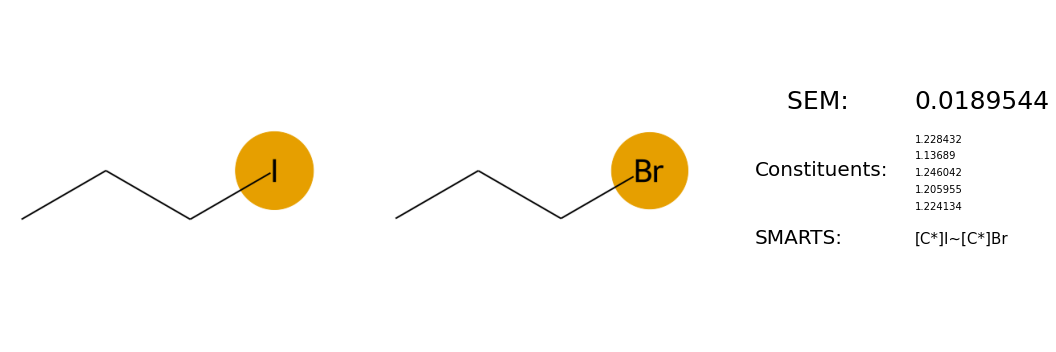

__________________________________________________________________________________________________________
mobley_5692472~mobley_9029594
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_3/mobley_5692472~mobley_9029594/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_1/mobley_5692472~mobley_9029594/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_2/mobley_5692472~mobley_9029594/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_0/mobley_5692472~mobley_9029594/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_2/GPU_population_0/mobley_5692472~mobley_9029594/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_3/mobley_5692472~mobley_9029594/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_1/mobley_5692472~mobley_9029594/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_1/GPU_population_2/mobley_5692472~mobley_9029594/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/jo

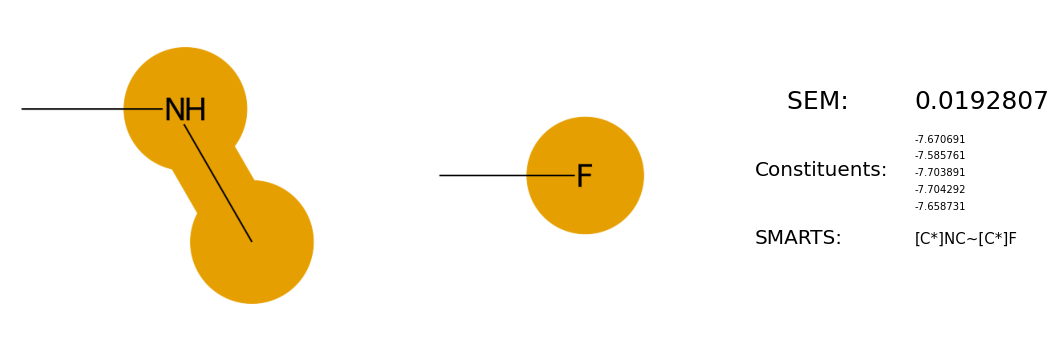

__________________________________________________________________________________________________________
mobley_1662128~mobley_2310185
./QUINTUP/30_dir_dir/finished/job_xia/sim_3/mobley_1662128~mobley_2310185/free
./QUINTUP/30_dir_dir/finished/job_xia/sim_1/mobley_1662128~mobley_2310185/free
./QUINTUP/30_dir_dir/finished/job_xia/sim_5/mobley_1662128~mobley_2310185/free
./QUINTUP/30_dir_dir/finished/job_xia/sim_4/mobley_1662128~mobley_2310185/free
./QUINTUP/30_dir_dir/finished/job_xia/sim_2/mobley_1662128~mobley_2310185/free


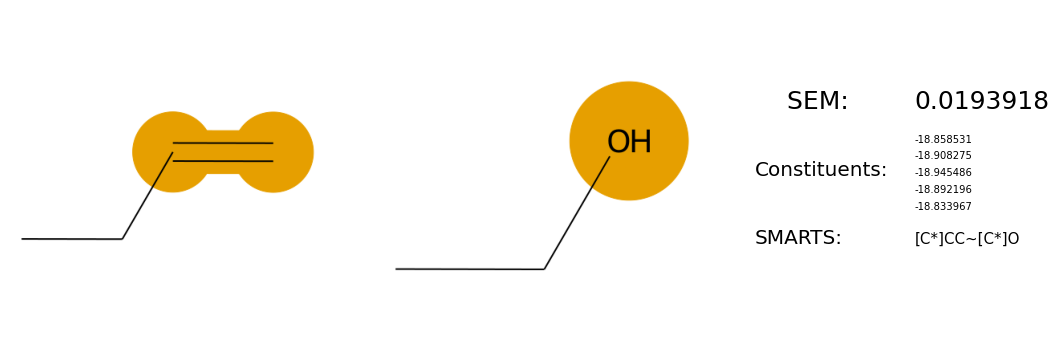

__________________________________________________________________________________________________________
mobley_4043951~mobley_5449201


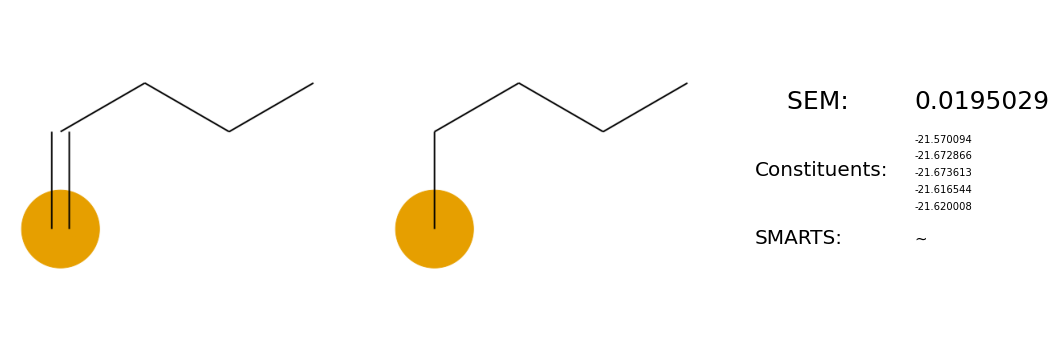

__________________________________________________________________________________________________________
mobley_5449201~mobley_4043951


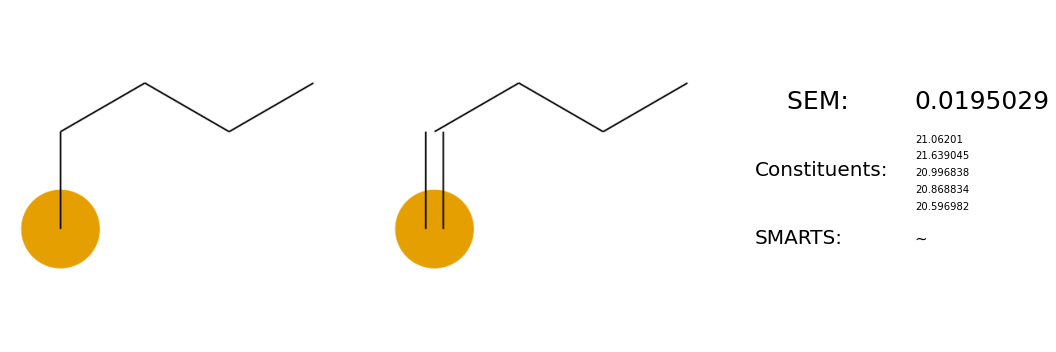

__________________________________________________________________________________________________________
mobley_1728386~mobley_7497999
./QUINTUP/29_dir_dir/finished/job_xeb/sim_7/mobley_1728386~mobley_7497999/free
./QUINTUP/29_dir_dir/finished/job_xeb/sim_9/mobley_1728386~mobley_7497999/free
./QUINTUP/29_dir_dir/finished/job_xeb/sim_8/mobley_1728386~mobley_7497999/free
./QUINTUP/29_dir_dir/finished/job_xeb/sim_6/mobley_1728386~mobley_7497999/free
./QUINTUP/29_dir_dir/finished/job_xeb/sim_10/mobley_1728386~mobley_7497999/free


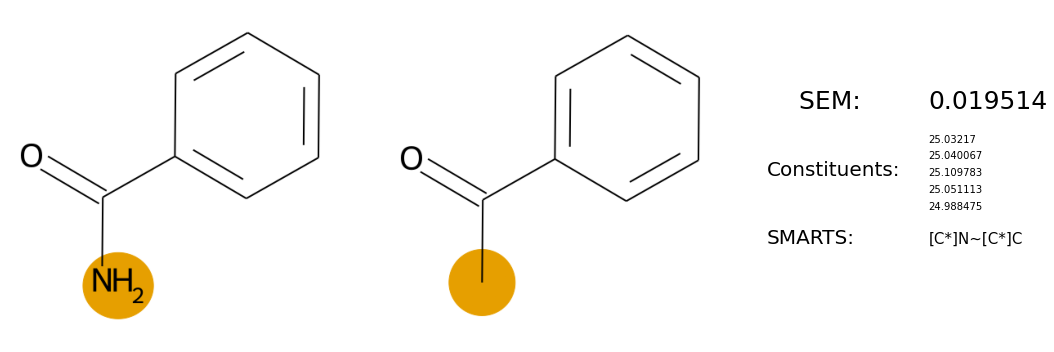

__________________________________________________________________________________________________________
mobley_2008055~mobley_2310185
./QUINTUP/29_dir_dir/finished/job_xiu/sim_3/mobley_2008055~mobley_2310185/free
./QUINTUP/29_dir_dir/finished/job_xiu/sim_1/mobley_2008055~mobley_2310185/free
./QUINTUP/29_dir_dir/finished/job_xiu/sim_5/mobley_2008055~mobley_2310185/free
./QUINTUP/29_dir_dir/finished/job_xiu/sim_4/mobley_2008055~mobley_2310185/free
./QUINTUP/29_dir_dir/finished/job_xiu/sim_2/mobley_2008055~mobley_2310185/free


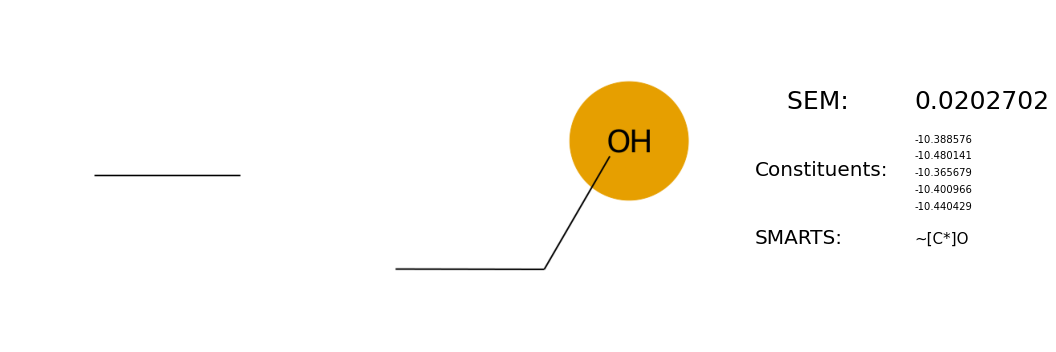

__________________________________________________________________________________________________________
mobley_1967551~mobley_1800170
./QUINTUP/29_dir_dir/finished/job_xib/sim_18/mobley_1967551~mobley_1800170/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_20/mobley_1967551~mobley_1800170/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_17/mobley_1967551~mobley_1800170/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_19/mobley_1967551~mobley_1800170/free
./QUINTUP/29_dir_dir/finished/job_xib/sim_16/mobley_1967551~mobley_1800170/free


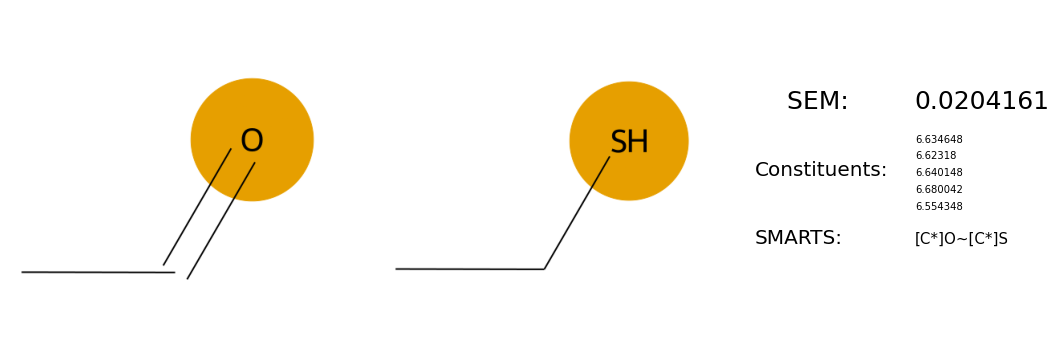

__________________________________________________________________________________________________________
mobley_1800170~mobley_1967551
./QUINTUP/29_dir_dir/finished/job_xeq/sim_14/mobley_1800170~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xeq/sim_13/mobley_1800170~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xeq/sim_12/mobley_1800170~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xeq/sim_15/mobley_1800170~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xeq/sim_11/mobley_1800170~mobley_1967551/free


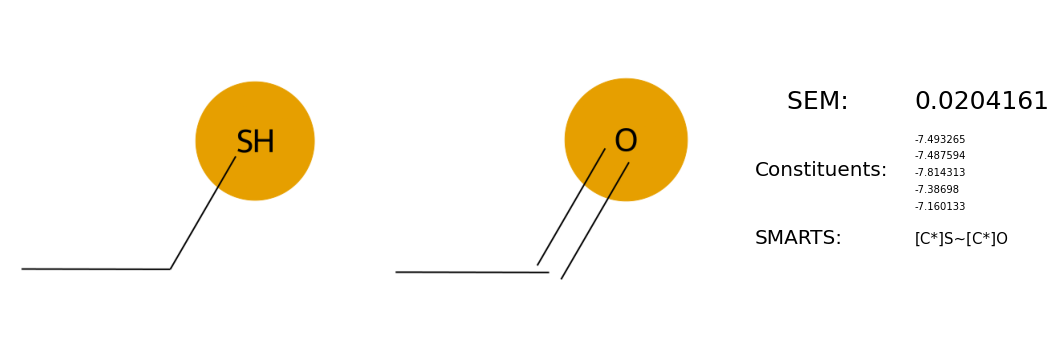

__________________________________________________________________________________________________________
mobley_4035953~mobley_9478823


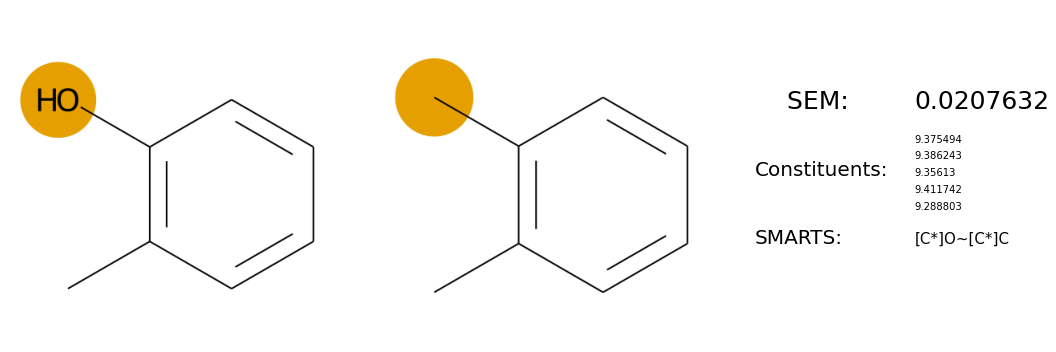

__________________________________________________________________________________________________________
mobley_929676~mobley_4759887
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_3/mobley_929676~mobley_4759887/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_1/mobley_929676~mobley_4759887/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_5/mobley_929676~mobley_4759887/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_4/mobley_929676~mobley_4759887/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_2/mobley_929676~mobley_4759887/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_3/mobley_929676~mobley_4759887/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_1/mobley_929676~mobley_4759887/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvp/sim_5/mobley_929676~mobley_4759887/free
./MGZ_RECENT/02_

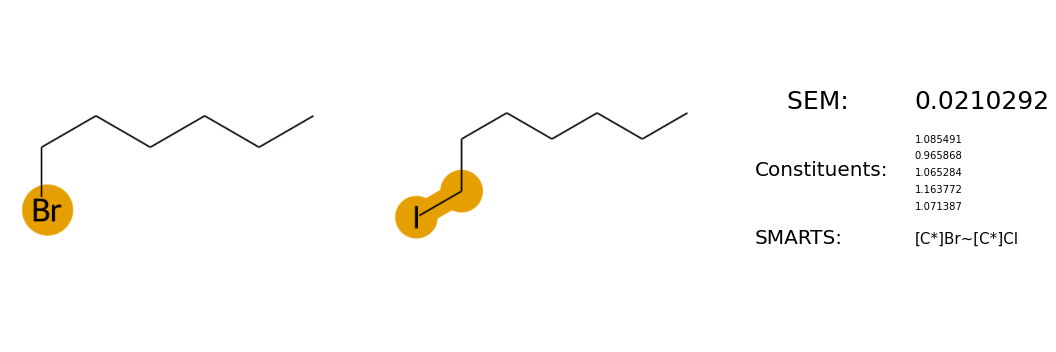

__________________________________________________________________________________________________________
mobley_9733743~mobley_1875719
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_3/mobley_9733743~mobley_1875719/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_1/mobley_9733743~mobley_1875719/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_5/mobley_9733743~mobley_1875719/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_4/mobley_9733743~mobley_1875719/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_2/mobley_9733743~mobley_1875719/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_3/mobley_9733743~mobley_1875719/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_1/mobley_9733743~mobley_1875719/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyl/sim_5/mobley_9733743~mobley_1875719/free
./MGZ_R

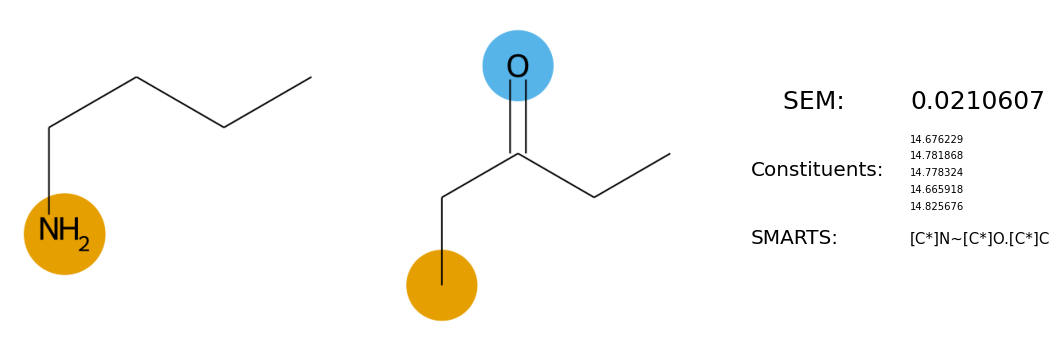

__________________________________________________________________________________________________________
mobley_1019269~mobley_6917738
./QUINTUP/30_dir_dir/finished/job_xar/sim_3/mobley_1019269~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xar/sim_1/mobley_1019269~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xar/sim_5/mobley_1019269~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xar/sim_4/mobley_1019269~mobley_6917738/free
./QUINTUP/30_dir_dir/finished/job_xar/sim_2/mobley_1019269~mobley_6917738/free


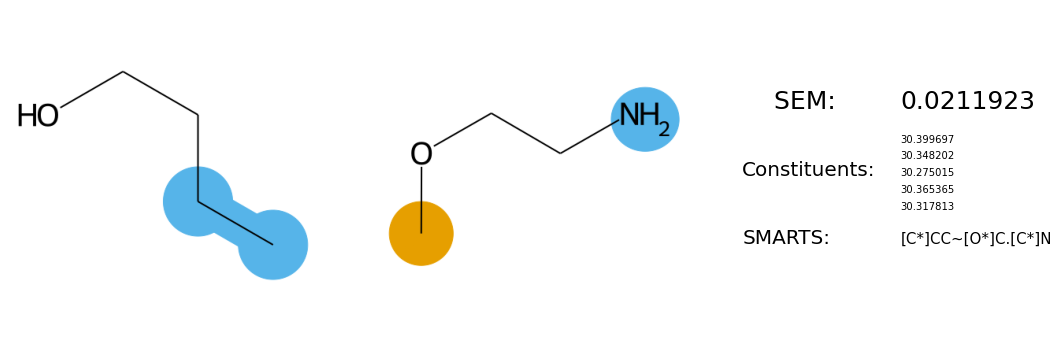

__________________________________________________________________________________________________________
mobley_9942801~mobley_2925352
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_18/mobley_9942801~mobley_2925352/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_20/mobley_9942801~mobley_2925352/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_17/mobley_9942801~mobley_2925352/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_19/mobley_9942801~mobley_2925352/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_16/mobley_9942801~mobley_2925352/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_18/mobley_9942801~mobley_2925352/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_20/mobley_9942801~mobley_2925352/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzebf/sim_17/mobley_9942801~mobley_2925352/free

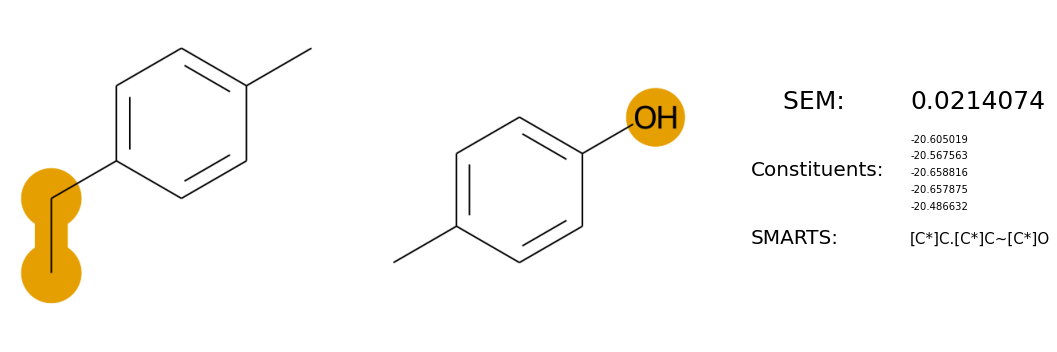

__________________________________________________________________________________________________________
mobley_1873346~mobley_3234716
./QUINTUP/29_dir_dir/finished/job_xfw/sim_14/mobley_1873346~mobley_3234716/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_13/mobley_1873346~mobley_3234716/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_12/mobley_1873346~mobley_3234716/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_15/mobley_1873346~mobley_3234716/free
./QUINTUP/29_dir_dir/finished/job_xfw/sim_11/mobley_1873346~mobley_3234716/free


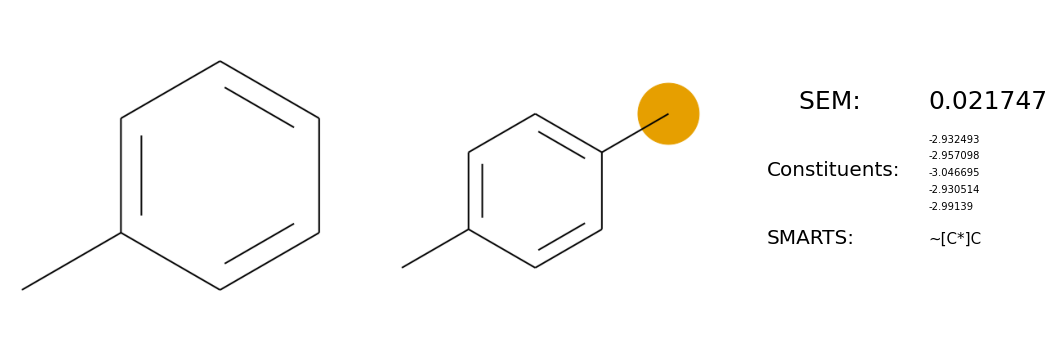

__________________________________________________________________________________________________________
mobley_1019269~mobley_1199854
./QUINTUP/30_dir_dir/finished/job_xaf/sim_3/mobley_1019269~mobley_1199854/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_1/mobley_1019269~mobley_1199854/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_5/mobley_1019269~mobley_1199854/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_4/mobley_1019269~mobley_1199854/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_2/mobley_1019269~mobley_1199854/free


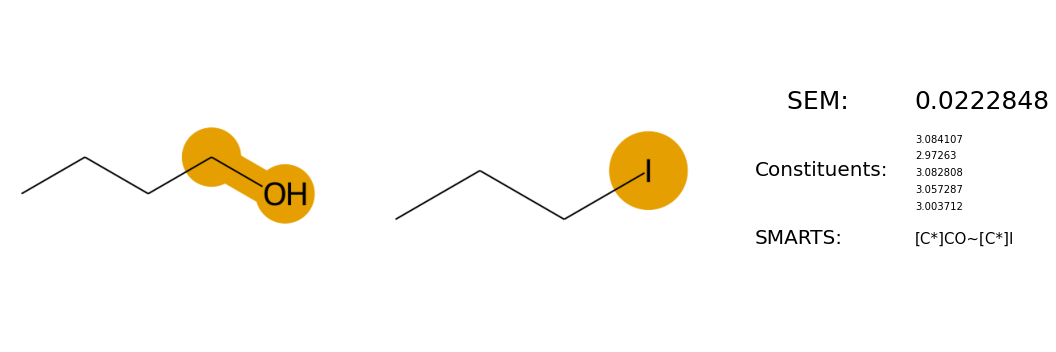

__________________________________________________________________________________________________________
mobley_1722522~mobley_6619554
./QUINTUP/29_dir_dir/finished/job_xdy/sim_18/mobley_1722522~mobley_6619554/free
./QUINTUP/29_dir_dir/finished/job_xdy/sim_20/mobley_1722522~mobley_6619554/free
./QUINTUP/29_dir_dir/finished/job_xdy/sim_17/mobley_1722522~mobley_6619554/free
./QUINTUP/29_dir_dir/finished/job_xdy/sim_19/mobley_1722522~mobley_6619554/free
./QUINTUP/29_dir_dir/finished/job_xdy/sim_16/mobley_1722522~mobley_6619554/free


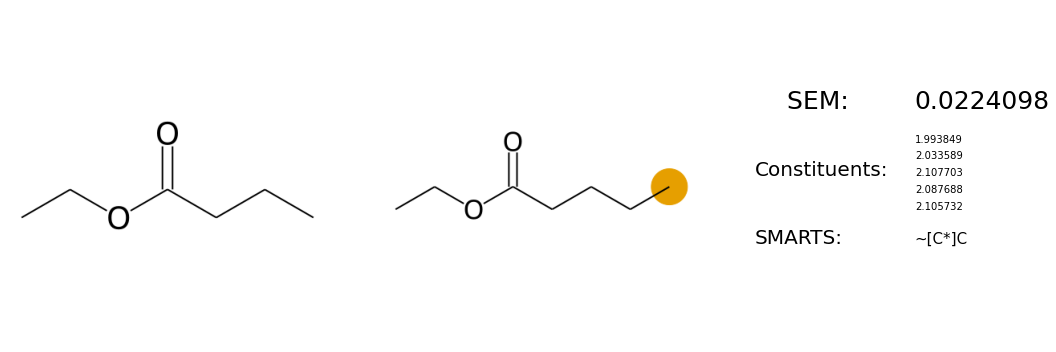

__________________________________________________________________________________________________________
mobley_186894~mobley_1923244
./QUINTUP/29_dir_dir/finished/job_xfr/sim_7/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_7/mobley_186894~mobley_1923244/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_9/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_9/mobley_186894~mobley_1923244/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_8/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_8/mobley_186894~mobley_1923244/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_6/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_6/mobley_186894~mobley_1923244/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_10/mobley_186894~mobley_1923244/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_10/

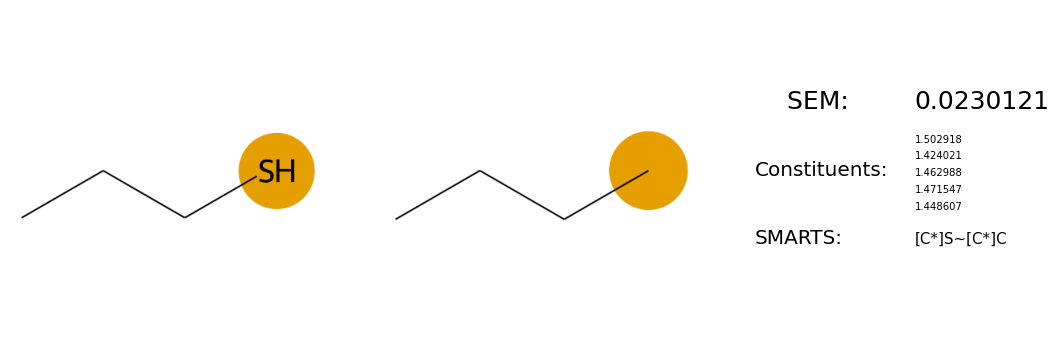

__________________________________________________________________________________________________________
mobley_1923244~mobley_186894
./QUINTUP/29_dir_dir/finished/job_xht/sim_7/mobley_1923244~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_9/mobley_1923244~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_8/mobley_1923244~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_6/mobley_1923244~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_10/mobley_1923244~mobley_186894/free


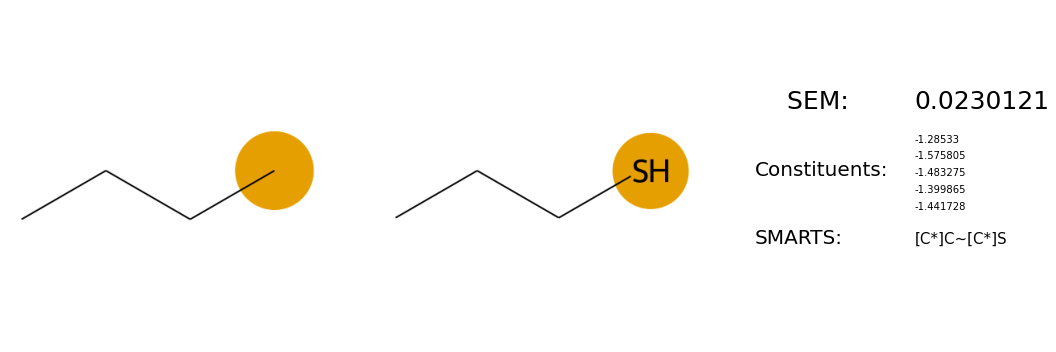

__________________________________________________________________________________________________________
mobley_1708457~mobley_8578590
./QUINTUP/29_dir_dir/finished/job_xdv/sim_14/mobley_1708457~mobley_8578590/free
./QUINTUP/29_dir_dir/finished/job_xdv/sim_13/mobley_1708457~mobley_8578590/free
./QUINTUP/29_dir_dir/finished/job_xdv/sim_12/mobley_1708457~mobley_8578590/free
./QUINTUP/29_dir_dir/finished/job_xdv/sim_15/mobley_1708457~mobley_8578590/free
./QUINTUP/29_dir_dir/finished/job_xdv/sim_11/mobley_1708457~mobley_8578590/free


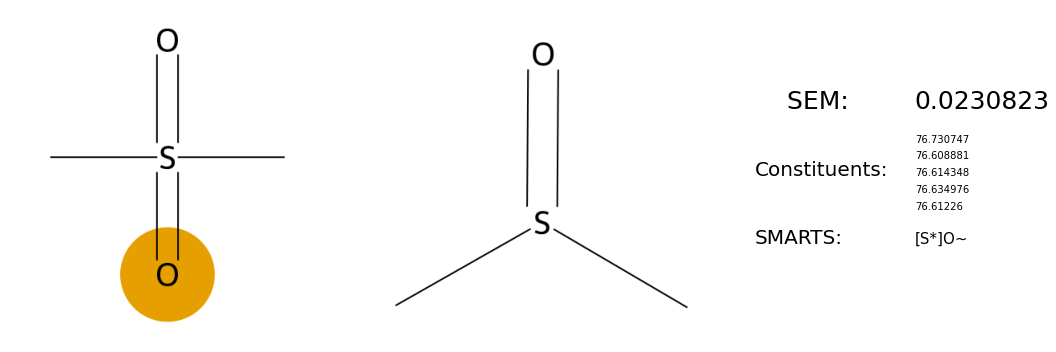

__________________________________________________________________________________________________________
mobley_1563176~mobley_2864987
./QUINTUP/30_dir_dir/finished/job_xgg/sim_18/mobley_1563176~mobley_2864987/free
./QUINTUP/30_dir_dir/finished/job_xgg/sim_20/mobley_1563176~mobley_2864987/free
./QUINTUP/30_dir_dir/finished/job_xgg/sim_17/mobley_1563176~mobley_2864987/free
./QUINTUP/30_dir_dir/finished/job_xgg/sim_19/mobley_1563176~mobley_2864987/free
./QUINTUP/30_dir_dir/finished/job_xgg/sim_16/mobley_1563176~mobley_2864987/free


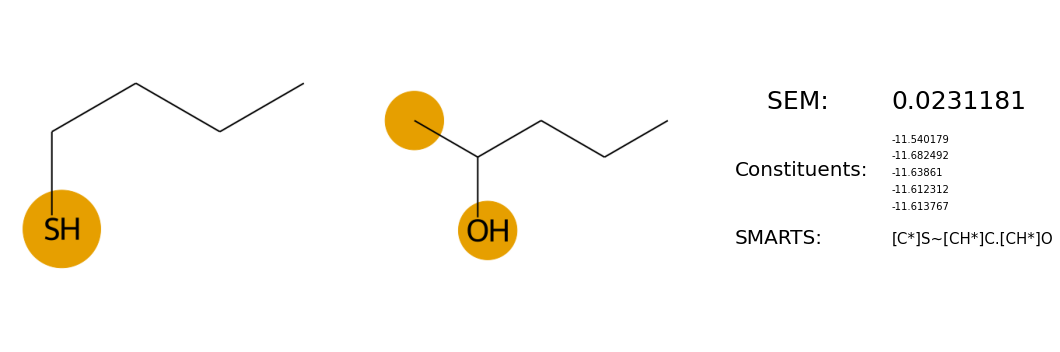

__________________________________________________________________________________________________________
mobley_1520842~mobley_4287564
./QUINTUP/29_dir_dir/finished/job_xcm/sim_18/mobley_1520842~mobley_4287564/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_20/mobley_1520842~mobley_4287564/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_17/mobley_1520842~mobley_4287564/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_19/mobley_1520842~mobley_4287564/free
./QUINTUP/29_dir_dir/finished/job_xcm/sim_16/mobley_1520842~mobley_4287564/free


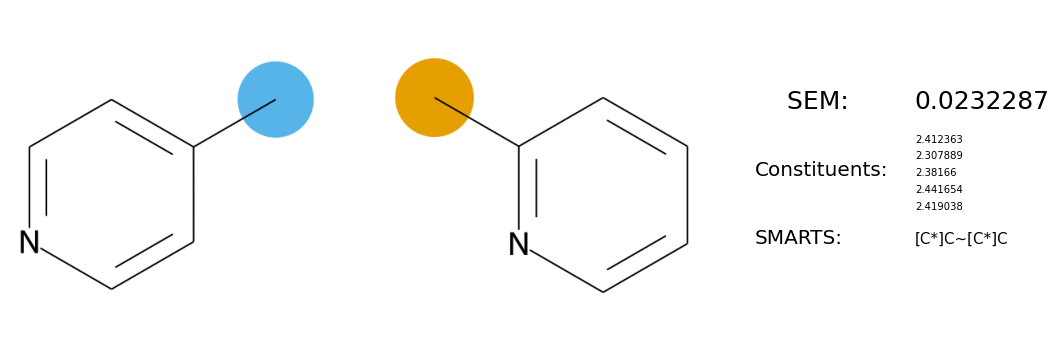

__________________________________________________________________________________________________________
mobley_1650157~mobley_1261349
./QUINTUP/29_dir_dir/finished/job_xda/sim_18/mobley_1650157~mobley_1261349/free
./QUINTUP/29_dir_dir/finished/job_xda/sim_20/mobley_1650157~mobley_1261349/free
./QUINTUP/29_dir_dir/finished/job_xda/sim_17/mobley_1650157~mobley_1261349/free
./QUINTUP/29_dir_dir/finished/job_xda/sim_19/mobley_1650157~mobley_1261349/free
./QUINTUP/29_dir_dir/finished/job_xda/sim_16/mobley_1650157~mobley_1261349/free


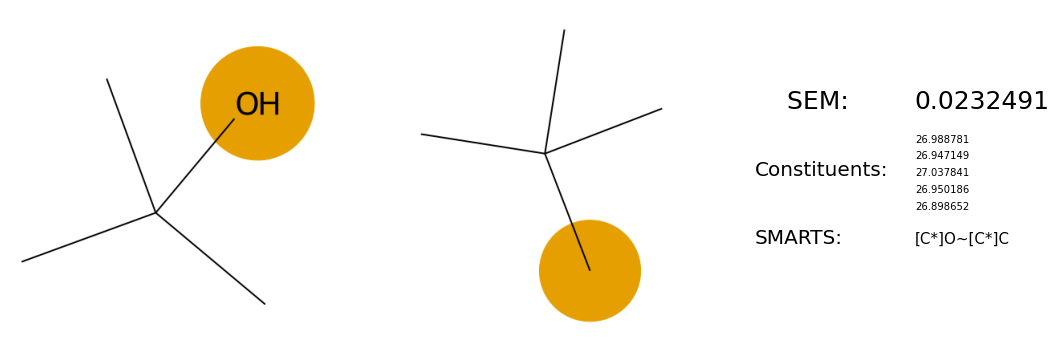

__________________________________________________________________________________________________________
mobley_1674094~mobley_3546460
./QUINTUP/29_dir_dir/finished/job_xdp/sim_14/mobley_1674094~mobley_3546460/free
./QUINTUP/29_dir_dir/finished/job_xdp/sim_13/mobley_1674094~mobley_3546460/free
./QUINTUP/29_dir_dir/finished/job_xdp/sim_12/mobley_1674094~mobley_3546460/free
./QUINTUP/29_dir_dir/finished/job_xdp/sim_15/mobley_1674094~mobley_3546460/free
./QUINTUP/29_dir_dir/finished/job_xdp/sim_11/mobley_1674094~mobley_3546460/free


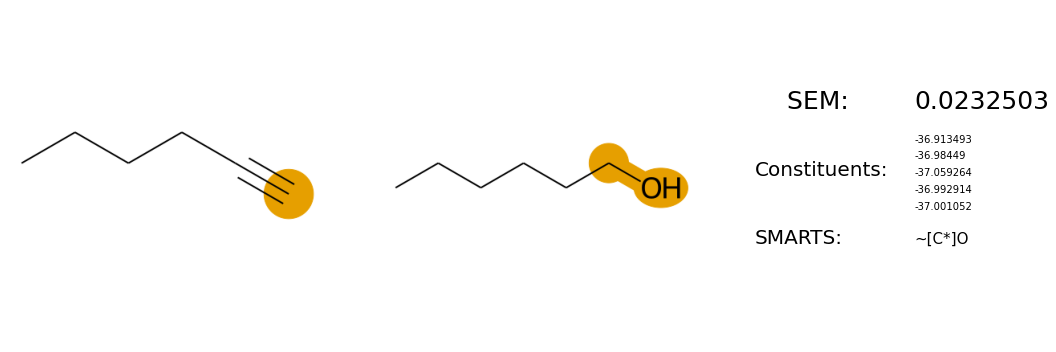

__________________________________________________________________________________________________________
mobley_1881249~mobley_5449201
./QUINTUP/29_dir_dir/finished/job_xgl/sim_3/mobley_1881249~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xgl/sim_1/mobley_1881249~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xgl/sim_5/mobley_1881249~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xgl/sim_4/mobley_1881249~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xgl/sim_2/mobley_1881249~mobley_5449201/free


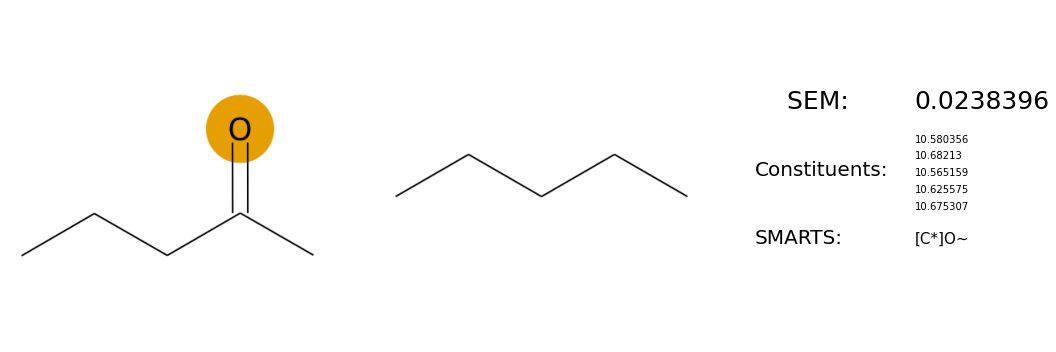

__________________________________________________________________________________________________________
mobley_9733743~mobley_8426916
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_14/mobley_9733743~mobley_8426916/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_13/mobley_9733743~mobley_8426916/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_12/mobley_9733743~mobley_8426916/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_15/mobley_9733743~mobley_8426916/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_11/mobley_9733743~mobley_8426916/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_14/mobley_9733743~mobley_8426916/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_13/mobley_9733743~mobley_8426916/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyx/sim_12/mobley_9733743~mobley_8426916/free

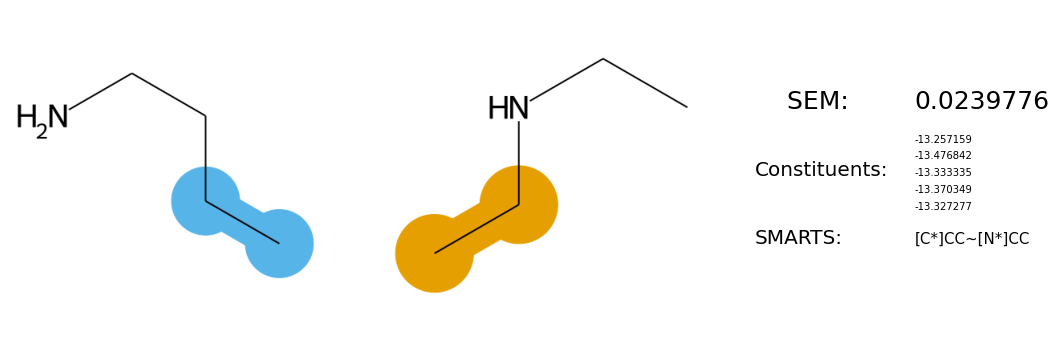

__________________________________________________________________________________________________________
mobley_1827204~mobley_3546460
./QUINTUP/31_dir_dir/transform_0/finished/sim_74/mobley_1827204~mobley_3546460/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_71/mobley_1827204~mobley_3546460/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_72/mobley_1827204~mobley_3546460/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_73/mobley_1827204~mobley_3546460/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_75/mobley_1827204~mobley_3546460/free
./QUINTUP/17_dir_dir/quintup_transform_0/job_0/GPU_population_2/mobley_1827204~mobley_3546460/free
./QUINTUP/17_dir_dir/quintup_transform_0/job_0/GPU_population_0/mobley_1827204~mobley_3546460/free
./QUINTUP/17_dir_dir/quintup_transform_0/job_0/GPU_population_3/mobley_1827204~mobley_3546460/free
./QUINTUP/17_dir_dir/quintup_transform_0/job_0/GPU_population_1/mobley_1827204~mobley_3546460/free
./QUINTUP/23_dir_dir/round2/quintup_transform_0

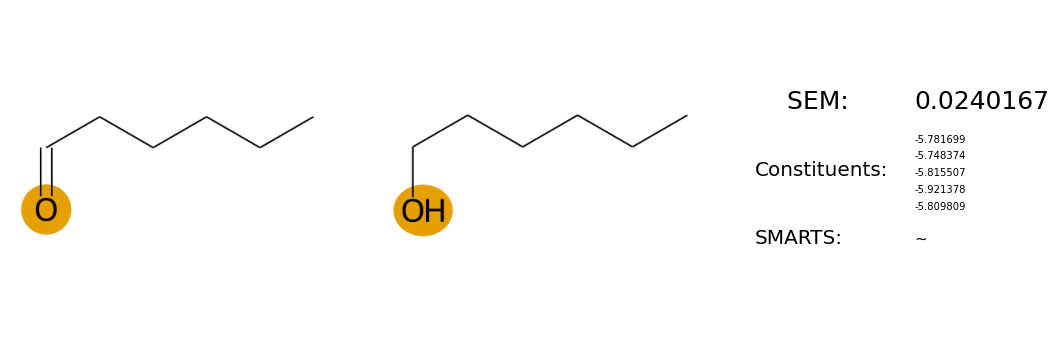

__________________________________________________________________________________________________________
mobley_3546460~mobley_1827204


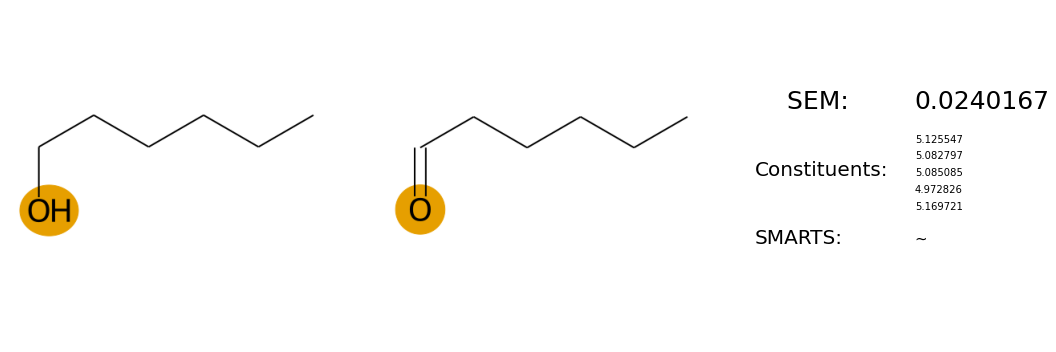

__________________________________________________________________________________________________________
mobley_1923244~mobley_1977493
./QUINTUP/29_dir_dir/finished/job_xht/sim_18/mobley_1923244~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_20/mobley_1923244~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_17/mobley_1923244~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_19/mobley_1923244~mobley_1977493/free
./QUINTUP/29_dir_dir/finished/job_xht/sim_16/mobley_1923244~mobley_1977493/free


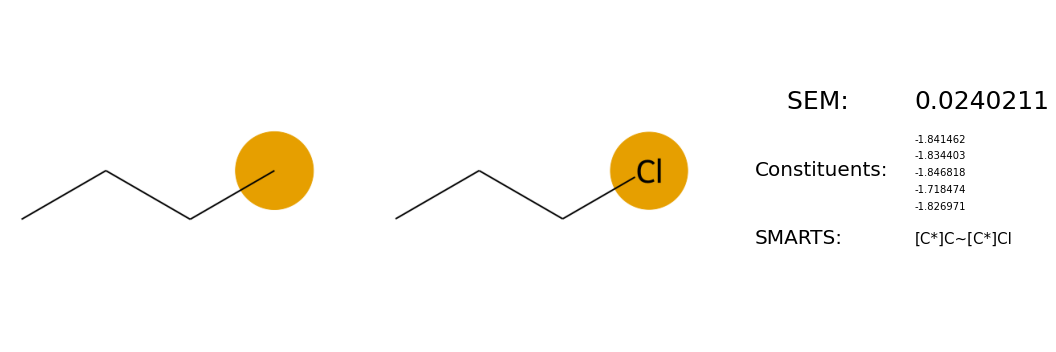

__________________________________________________________________________________________________________
mobley_1873346~mobley_5311804
./QUINTUP/29_dir_dir/finished/job_xfy/sim_14/mobley_1873346~mobley_5311804/free
./QUINTUP/29_dir_dir/finished/job_xfy/sim_13/mobley_1873346~mobley_5311804/free
./QUINTUP/29_dir_dir/finished/job_xfy/sim_12/mobley_1873346~mobley_5311804/free
./QUINTUP/29_dir_dir/finished/job_xfy/sim_15/mobley_1873346~mobley_5311804/free
./QUINTUP/29_dir_dir/finished/job_xfy/sim_11/mobley_1873346~mobley_5311804/free


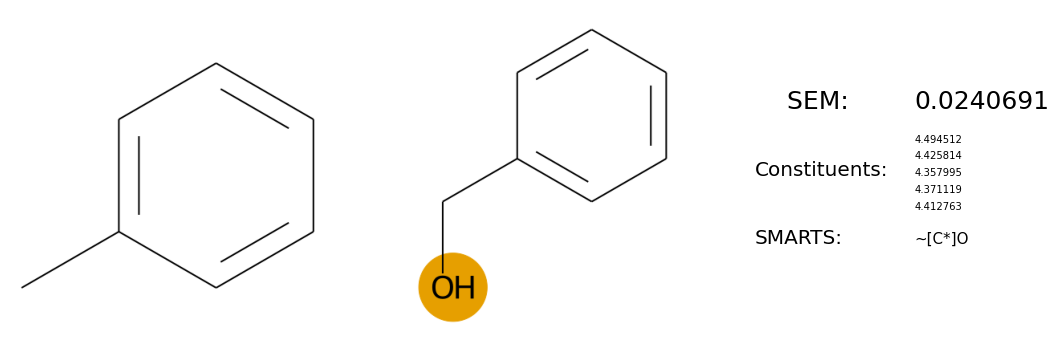

__________________________________________________________________________________________________________
mobley_1976156~mobley_4375719
./QUINTUP/29_dir_dir/finished/job_xii/sim_7/mobley_1976156~mobley_4375719/free
./QUINTUP/29_dir_dir/finished/job_xii/sim_9/mobley_1976156~mobley_4375719/free
./QUINTUP/29_dir_dir/finished/job_xii/sim_8/mobley_1976156~mobley_4375719/free
./QUINTUP/29_dir_dir/finished/job_xii/sim_6/mobley_1976156~mobley_4375719/free
./QUINTUP/29_dir_dir/finished/job_xii/sim_10/mobley_1976156~mobley_4375719/free


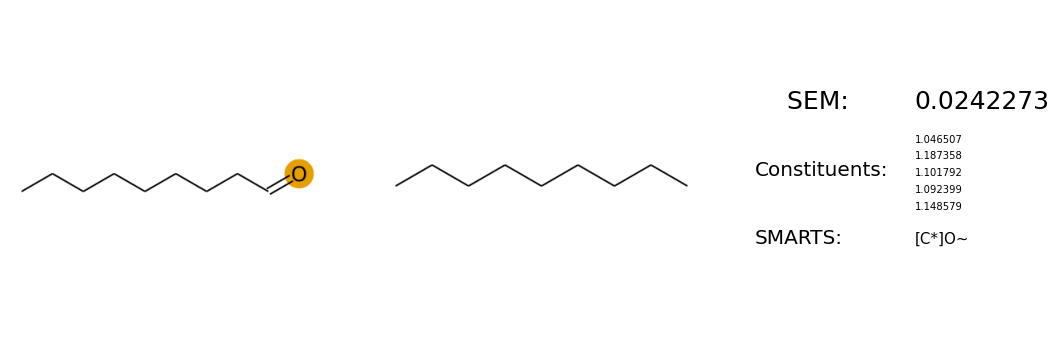

__________________________________________________________________________________________________________
mobley_1803862~mobley_7106722
./QUINTUP/29_dir_dir/finished/job_xfa/sim_18/mobley_1803862~mobley_7106722/free
./QUINTUP/29_dir_dir/finished/job_xfa/sim_20/mobley_1803862~mobley_7106722/free
./QUINTUP/29_dir_dir/finished/job_xfa/sim_17/mobley_1803862~mobley_7106722/free
./QUINTUP/29_dir_dir/finished/job_xfa/sim_19/mobley_1803862~mobley_7106722/free
./QUINTUP/29_dir_dir/finished/job_xfa/sim_16/mobley_1803862~mobley_7106722/free


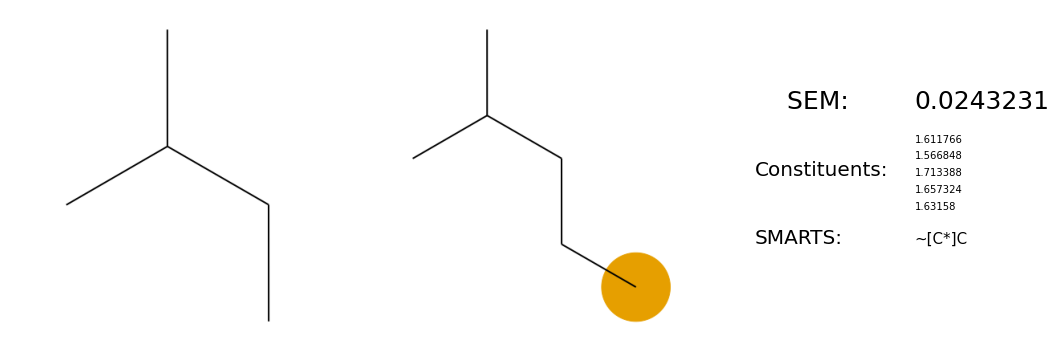

__________________________________________________________________________________________________________
mobley_1873346~mobley_5520946
./QUINTUP/29_dir_dir/finished/job_xfz/sim_3/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_3/mobley_1873346~mobley_5520946/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_1/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_1/mobley_1873346~mobley_5520946/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_5/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_5/mobley_1873346~mobley_5520946/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_4/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_4/mobley_1873346~mobley_5520946/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/job_xfz/sim_2/mobley_1873346~mobley_5520946/free
./QUINTUP/29_dir_dir/finished/jo

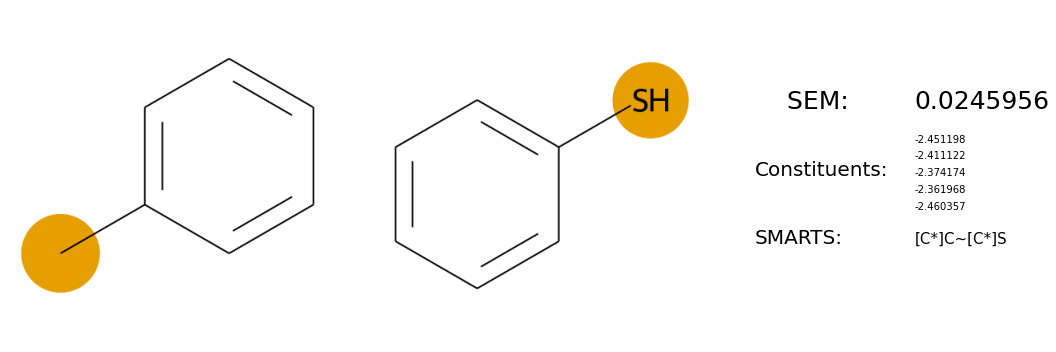

__________________________________________________________________________________________________________
mobley_9883303~mobley_2517158
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_14/mobley_9883303~mobley_2517158/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_13/mobley_9883303~mobley_2517158/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_12/mobley_9883303~mobley_2517158/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_15/mobley_9883303~mobley_2517158/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_11/mobley_9883303~mobley_2517158/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_14/mobley_9883303~mobley_2517158/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_13/mobley_9883303~mobley_2517158/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeah/sim_12/mobley_9883303~mobley_2517158/free

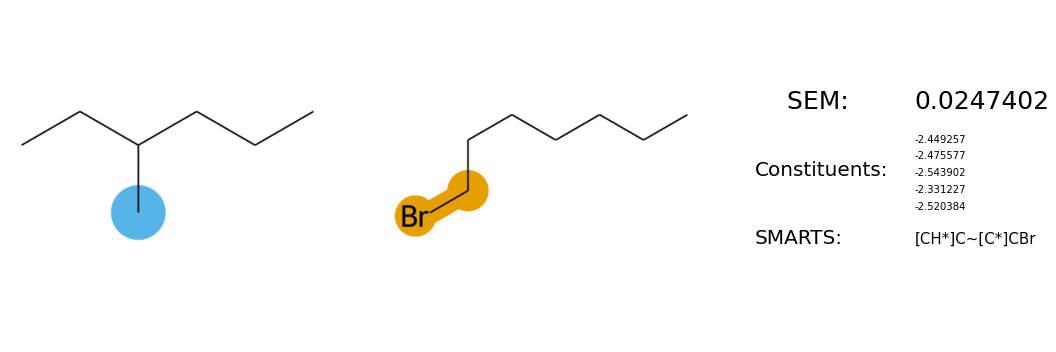

__________________________________________________________________________________________________________
mobley_1107178~mobley_1967551
./QUINTUP/29_dir_dir/finished/job_xaw/sim_14/mobley_1107178~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xaw/sim_13/mobley_1107178~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xaw/sim_12/mobley_1107178~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xaw/sim_15/mobley_1107178~mobley_1967551/free
./QUINTUP/29_dir_dir/finished/job_xaw/sim_11/mobley_1107178~mobley_1967551/free


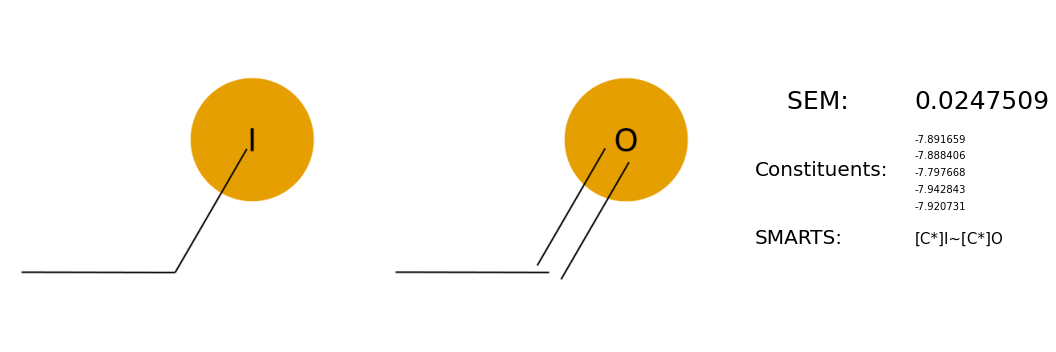

__________________________________________________________________________________________________________
mobley_2049967~mobley_186894
./QUINTUP/29_dir_dir/finished/job_xja/sim_14/mobley_2049967~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xja/sim_13/mobley_2049967~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xja/sim_12/mobley_2049967~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xja/sim_15/mobley_2049967~mobley_186894/free
./QUINTUP/29_dir_dir/finished/job_xja/sim_11/mobley_2049967~mobley_186894/free


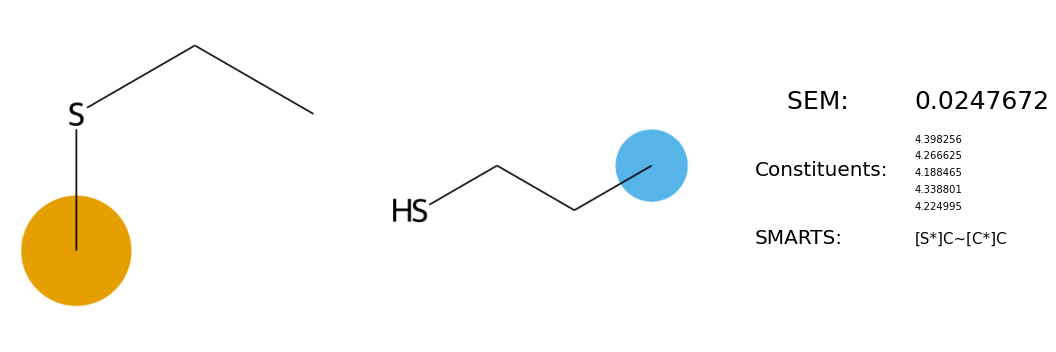

__________________________________________________________________________________________________________
mobley_186894~mobley_2049967
./QUINTUP/29_dir_dir/finished/job_xfr/sim_14/mobley_186894~mobley_2049967/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_13/mobley_186894~mobley_2049967/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_12/mobley_186894~mobley_2049967/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_15/mobley_186894~mobley_2049967/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_11/mobley_186894~mobley_2049967/mobley_186894~mobley_2049967/free
./QUINTUP/29_dir_dir/finished/job_xfr/sim_11/mobley_186894~mobley_2049967/free


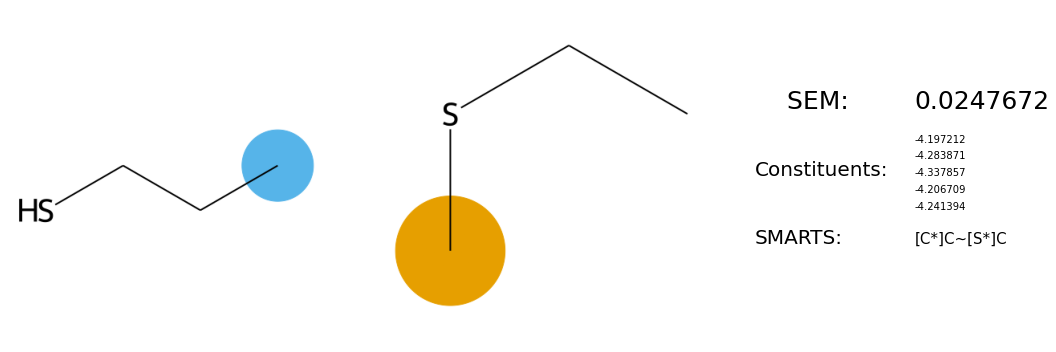

__________________________________________________________________________________________________________
mobley_1563176~mobley_8492526
./QUINTUP/30_dir_dir/finished/job_xgq/sim_3/mobley_1563176~mobley_8492526/free
./QUINTUP/30_dir_dir/finished/job_xgq/sim_1/mobley_1563176~mobley_8492526/free
./QUINTUP/30_dir_dir/finished/job_xgq/sim_5/mobley_1563176~mobley_8492526/free
./QUINTUP/30_dir_dir/finished/job_xgq/sim_4/mobley_1563176~mobley_8492526/free
./QUINTUP/30_dir_dir/finished/job_xgq/sim_2/mobley_1563176~mobley_8492526/free


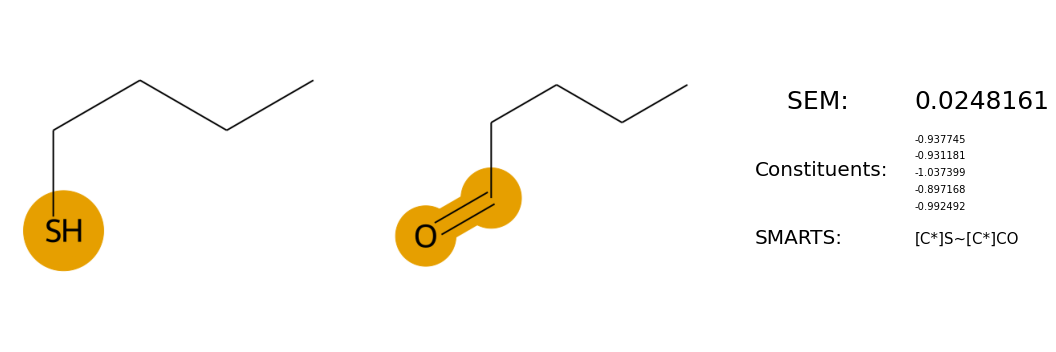

__________________________________________________________________________________________________________
mobley_1650157~mobley_1803862
./QUINTUP/29_dir_dir/finished/job_xdb/sim_3/mobley_1650157~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xdb/sim_1/mobley_1650157~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xdb/sim_5/mobley_1650157~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xdb/sim_4/mobley_1650157~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xdb/sim_2/mobley_1650157~mobley_1803862/free


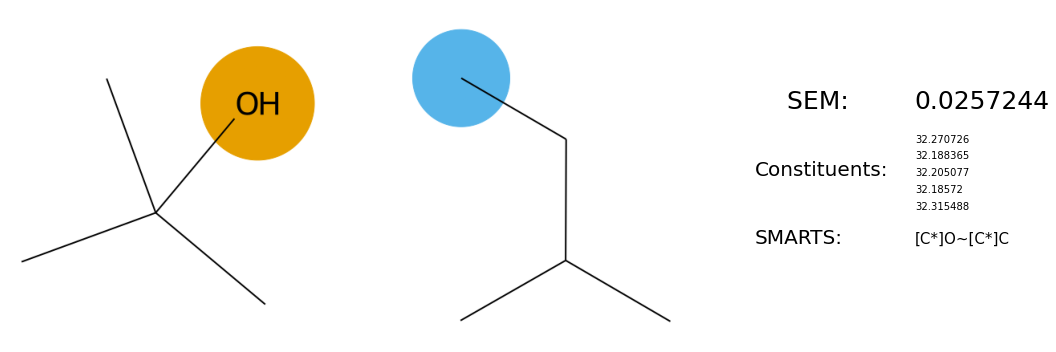

__________________________________________________________________________________________________________
mobley_1662128~mobley_1803862
./QUINTUP/29_dir_dir/finished/job_xde/sim_14/mobley_1662128~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xde/sim_13/mobley_1662128~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xde/sim_12/mobley_1662128~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xde/sim_15/mobley_1662128~mobley_1803862/free
./QUINTUP/29_dir_dir/finished/job_xde/sim_11/mobley_1662128~mobley_1803862/free


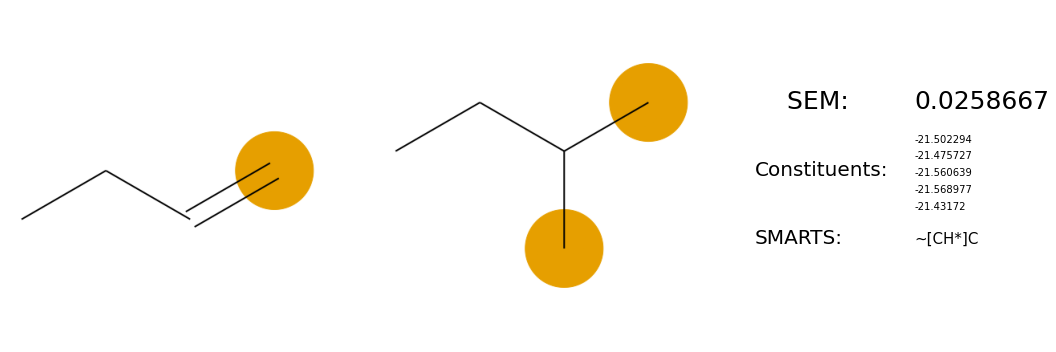

__________________________________________________________________________________________________________
mobley_1019269~mobley_5816127
./QUINTUP/30_dir_dir/finished/job_xap/sim_18/mobley_1019269~mobley_5816127/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_20/mobley_1019269~mobley_5816127/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_17/mobley_1019269~mobley_5816127/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_19/mobley_1019269~mobley_5816127/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_16/mobley_1019269~mobley_5816127/free


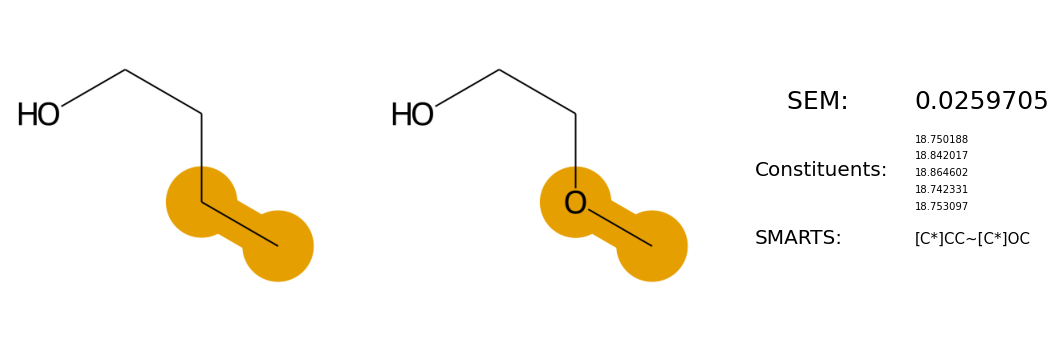

__________________________________________________________________________________________________________


In [30]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sort_values(by="sem").head(100))

# Randomly picked realistic SEMs:

In [ ]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sample(50))